In [1]:
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', 100)
from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import datetime

## Classifying investor purchases

Process to classify deeds as (a) residential properties, (b) likely purchased by investors.

## 1. Selecting deeds that fall within residential parcels

Using land use data from the city of Philadelphia (see original source [here](https://www.opendataphilly.org/dataset/land-use))

In [2]:
# read in land use file
landuse = gpd.read_file("data/Land_Use_2019/Land_Use.shp")

In [3]:
# creating a more narrow set of residential parcels
# just low and medium residential uses
res = landuse.loc[(landuse['C_DIG2DESC']=='Residential Medium') | 
                    (landuse['C_DIG2DESC']=='Residential Low')]

# dropping pacels with na values for their geometry
res = res.dropna(subset=['geometry'])

# reprojecting residential low/med only category
res = res.to_crs('epsg:2272')

In [4]:
res.to_file("data/res_properties.geojson", driver = 'GeoJSON')

In [5]:
# reading in the real estate tax transfer data
rtt = pd.read_csv("data/rtt_summary.csv")

C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (26,34,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# selecting just deeds (not mortgages and other transfer taxes)
deeds = rtt.loc[rtt['document_type'] == "DEED"]
sheriff_deeds = rtt.loc[rtt['document_type'] == "DEED SHERIFF"]
# adding a year column from the document date
deeds["sort_year"] = deeds['display_date'].astype(str).str[:4]
sheriff_deeds['sort_year'] = sheriff_deeds['display_date'].astype(str).str[:4]

C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
# defining points from lat/lon
deeds_points = [Point(xy) for xy in zip(deeds.lat,deeds.lng)]
deedsgeo = gpd.GeoDataFrame(deeds, geometry=deeds_points)
sheriff_deeds_points = [Point(xy) for xy in zip(sheriff_deeds.lat, sheriff_deeds.lng)]
sheriff_deedsgeo = gpd.GeoDataFrame(sheriff_deeds, geometry = sheriff_deeds_points)

In [8]:
# selecting only deeds with non zero state taxes
deedsgeo = deedsgeo.loc[deedsgeo["state_tax_amount"] > 0]

# and that also have an address field
deedsgeo= deedsgeo.loc[deedsgeo["address_low"]>0]
sheriff_deedsgeo = sheriff_deedsgeo.loc[sheriff_deedsgeo['address_low']>0]

In [9]:
# setting the projection for the lat lon coordinates 
deedsgeo.crs = 'epsg:4326'
sheriff_deedsgeo.crs = 'epsg:4326'

In [10]:
# reprojecting to: EPSG:2272: NAD83 / Pennsylvania South (ftUS)
deedsgeo = deedsgeo.to_crs('epsg:2272')
sheriff_deedsgeo = sheriff_deedsgeo.to_crs('epsg:2272')

In [11]:
# spatial join between deeds and residential parcels (to find only those deeds within residential parcels)
deeds_res = gpd.sjoin(deedsgeo,res, how="inner",op="within")
sheriff_deeds_res = gpd.sjoin(sheriff_deedsgeo, res, how="inner", op="within")

## 2. Identify likely investor purchases
First tag all grantees with corporate entity names. Then find all investors who purchased more than 2 properties in any one year span.   

### 2A. Identifying Deeds with likely investors as the grantee based on grantee name
First tag all investor named entities   
  - LLC
  - LP
  - LIMITED PARTNERSHIP
  - CORP
  - CORPORATION
  - INC
  - COMPANY
  - LIMITED PARTNE
  - L P
  - L L C
  - PARTNERSHIP
  - LTD
  - TRUST 
    


In [12]:
# selecting just post-2000 deeds
deeds_res['sort_year'] = pd.to_numeric(deeds_res['sort_year'])
deeds_res = deeds_res.loc[deeds_res['sort_year']>1999]
sheriff_deeds_res['sort_year'] = pd.to_numeric(sheriff_deeds_res['sort_year'])
sheriff_deeds_res = sheriff_deeds_res.loc[sheriff_deeds_res['sort_year']>1999]

# selecting investors by grantee name
inv = deeds_res['grantees'].str.contains(
    'LLC|LP|LIMITED PARTNERSHIP|CORP|CORPORATION|INC|COMPANY|LIMITED PARTNE|L P|L L C|PARTNERSHIP|LTD|TRUST'
    ,regex=True)
inv_f = sheriff_deeds_res['grantors'].str.contains(
     'LLC|LP|LIMITED PARTNERSHIP|CORP|CORPORATION|INC|COMPANY|LIMITED PARTNE|L P|L L C|PARTNERSHIP|LTD|TRUST'
    ,regex=True)

# converting investors series to dataframe
inv = inv.to_frame()
inv_f = inv_f.to_frame()

# merging with deeds
deeds_inv = deeds_res.merge(
    inv, left_index=True, right_index = True)
sheriff_deeds_inv = sheriff_deeds_res.merge(
    inv_f, left_index=True, right_index=True)
deeds_inv = deeds_inv.dropna(subset=['grantees_x'])
sheriff_deeds_inv = sheriff_deeds_inv.dropna(subset=['grantors_x'])

# creating a count column to allow grouping and count 
# for investor and owner by year 
deeds_inv['inv'] = deeds_inv['grantees_y'].apply(lambda x: 1 if x == True else 0)
deeds_inv['occ'] = deeds_inv['grantees_y'].apply(lambda x: 1 if x == False else 0)

sheriff_deeds_inv['inv'] = sheriff_deeds_inv['grantors_y'].apply(lambda x: 1 if x == True else 0)
sheriff_deeds_inv['occ'] = sheriff_deeds_inv['grantors_y'].apply(lambda x: 1 if x == False else 0)

# dropping duplicate object ids from the dataset
deeds_inv = deeds_inv.drop_duplicates(subset="objectid")
sheriff_deeds_inv = sheriff_deeds_inv.drop_duplicates(subset="objectid")

### 2B. Classifying investor purchases by multiple purchasers
Identifying grantees who purchased more than 2 properties in any one year period from the full set of non-investor classified deeds:

In [13]:
# finding multiple purchasers from the full set of non-investor classified deeds
# selecting from just the non llc llp deeds
occ = deeds_inv.loc[deeds_inv['occ']==1]
occ_f = sheriff_deeds_inv.loc[sheriff_deeds_inv['occ']==1]

In [14]:
# getting all deeds from purchasers who are associated with more than one deed
multiple_purchasers = occ.groupby(
    "grantees_x").filter(lambda s: s['objectid'].count()>=2)


In [15]:
# converting date to datetime format
multiple_purchasers['display_date'] = multiple_purchasers[
    'display_date'].astype('datetime64[ns]')

In [16]:
# dropping unneeded columns
columns_multi = ['objectid','grantors','grantees_x',
                 'display_date','sort_year','street_address']
multiple_purchase_simple = multiple_purchasers[columns_multi]


In [17]:

multiple_purchase_simple[
    'elapsed'] = multiple_purchase_simple.sort_values(
    ['grantees_x','display_date']).groupby(
    'grantees_x')['display_date'].diff()

# converting timedelta column to an int type 
# to make it possible to filter below
multiple_purchase_simple[
    'elapsed_days'] = multiple_purchase_simple[
    'elapsed'].dt.days


C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [18]:
# filtering for deeds from grantees who purchased two properties within 1 year of each other
multiple_investors = multiple_purchase_simple.groupby('grantees_x').filter(
    lambda x: x['elapsed_days'].min() <= 365)
multiple_investors['multi_invest'] = 1

## 4. merging multiple purchase investors back with full set of deeds

Compiling a comprehensive classification of investor purchases 

In [19]:
deeds_multi = deeds_inv.merge(
    multiple_investors, left_on="objectid", right_on="objectid",how="left")

deeds_multi["investor_all"] = deeds_multi[
    "inv"] + deeds_multi["multi_invest"].fillna(0)
deeds_multi['owner_occup'] = deeds_multi[
    'investor_all'].apply(lambda x: 0 if x == 1 else 1)

In [20]:
# Saving classified deeds to speed up future processing time 
deeds_for_save = deeds_multi
deeds_for_save['elapsed'] = deeds_for_save['elapsed'].fillna(pd.Timedelta('999 days'))
deeds_for_save['elapsed'] = deeds_for_save['elapsed'].dt.days.astype('int16')
deeds_for_save['display_date_y'] = deeds_for_save['display_date_y'].astype(str)


In [21]:
#ranking to find most recent deed change (labeled as 1)
deeds_for_save['receipt_date'] = pd.to_datetime(deeds_for_save['receipt_date'])
deeds_for_save['Rank'] = deeds_for_save.groupby('street_address_x')['receipt_date'].rank(ascending=False)

In [22]:
#sorting based on street address and receipt date
deeds_for_save = deeds_for_save.sort_values(by=['street_address_x','receipt_date'])

In [23]:
#finding the owernship period of a deed
deeds_for_save['own_period'] = deeds_for_save.groupby('street_address_x')['receipt_date'].diff() / np.timedelta64(1, 'D')
deeds_for_save['own_period'] = deeds_for_save['own_period'].fillna(999)

In [24]:
#classifying as investor rental, investor flip, or non investor
deeds_for_save['classification'] = np.where((deeds_for_save.investor_all == 1) & 
                                              (deeds_for_save.Rank == 1.0) & 
                                              (deeds_for_save.own_period >= 575) &
                                              (deeds_for_save.inv == 1), 'institutional investor rental', 
                                              np.where((deeds_for_save.investor_all == 1) & 
                                                       (deeds_for_save.Rank == 1.0) & 
                                                       (deeds_for_save.own_period >= 575) &
                                                       (deeds_for_save.inv == 0), 'non institutional investor rental',
                                                       np.where((deeds_for_save.investor_all == 1) & 
                                                                (deeds_for_save.inv==1) &
                                                                (deeds_for_save.own_period < 575), 'institutional investor flip', 
                                                                np.where((deeds_for_save.investor_all == 1) &
                                                                         (deeds_for_save.own_period < 575) &
                                                                         (deeds_for_save.inv == 0),'non institutional investor flip', 'non investor'))))
deeds_for_save['classification'] = deeds_for_save['classification'].fillna('non investor')

In [25]:
# saving final list of grantees
deeds_for_save.to_file('data/rtt_investors_rentals_flips.geojson', driver = 'GeoJSON')


In [30]:
sheriff_deeds_res.to_file('data/rtt_foreclosures.geojson', driver='GeoJSON')

In [81]:
# saving final list of grantees
#with open("data/rtt_investors_classified.geojson",
 #         'w') as f:
#    f.write(deeds_for_save.to_json())
#deeds_for_save.to_file('philadelphia_deeds.shp', driver='ESRI Shapefile')

## 5. Reimport geojson of classified deeds

To reimport classified deeds use gpd.read_file and then set the coordinate reference system:

In [31]:
# read in classified deeds file
rtt_classified = gpd.read_file("data/rtt_investors_rentals_flips.geojson")
rtt_foreclosures = gpd.read_file("data/rtt_foreclosures.geojson")

In [32]:
rtt_classified['count_field'] = 1
rtt_classified['year'] = rtt_classified['sort_year_x'].astype(str)
rtt_foreclosures['count_field'] = 1
rtt_foreclosures['year'] = rtt_foreclosures['sort_year'].astype(str)

In [33]:
# creating binary indicator columns for different rtt deed classifications
rtt_classified['institutional_investor_rental'] = np.where(rtt_classified['classification'].str.contains('institutional investor rental', regex=True),1, 0)
rtt_classified['non_institutional_investor_rental'] = np.where(rtt_classified['classification'].str.contains('non institutional investor rental', regex=True),1, 0)
rtt_classified['institutional_investor_flip'] = np.where(rtt_classified['classification'].str.contains('institutional investor flip', regex=True),1, 0)
rtt_classified['non_institutional_investor_flip'] = np.where(rtt_classified['classification'].str.contains('non institutional investor flip', regex=True),1, 0)
rtt_classified['non_investor'] = np.where(rtt_classified['classification'].str.contains('non investor', regex=True),1, 0)


In [34]:
res_c = gpd.read_file("data/res_properties.geojson")

In [35]:
res_c = res_c.to_crs('epsg:2272')

In [36]:
res_c_counts = res_c[['OBJECTID', 'geometry']]

In [37]:
res_c_counts = res_c_counts.rename(columns = {'OBJECTID':'res_parcel_num'})

In [40]:
#reading census block
b00 = gpd.read_file('data/Census_Blocks_2000-shp/Census_Blocks_2000.shp')
b10 = gpd.read_file('data/Census_Blocks_2010-shp/Census_Blocks_2010.shp')

In [41]:
#reprojecting blocks
b00 = b00.to_crs('epsg:2272')
b10 = b10.to_crs('epsg:2272')

In [ ]:
# # use this to check alignment of datasets by plotting
# base = b10.plot(figsize=(20,20),color='grey', edgecolor='grey')
# deeds.loc[deeds["sort_year_x"]==2000].plot(ax=base, markersize=.5,color='red')

### 2. Spatial Join between deeds, foreclosures, and blocks + aggregating by year

In [42]:
rtt_classified = rtt_classified.drop(['index_right'], axis=1)
rtt_foreclosures = rtt_foreclosures.drop(['index_right'], axis=1)

In [43]:
# spatial join of deeds and foreclosures to two sets of block groups
deeds_b_00_10 = gpd.sjoin(b00,rtt_classified.loc[rtt_classified["sort_year_x"] <2010], how='left', op='intersects').reset_index()
deeds_b_10_18 = gpd.sjoin(b10,rtt_classified.loc[rtt_classified["sort_year_x"]>=2010], how='left', op='intersects').reset_index()

foreclosures_b_00_10 = gpd.sjoin(b00,rtt_foreclosures.loc[rtt_foreclosures["sort_year"]<2010], how='left', op='intersects').reset_index()
foreclosures_b_10_18 = gpd.sjoin(b10,rtt_foreclosures.loc[rtt_foreclosures["sort_year"]>=2010], how='left', op='intersects').reset_index()


In [44]:
#getting counts of purchases by type for year block for each year
grouped_deeds00_10 = deeds_b_00_10.groupby(['CBLK00_', 'year']).agg({'institutional_investor_rental':'sum',
                                                        'non_institutional_investor_rental':'sum',
                                                        'institutional_investor_flip':'sum', 'non_institutional_investor_flip':'sum',
                                                        'non_investor':'sum','count_field':'count'}).unstack()

grouped_foreclosures00_10 = foreclosures_b_00_10.groupby(['CBLK00_', 'year']).agg({'count_field':'count'}).unstack()

In [45]:
#getting counts of purchases by type for year block for each year
grouped_deeds10_18 = deeds_b_10_18.groupby(['GEOID10', 'year']).agg({'institutional_investor_rental':'sum',
                                                        'non_institutional_investor_rental':'sum',
                                                        'institutional_investor_flip':'sum', 'non_institutional_investor_flip':'sum',
                                                        'non_investor':'sum','count_field':'count'}).unstack()


grouped_foreclosures10_18 = foreclosures_b_10_18.groupby(['GEOID10', 'year']).agg({'count_field':'count'}).unstack()

In [46]:
# unstacking the grouped columns
new_cols_d = [''.join(t) for t in grouped_deeds00_10.columns]
grouped_deeds00_10.columns = new_cols_d
new_cols_f = [''.join(t) for t in grouped_foreclosures00_10.columns]
grouped_foreclosures00_10.columns = new_cols_f
new_cols_18_d = [''.join(t) for t in grouped_deeds10_18.columns]
grouped_deeds10_18.columns = new_cols_18_d
new_cols_18_f = [''.join(t) for t in grouped_foreclosures10_18.columns]
grouped_foreclosures10_18.columns = new_cols_18_f

In [47]:
# getting geometry column
b00_geometry = b00[['CBLK00_','geometry']]
b10_geometry = b10[['GEOID10','geometry']]

In [48]:
# merging grouped blocks with geometry field
grouped_deeds00_10 = b00_geometry.merge(grouped_deeds00_10,how='left',left_on='CBLK00_',right_on='CBLK00_')
grouped_deeds10_18 = b10_geometry.merge(grouped_deeds10_18,how='left',left_on='GEOID10',right_on='GEOID10')

grouped_foreclosures00_10 = b00_geometry.merge(grouped_foreclosures00_10,how='left',left_on='CBLK00_',right_on='CBLK00_')
grouped_foreclosures10_18 = b10_geometry.merge(grouped_foreclosures10_18,how='left',left_on='GEOID10',right_on='GEOID10')


# converting to a geodataframe
grouped_deeds00_10 = gpd.GeoDataFrame(grouped_deeds00_10, geometry=grouped_deeds00_10['geometry'])
grouped_deeds10_18 = gpd.GeoDataFrame(grouped_deeds10_18, geometry=grouped_deeds10_18['geometry'])

grouped_foreclosures00_10 = gpd.GeoDataFrame(grouped_foreclosures00_10, geometry=grouped_foreclosures00_10['geometry'])
grouped_foreslosures10_18 = gpd.GeoDataFrame(grouped_foreclosures10_18, geometry=grouped_foreclosures10_18['geometry'])


In [49]:
# joining residential parcels from land use to blocks to have count of parcels
# deeds_b_00_10_i = deeds_b_00_10_i.drop(columns = ['index_right'])
# deeds_b_10_18_i = deeds_b_10_18_i.drop(columns = ['index_right'])
res_b_00_10 = gpd.sjoin(b00,res_c_counts, how='left', op='intersects').reset_index() 
res_b_10_18 = gpd.sjoin(b10,res_c_counts, how='left', op='intersects').reset_index() 

In [50]:
res_count00 = res_b_00_10.groupby(["CBLK00_"]).agg({'res_parcel_num':'count'}).reset_index()
res_count10 = res_b_10_18.groupby(["GEOID10"]).agg({'res_parcel_num':'count'}).reset_index()

In [51]:
grouped_deeds00_10_i = grouped_deeds00_10.merge(res_count00,how='left',left_on='CBLK00_',right_on='CBLK00_')
grouped_deeds10_18_i = grouped_deeds10_18.merge(res_count10,how='left',left_on='GEOID10',right_on='GEOID10')

grouped_foreclosures00_10_i = grouped_foreclosures00_10.merge(res_count00, how='left', left_on='CBLK00_', right_on='CBLK00_')
grouped_foreclosures10_18_i = grouped_foreclosures10_18.merge(res_count10, how='left', left_on='GEOID10', right_on='GEOID10')

### 3. Calculating percent by classification purchases per block per year

In [52]:
# percent of purchases by block that are institutional investor purchases for rentals
#2000
grouped_deeds00_10_i['per_inst_inv_2000'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds00_10_i['per_inst_inv_2001'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds00_10_i['per_inst_inv_2002'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds00_10_i['per_inst_inv_2003'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds00_10_i['per_inst_inv_2004'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds00_10_i['per_inst_inv_2005'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds00_10_i['per_inst_inv_2006'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds00_10_i['per_inst_inv_2007'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds00_10_i['per_inst_inv_2008'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds00_10_i['per_inst_inv_2009'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds10_18_i['per_inst_inv_2010'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds10_18_i['per_inst_inv_2011'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds10_18_i['per_inst_inv_2012'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds10_18_i['per_inst_inv_2013'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds10_18_i['per_inst_inv_2014'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds10_18_i['per_inst_inv_2015'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds10_18_i['per_inst_inv_2016'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds10_18_i['per_inst_inv_2017'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds10_18_i['per_inst_inv_2018'] = grouped_deeds10_18_i.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2018']/x['res_parcel_num'], axis=1)

In [53]:
#### 3b - non institutional investor rentals

In [54]:
# percent of purchases by block that are non-institutional investor purchases for rentals
#2000
grouped_deeds00_10_i['per_non_inst_inv_2000'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds00_10_i['per_non_inst_inv_2001'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds00_10_i['per_non_inst_inv_2002'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds00_10_i['per_non_inst_inv_2003'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds00_10_i['per_non_inst_inv_2004'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds00_10_i['per_non_inst_inv_2005'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds00_10_i['per_non_inst_inv_2006'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds00_10_i['per_non_inst_inv_2007'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds00_10_i['per_non_inst_inv_2008'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds00_10_i['per_non_inst_inv_2009'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds10_18_i['per_non_inst_inv_2010'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds10_18_i['per_non_inst_inv_2011'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds10_18_i['per_non_inst_inv_2012'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds10_18_i['per_non_inst_inv_2013'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds10_18_i['per_non_inst_inv_2014'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds10_18_i['per_non_inst_inv_2015'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds10_18_i['per_non_inst_inv_2016'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds10_18_i['per_non_inst_inv_2017'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds10_18_i['per_non_inst_inv_2018'] = grouped_deeds10_18_i.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2018']/x['res_parcel_num'], axis=1)

#### 3c - institutional investor flip

In [55]:
# percent of purchases by block that are institutional investor purchases for flip
#2000
grouped_deeds00_10_i['per_inst_inv_flip_2000'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds00_10_i['per_inst_inv_flip_2001'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds00_10_i['per_inst_inv_flip_2002'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds00_10_i['per_inst_inv_flip_2003'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds00_10_i['per_inst_inv_flip_2004'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds00_10_i['per_inst_inv_flip_2005'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds00_10_i['per_inst_inv_flip_2006'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds00_10_i['per_inst_inv_flip_2007'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds00_10_i['per_inst_inv_flip_2008'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds00_10_i['per_inst_inv_flip_2009'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds10_18_i['per_inst_inv_flip_2010'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds10_18_i['per_inst_inv_flip_2011'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds10_18_i['per_inst_inv_flip_2012'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds10_18_i['per_inst_inv_flip_2013'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds10_18_i['per_inst_inv_flip_2014'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds10_18_i['per_inst_inv_flip_2015'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds10_18_i['per_inst_inv_flip_2016'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds10_18_i['per_inst_inv_flip_2017'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds10_18_i['per_inst_inv_flip_2018'] = grouped_deeds10_18_i.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2018']/x['res_parcel_num'], axis=1)

#### 3d - non institutional investor flip

In [56]:
# percent of purchases by block that are non-institutional investor purchases for flip
#2000
grouped_deeds00_10_i['per_non_inst_inv_flip_2000'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds00_10_i['per_non_inst_inv_flip_2001'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds00_10_i['per_non_inst_inv_flip_2002'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds00_10_i['per_non_inst_inv_flip_2003'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds00_10_i['per_non_inst_inv_flip_2004'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds00_10_i['per_non_inst_inv_flip_2005'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds00_10_i['per_non_inst_inv_flip_2006'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds00_10_i['per_non_inst_inv_flip_2007'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds00_10_i['per_non_inst_inv_flip_2008'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds00_10_i['per_non_inst_inv_flip_2009'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds10_18_i['per_non_inst_inv_flip_2010'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds10_18_i['per_non_inst_inv_flip_2011'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds10_18_i['per_non_inst_inv_flip_2012'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds10_18_i['per_non_inst_inv_flip_2013'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds10_18_i['per_non_inst_inv_flip_2014'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds10_18_i['per_non_inst_inv_flip_2015'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds10_18_i['per_non_inst_inv_flip_2016'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds10_18_i['per_non_inst_inv_flip_2017'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds10_18_i['per_non_inst_inv_flip_2018'] = grouped_deeds10_18_i.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2018']/x['res_parcel_num'], axis=1)

#### 3e - percent non investor/owner occupied

In [57]:
# percent of purchases by block that are non-investor purchases for owner occupation
#2000
grouped_deeds00_10_i['per_non_inv_2000'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds00_10_i['per_non_inv_2001'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds00_10_i['per_non_inv_2002'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds00_10_i['per_non_inv_2003'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds00_10_i['per_non_inv_2004'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds00_10_i['per_non_inv_2005'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds00_10_i['per_non_inv_2006'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds00_10_i['per_non_inv_2007'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds00_10_i['per_non_inv_2008'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds00_10_i['per_non_inv_2009'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds10_18_i['per_non_inv_2010'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds10_18_i['per_non_inv_2011'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds10_18_i['per_non_inv_2012'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds10_18_i['per_non_inv_2013'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds10_18_i['per_non_inv_2014'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds10_18_i['per_non_inv_2015'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds10_18_i['per_non_inv_2016'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds10_18_i['per_non_inv_2017'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds10_18_i['per_non_inv_2018'] = grouped_deeds10_18_i.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['non_investor2018']/x['res_parcel_num'], axis=1)

#### 3f - foreclosures

In [58]:
# percent of purchases by block that are non-investor purchases for owner occupation
#2000
grouped_foreclosures00_10_i['foreclosures2000'] = grouped_foreclosures00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['count_field2000']/x['res_parcel_num'], axis=1)
#2001
grouped_foreclosures00_10_i['foreclosures2001'] = grouped_foreclosures00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['count_field2001']/x['res_parcel_num'], axis=1)
#2002
grouped_foreclosures00_10_i['foreclosures2002'] = grouped_foreclosures00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['count_field2002']/x['res_parcel_num'], axis=1)
#2003
grouped_foreclosures00_10_i['foreclosures2003'] = grouped_foreclosures00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['count_field2003']/x['res_parcel_num'], axis=1)
#2004
grouped_foreclosures00_10_i['foreclosures2004'] = grouped_foreclosures00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['count_field2004']/x['res_parcel_num'], axis=1)
#2005
grouped_foreclosures00_10_i['foreclosures2005'] = grouped_foreclosures00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['count_field2005']/x['res_parcel_num'], axis=1)
#2006
grouped_foreclosures00_10_i['foreclosures2006'] = grouped_foreclosures00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['count_field2006']/x['res_parcel_num'], axis=1)
#2007
grouped_foreclosures00_10_i['foreclosures2007'] = grouped_foreclosures00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['count_field2007']/x['res_parcel_num'], axis=1)
#2008
grouped_foreclosures00_10_i['foreclosures2008'] = grouped_foreclosures00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['count_field2008']/x['res_parcel_num'], axis=1)
#2009
grouped_foreclosures00_10_i['foreclosures2009'] = grouped_foreclosures00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['count_field2009']/x['res_parcel_num'], axis=1)
#2010
grouped_foreclosures10_18_i['foreclosures2010'] = grouped_foreclosures10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['count_field2010']/x['res_parcel_num'], axis=1)
#2011
grouped_foreclosures10_18_i['foreclosures2011'] = grouped_foreclosures10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['count_field2011']/x['res_parcel_num'], axis=1)
#2012
grouped_foreclosures10_18_i['foreclosures2012'] = grouped_foreclosures10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['count_field2012']/x['res_parcel_num'], axis=1)
#2013
grouped_foreclosures10_18_i['foreclosures2013'] = grouped_foreclosures10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['count_field2013']/x['res_parcel_num'], axis=1)
#2014
grouped_foreclosures10_18_i['foreclosures2014'] = grouped_foreclosures10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['count_field2014']/x['res_parcel_num'], axis=1)
#2015
grouped_foreclosures10_18_i['foreclosures2015'] = grouped_foreclosures10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['count_field2015']/x['res_parcel_num'], axis=1)
#2016
grouped_foreclosures10_18_i['foreclosures2016'] = grouped_foreclosures10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['count_field2016']/x['res_parcel_num'], axis=1)
#2017
grouped_foreclosures10_18_i['foreclosures2017'] = grouped_foreclosures10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['count_field2017']/x['res_parcel_num'], axis=1)
#2018
grouped_foreclosures10_18_i['foreclosures2018'] = grouped_foreclosures10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['count_field2018']/x['res_parcel_num'], axis=1)


In [59]:
# list comprehension to be able to fill all NaN values with 0 so that morans i will work
var_d1018 = [i for i in grouped_deeds10_18_i.columns]
var_d0010 = [i for i in grouped_deeds00_10_i.columns]
var_f1018 = [i for i in grouped_foreclosures10_18_i.columns]
var_f0010 = [i for i in grouped_foreclosures00_10_i.columns]

var_d1018.remove('geometry')
var_d0010.remove('geometry')
var_f1018.remove('geometry')
var_f0010.remove('geometry')

In [60]:
grouped_deeds10_18_i = grouped_deeds10_18_i.fillna({f:0 for f in var_d1018})
grouped_deeds00_10_i = grouped_deeds00_10_i.fillna({f:0 for f in var_d0010})
grouped_foreclosures10_18_i = grouped_foreclosures10_18_i.fillna({f:0 for f in var_f1018})
grouped_foreclosures00_10_i = grouped_foreclosures00_10_i.fillna({f:0 for f in var_f0010})

In [61]:
# saving to file
grouped_deeds10_18_i.to_file("data/grouped_deeds10_18_i_blocks.geojson", driver = "GeoJSON")
grouped_deeds00_10_i.to_file("data/grouped_deeds00_10_i_blocks.geojson", driver = "GeoJSON")

grouped_foreclosures10_18_i.to_file("data/grouped_foreclosures10_18_i_blocks.geojson", driver = "GeoJSON")
grouped_foreclosures00_10_i.to_file("data/grouped_foreclosures00_10_i_blocks.geojson", driver = "GeoJSON")


In [62]:
## can read grouped deeds in from here.....
grouped_deeds10_18_i = gpd.read_file("data/grouped_deeds10_18_i_blocks.geojson")
grouped_deeds00_10_i = gpd.read_file("data/grouped_deeds00_10_i_blocks.geojson")
grouped_foreclosures10_18_i = gpd.read_file("data/grouped_foreclosures10_18_i_blocks.geojson")
grouped_foreclosures00_10_i = gpd.read_file("data/grouped_foreclosures00_10_i_blocks.geojson")

In [63]:
from pysal.lib.weights import DistanceBand
from pysal.explore.esda.moran import Moran

C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [64]:
# creating spatial weight for 2000-2010 blocks
#  distance band with threshold of 1/2 mile
#  uses a binary method so everything within 1/2 mile gets weighted equally and 
# everything outside is considered not related/not a neighbor 
weight_00_10_d = DistanceBand.from_dataframe(grouped_deeds00_10_i, threshold=2640)

C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning: There are 2 disconnected observations 
  Island ids: 525, 17267
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))


In [65]:
# creating spatial weight for 2010-2018 blocks
#  distance band with threshold of 1/2 mile
#  uses a binary method so everything within 1/2 mile gets weigh
weight_10_18_d = DistanceBand.from_dataframe(grouped_deeds10_18_i, threshold=2640)

C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\pysal\lib\weights\util.py:804: UserWarning: There is one disconnected observation (no neighbors).
Island id: 26
  w = W(neighbors, weights, ids, **kwargs)
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\pysal\lib\weights\distance.py:783: UserWarning: There is one disconnected observation (no neighbors).
Island id: 26
  W.__init__(self, neighbors, weights, ids, silence_warnings=self.silence_warnings)


In [66]:
# creating spatial weight for 2000-2010 blocks foreclosures
#  distance band with threshold of 1/2 mile
#  uses a binary method so everything within 1/2 mile gets weighted equally and 
# everything outside is considered not related/not a neighbor 
weight_00_10_f = DistanceBand.from_dataframe(grouped_foreclosures00_10_i, threshold=2640)

In [67]:
# creating spatial weight for 2010-2018 blocks foreclosures
#  distance band with threshold of 1/2 mile
#  uses a binary method so everything within 1/2 mile gets weigh
weight_10_18_f = DistanceBand.from_dataframe(grouped_foreclosures10_18_i, threshold=2640)

### 5b. Global Moran (by_col)
creating a table of global morans i results

In [71]:
## 2000-2010
global_moran_00_10_d_inst_rent = Moran.by_col(grouped_deeds00_10_i,
       ['per_inst_inv_2000','per_inst_inv_2001','per_inst_inv_2002',
       'per_inst_inv_2003','per_inst_inv_2004','per_inst_inv_2005',
       'per_inst_inv_2006','per_inst_inv_2007','per_inst_inv_2008',
       'per_inst_inv_2009'],w=weight_00_10_d, inplace=False)
global_moran_00_10_d_non_inst_rent = Moran.by_col(grouped_deeds00_10_i,
       ['per_non_inst_inv_2000','per_non_inst_inv_2001','per_non_inst_inv_2002',
       'per_non_inst_inv_2003','per_non_inst_inv_2004','per_non_inst_inv_2005',
       'per_non_inst_inv_2006','per_non_inst_inv_2007','per_non_inst_inv_2008',
       'per_non_inst_inv_2009'],w=weight_00_10_d, inplace=False)
global_moran_00_10_d_inst_flip = Moran.by_col(grouped_deeds00_10_i,
       ['per_inst_inv_flip_2000','per_inst_inv_flip_2001','per_inst_inv_flip_2002',
       'per_inst_inv_flip_2003','per_inst_inv_flip_2004','per_inst_inv_flip_2005',
       'per_inst_inv_flip_2006','per_inst_inv_flip_2007','per_inst_inv_flip_2008',
       'per_inst_inv_flip_2009'],w=weight_00_10_d, inplace=False)
global_moran_00_10_d_non_inst_flip = Moran.by_col(grouped_deeds00_10_i,
       ['per_non_inst_inv_flip_2000','per_non_inst_inv_flip_2001','per_non_inst_inv_flip_2002',
       'per_non_inst_inv_flip_2003','per_non_inst_inv_flip_2004','per_non_inst_inv_flip_2005',
       'per_non_inst_inv_flip_2006','per_non_inst_inv_flip_2007','per_non_inst_inv_flip_2008',
       'per_non_inst_inv_flip_2009'],w=weight_00_10_d, inplace=False)
global_moran_00_10_d_non_inv = Moran.by_col(grouped_deeds00_10_i,
       ['per_non_inv_2000','per_non_inv_2001','per_non_inv_2002',
       'per_non_inv_2003','per_non_inv_2004','per_non_inv_2005',
       'per_non_inv_2006','per_non_inv_2007','per_non_inv_2008',
       'per_non_inv_2009'],w=weight_00_10_d, inplace=False)
global_moran_00_10_f = Moran.by_col(grouped_foreclosures00_10_i,
       ['foreclosures2000','foreclosures2001','foreclosures2002',
       'foreclosures2003','foreclosures2004','foreclosures2005',
       'foreclosures2006','foreclosures2007','foreclosures2008',
       'foreclosures2009'],w=weight_00_10_f, inplace=False)

## 2010-2018
global_moran_10_18_d_inst_rent = Moran.by_col(grouped_deeds10_18_i,
       ['per_inst_inv_2010','per_inst_inv_2011','per_inst_inv_2012',
       'per_inst_inv_2013','per_inst_inv_2014','per_inst_inv_2015',
       'per_inst_inv_2016','per_inst_inv_2017','per_inst_inv_2018'],w=weight_10_18_d, inplace=False)
global_moran_10_18_d_non_inst_rent = Moran.by_col(grouped_deeds10_18_i,
       ['per_non_inst_inv_2010','per_non_inst_inv_2011','per_non_inst_inv_2012',
       'per_non_inst_inv_2013','per_non_inst_inv_2014','per_non_inst_inv_2015',
       'per_non_inst_inv_2016','per_non_inst_inv_2017','per_non_inst_inv_2018'],w=weight_10_18_d, inplace=False)
global_moran_10_18_d_inst_flip = Moran.by_col(grouped_deeds10_18_i,
       ['per_inst_inv_flip_2010','per_inst_inv_flip_2011','per_inst_inv_flip_2012',
       'per_inst_inv_flip_2013','per_inst_inv_flip_2014','per_inst_inv_flip_2015',
       'per_inst_inv_flip_2016','per_inst_inv_flip_2017','per_inst_inv_flip_2018'],w=weight_10_18_d, inplace=False)
global_moran_10_18_d_non_inst_flip = Moran.by_col(grouped_deeds10_18_i,
       ['per_non_inst_inv_flip_2010','per_non_inst_inv_flip_2011','per_non_inst_inv_flip_2012',
       'per_non_inst_inv_flip_2013','per_non_inst_inv_flip_2014','per_non_inst_inv_flip_2015',
       'per_non_inst_inv_flip_2016','per_non_inst_inv_flip_2017','per_non_inst_inv_flip_2018'],w=weight_10_18_d, inplace=False)
global_moran_10_18_d_non_inv = Moran.by_col(grouped_deeds10_18_i,
       ['per_non_inv_2010','per_non_inv_2011','per_non_inv_2012',
       'per_non_inv_2013','per_non_inv_2014','per_non_inv_2015',
       'per_non_inv_2016','per_non_inv_2017','per_non_inv_2018'],w=weight_10_18_d, inplace=False)
global_moran_10_18_f = Moran.by_col(grouped_foreclosures10_18_i,
       ['foreclosures2010','foreclosures2011','foreclosures2012',
       'foreclosures2013','foreclosures2014','foreclosures2015',
       'foreclosures2016','foreclosures2017','foreclosures2018'],w=weight_10_18_f, inplace=False)

('WARNING: ', 525, ' is an island (no neighbors)')
('WARNING: ', 17267, ' is an island (no neighbors)')
('WARNING: ', 525, ' is an island (no neighbors)')
('WARNING: ', 17267, ' is an island (no neighbors)')


In [72]:
# formatting results into a single table with global moran's results for each year
keep0010_inst_rent = ['per_inst_inv_2000_moran', 'per_inst_inv_2000_p_sim',
       'per_inst_inv_2001_moran', 'per_inst_inv_2001_p_sim', 'per_inst_inv_2002_moran',
       'per_inst_inv_2002_p_sim', 'per_inst_inv_2003_moran', 'per_inst_inv_2003_p_sim',
       'per_inst_inv_2004_moran', 'per_inst_inv_2004_p_sim', 'per_inst_inv_2005_moran',
       'per_inst_inv_2005_p_sim', 'per_inst_inv_2006_moran', 'per_inst_inv_2006_p_sim',
       'per_inst_inv_2007_moran', 'per_inst_inv_2007_p_sim', 'per_inst_inv_2008_moran',
       'per_inst_inv_2008_p_sim', 'per_inst_inv_2009_moran', 'per_inst_inv_2009_p_sim']
keep0010_non_inst_rent = ['per_non_inst_inv_2000_moran', 'per_non_inst_inv_2000_p_sim',
       'per_non_inst_inv_2001_moran', 'per_non_inst_inv_2001_p_sim', 'per_non_inst_inv_2002_moran',
       'per_non_inst_inv_2002_p_sim', 'per_non_inst_inv_2003_moran', 'per_non_inst_inv_2003_p_sim',
       'per_non_inst_inv_2004_moran', 'per_non_inst_inv_2004_p_sim', 'per_non_inst_inv_2005_moran',
       'per_non_inst_inv_2005_p_sim', 'per_non_inst_inv_2006_moran', 'per_non_inst_inv_2006_p_sim',
       'per_non_inst_inv_2007_moran', 'per_non_inst_inv_2007_p_sim', 'per_non_inst_inv_2008_moran',
       'per_non_inst_inv_2008_p_sim', 'per_non_inst_inv_2009_moran', 'per_non_inst_inv_2009_p_sim']
keep0010_inst_flip = ['per_inst_inv_flip_2000_moran', 'per_inst_inv_flip_2000_p_sim',
       'per_inst_inv_flip_2001_moran', 'per_inst_inv_flip_2001_p_sim', 'per_inst_inv_flip_2002_moran',
       'per_inst_inv_flip_2002_p_sim', 'per_inst_inv_flip_2003_moran', 'per_inst_inv_flip_2003_p_sim',
       'per_inst_inv_flip_2004_moran', 'per_inst_inv_flip_2004_p_sim', 'per_inst_inv_flip_2005_moran',
       'per_inst_inv_flip_2005_p_sim', 'per_inst_inv_flip_2006_moran', 'per_inst_inv_flip_2006_p_sim',
       'per_inst_inv_flip_2007_moran', 'per_inst_inv_flip_2007_p_sim', 'per_inst_inv_flip_2008_moran',
       'per_inst_inv_flip_2008_p_sim', 'per_inst_inv_flip_2009_moran', 'per_inst_inv_flip_2009_p_sim']
keep0010_non_inst_flip = ['per_non_inst_inv_flip_2000_moran', 'per_non_inst_inv_flip_2000_p_sim',
       'per_non_inst_inv_flip_2001_moran', 'per_non_inst_inv_flip_2001_p_sim', 'per_non_inst_inv_flip_2002_moran',
       'per_non_inst_inv_flip_2002_p_sim', 'per_non_inst_inv_flip_2003_moran', 'per_non_inst_inv_flip_2003_p_sim',
       'per_non_inst_inv_flip_2004_moran', 'per_non_inst_inv_flip_2004_p_sim', 'per_non_inst_inv_flip_2005_moran',
       'per_non_inst_inv_flip_2005_p_sim', 'per_non_inst_inv_flip_2006_moran', 'per_non_inst_inv_flip_2006_p_sim',
       'per_non_inst_inv_flip_2007_moran', 'per_non_inst_inv_flip_2007_p_sim', 'per_non_inst_inv_flip_2008_moran',
       'per_non_inst_inv_flip_2008_p_sim', 'per_non_inst_inv_flip_2009_moran', 'per_non_inst_inv_flip_2009_p_sim']
keep0010_non_inv = ['per_non_inv_2000_moran', 'per_non_inv_2000_p_sim',
       'per_non_inv_2001_moran', 'per_non_inv_2001_p_sim', 'per_non_inv_2002_moran',
       'per_non_inv_2002_p_sim', 'per_non_inv_2003_moran', 'per_non_inv_2003_p_sim',
       'per_non_inv_2004_moran', 'per_non_inv_2004_p_sim', 'per_non_inv_2005_moran',
       'per_non_inv_2005_p_sim', 'per_non_inv_2006_moran', 'per_non_inv_2006_p_sim',
       'per_non_inv_2007_moran', 'per_non_inv_2007_p_sim', 'per_non_inv_2008_moran',
       'per_non_inv_2008_p_sim', 'per_non_inv_2009_moran', 'per_non_inv_2009_p_sim']
keep0010_foreclosures = ['foreclosures2000_moran', 'foreclosures2000_p_sim',
       'foreclosures2001_moran', 'foreclosures2001_p_sim', 'foreclosures2002_moran',
       'foreclosures2002_p_sim', 'foreclosures2003_moran', 'foreclosures2003_p_sim',
       'foreclosures2004_moran', 'foreclosures2004_p_sim', 'foreclosures2005_moran',
       'foreclosures2005_p_sim', 'foreclosures2006_moran', 'foreclosures2006_p_sim',
       'foreclosures2007_moran', 'foreclosures2007_p_sim', 'foreclosures2008_moran',
       'foreclosures2008_p_sim', 'foreclosures2009_moran', 'foreclosures2009_p_sim']
#2010-2018
keep1018_inst_rent = ['per_inst_inv_2010_moran', 'per_inst_inv_2010_p_sim',
       'per_inst_inv_2011_moran', 'per_inst_inv_2011_p_sim', 'per_inst_inv_2012_moran',
       'per_inst_inv_2012_p_sim', 'per_inst_inv_2013_moran', 'per_inst_inv_2013_p_sim',
       'per_inst_inv_2014_moran', 'per_inst_inv_2014_p_sim', 'per_inst_inv_2015_moran',
       'per_inst_inv_2015_p_sim', 'per_inst_inv_2016_moran', 'per_inst_inv_2016_p_sim',
       'per_inst_inv_2017_moran', 'per_inst_inv_2017_p_sim', 'per_inst_inv_2018_moran',
       'per_inst_inv_2018_p_sim']
keep1018_non_inst_rent = ['per_non_inst_inv_2010_moran', 'per_non_inst_inv_2010_p_sim',
       'per_non_inst_inv_2011_moran', 'per_non_inst_inv_2011_p_sim', 'per_non_inst_inv_2012_moran',
       'per_non_inst_inv_2012_p_sim', 'per_non_inst_inv_2013_moran', 'per_non_inst_inv_2013_p_sim',
       'per_non_inst_inv_2014_moran', 'per_non_inst_inv_2014_p_sim', 'per_non_inst_inv_2015_moran',
       'per_non_inst_inv_2015_p_sim', 'per_non_inst_inv_2016_moran', 'per_non_inst_inv_2016_p_sim',
       'per_non_inst_inv_2017_moran', 'per_non_inst_inv_2017_p_sim', 'per_non_inst_inv_2018_moran',
       'per_non_inst_inv_2018_p_sim']
keep1018_inst_flip = ['per_inst_inv_flip_2010_moran', 'per_inst_inv_flip_2010_p_sim',
       'per_inst_inv_flip_2011_moran', 'per_inst_inv_flip_2011_p_sim', 'per_inst_inv_flip_2012_moran',
       'per_inst_inv_flip_2012_p_sim', 'per_inst_inv_flip_2013_moran', 'per_inst_inv_flip_2013_p_sim',
       'per_inst_inv_flip_2014_moran', 'per_inst_inv_flip_2014_p_sim', 'per_inst_inv_flip_2015_moran',
       'per_inst_inv_flip_2015_p_sim', 'per_inst_inv_flip_2016_moran', 'per_inst_inv_flip_2016_p_sim',
       'per_inst_inv_flip_2017_moran', 'per_inst_inv_flip_2017_p_sim', 'per_inst_inv_flip_2018_moran',
       'per_inst_inv_flip_2018_p_sim']
keep1018_non_inst_flip = ['per_non_inst_inv_flip_2010_moran', 'per_non_inst_inv_flip_2010_p_sim',
       'per_non_inst_inv_flip_2011_moran', 'per_non_inst_inv_flip_2011_p_sim', 'per_non_inst_inv_flip_2012_moran',
       'per_non_inst_inv_flip_2012_p_sim', 'per_non_inst_inv_flip_2013_moran', 'per_non_inst_inv_flip_2013_p_sim',
       'per_non_inst_inv_flip_2014_moran', 'per_non_inst_inv_flip_2014_p_sim', 'per_non_inst_inv_flip_2015_moran',
       'per_non_inst_inv_flip_2015_p_sim', 'per_non_inst_inv_flip_2016_moran', 'per_non_inst_inv_flip_2016_p_sim',
       'per_non_inst_inv_flip_2017_moran', 'per_non_inst_inv_flip_2017_p_sim', 'per_non_inst_inv_flip_2018_moran',
       'per_non_inst_inv_flip_2018_p_sim']
keep1018_non_inv = ['per_non_inv_2010_moran', 'per_non_inv_2010_p_sim',
       'per_non_inv_2011_moran', 'per_non_inv_2011_p_sim', 'per_non_inv_2012_moran',
       'per_non_inv_2012_p_sim', 'per_non_inv_2013_moran', 'per_non_inv_2013_p_sim',
       'per_non_inv_2014_moran', 'per_non_inv_2014_p_sim', 'per_non_inv_2015_moran',
       'per_non_inv_2015_p_sim', 'per_non_inv_2016_moran', 'per_non_inv_2016_p_sim',
       'per_non_inv_2017_moran', 'per_non_inv_2017_p_sim', 'per_non_inv_2018_moran',
       'per_non_inv_2018_p_sim']
keep1018_foreclosures = ['foreclosures2010_moran', 'foreclosures2010_p_sim',
       'foreclosures2011_moran', 'foreclosures2011_p_sim', 'foreclosures2012_moran',
       'foreclosures2012_p_sim', 'foreclosures2013_moran', 'foreclosures2013_p_sim',
       'foreclosures2014_moran', 'foreclosures2014_p_sim', 'foreclosures2015_moran',
       'foreclosures2015_p_sim', 'foreclosures2016_moran', 'foreclosures2016_p_sim',
       'foreclosures2017_moran', 'foreclosures2017_p_sim', 'foreclosures2018_moran',
       'foreclosures2018_p_sim']



In [73]:
#institutional investor rentals 
global_moran_00_10_d_inst_rent = global_moran_00_10_d_inst_rent[keep0010_inst_rent]
global_moran_10_18_d_inst_rent = global_moran_10_18_d_inst_rent[keep1018_inst_rent]
global_moran_00_10_d_inst_rent = global_moran_00_10_d_inst_rent.loc[0]
global_moran_10_18_d_inst_rent = global_moran_10_18_d_inst_rent.loc[0]

global_moran_10_18_d_inst_rent = global_moran_10_18_d_inst_rent.to_frame()
global_moran_00_10_d_inst_rent = global_moran_00_10_d_inst_rent.to_frame()

global_moran_00_18_d_inst_rent = global_moran_00_10_d_inst_rent.append(global_moran_10_18_d_inst_rent)
global_moran_00_18_d_inst_rent = global_moran_00_18_d_inst_rent.reset_index()

global_moran_00_18_d_inst_rent['year'] = global_moran_00_18_d_inst_rent['index'].str[13:17]
global_moran_00_18_d_inst_rent['type'] = global_moran_00_18_d_inst_rent['index'].str[-5:]

global_moran_00_18_d_inst_rent_table = global_moran_00_18_d_inst_rent.pivot(index='year',columns='type', values =0)

In [74]:
global_moran_00_18_d_inst_rent_table.transpose()

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
type,,,,,,,,,,,,,,,,,,,
moran,0.000488,0.011167,0.003661,0.001708,0.005621,0.00725,0.004217,0.004935,0.005428,0.005198,0.00678,0.008583,0.028549,0.033652,0.004571,0.006217,0.005358,0.012768,0.029938
p_sim,0.117000,0.001000,0.005000,0.025000,0.003000,0.00300,0.002000,0.004000,0.002000,0.003000,0.00100,0.001000,0.001000,0.001000,0.005000,0.003000,0.004000,0.001000,0.001000


In [75]:
#non-institutional investor rentals 
global_moran_00_10_d_non_inst_rent = global_moran_00_10_d_non_inst_rent[keep0010_non_inst_rent]
global_moran_10_18_d_non_inst_rent = global_moran_10_18_d_non_inst_rent[keep1018_non_inst_rent]
global_moran_00_10_d_non_inst_rent = global_moran_00_10_d_non_inst_rent.loc[0]
global_moran_10_18_d_non_inst_rent = global_moran_10_18_d_non_inst_rent.loc[0]

global_moran_10_18_d_non_inst_rent = global_moran_10_18_d_non_inst_rent.to_frame()
global_moran_00_10_d_non_inst_rent = global_moran_00_10_d_non_inst_rent.to_frame()

global_moran_00_18_d_non_inst_rent = global_moran_00_10_d_non_inst_rent.append(global_moran_10_18_d_non_inst_rent)
global_moran_00_18_d_non_inst_rent = global_moran_00_18_d_non_inst_rent.reset_index()

global_moran_00_18_d_non_inst_rent['year'] = global_moran_00_18_d_non_inst_rent['index'].str[17:21]
global_moran_00_18_d_non_inst_rent['type'] = global_moran_00_18_d_non_inst_rent['index'].str[-5:]

global_moran_00_18_d_non_inst_rent_table = global_moran_00_18_d_non_inst_rent.pivot(index='year',columns='type', values =0)

In [76]:
#institutional investor flips 
global_moran_00_10_d_inst_flip = global_moran_00_10_d_inst_flip[keep0010_inst_flip]
global_moran_10_18_d_inst_flip = global_moran_10_18_d_inst_flip[keep1018_inst_flip]
global_moran_00_10_d_inst_flip = global_moran_00_10_d_inst_flip.loc[0]
global_moran_10_18_d_inst_flip = global_moran_10_18_d_inst_flip.loc[0]

global_moran_10_18_d_inst_flip = global_moran_10_18_d_inst_flip.to_frame()
global_moran_00_10_d_inst_flip = global_moran_00_10_d_inst_flip.to_frame()

global_moran_00_18_d_inst_flip = global_moran_00_10_d_inst_flip.append(global_moran_10_18_d_inst_flip)
global_moran_00_18_d_inst_flip = global_moran_00_18_d_inst_flip.reset_index()

global_moran_00_18_d_inst_flip['year'] = global_moran_00_18_d_inst_flip['index'].str[18:22]
global_moran_00_18_d_inst_flip['type'] = global_moran_00_18_d_inst_flip['index'].str[-5:]

global_moran_00_18_d_inst_flip_table = global_moran_00_18_d_inst_flip.pivot(index='year',columns='type', values =0)

In [77]:
#non-institutional investor flips 
global_moran_00_10_d_non_inst_flip = global_moran_00_10_d_non_inst_flip[keep0010_non_inst_flip]
global_moran_10_18_d_non_inst_flip = global_moran_10_18_d_non_inst_flip[keep1018_non_inst_flip]
global_moran_00_10_d_non_inst_flip = global_moran_00_10_d_non_inst_flip.loc[0]
global_moran_10_18_d_non_inst_flip = global_moran_10_18_d_non_inst_flip.loc[0]

global_moran_10_18_d_non_inst_flip = global_moran_10_18_d_non_inst_flip.to_frame()
global_moran_00_10_d_non_inst_flip = global_moran_00_10_d_non_inst_flip.to_frame()

global_moran_00_18_d_non_inst_flip = global_moran_00_10_d_non_inst_flip.append(global_moran_10_18_d_non_inst_flip)
global_moran_00_18_d_non_inst_flip = global_moran_00_18_d_non_inst_flip.reset_index()

global_moran_00_18_d_non_inst_flip['year'] = global_moran_00_18_d_non_inst_flip['index'].str[22:26]
global_moran_00_18_d_non_inst_flip['type'] = global_moran_00_18_d_non_inst_flip['index'].str[-5:]

global_moran_00_18_d_non_inst_flip_table = global_moran_00_18_d_non_inst_flip.pivot(index='year',columns='type', values =0)

In [78]:
#non investor/own-occ 
global_moran_00_10_d_non_inv = global_moran_00_10_d_non_inv[keep0010_non_inv]
global_moran_10_18_d_non_inv = global_moran_10_18_d_non_inv[keep1018_non_inv]
global_moran_00_10_d_non_inv = global_moran_00_10_d_non_inv.loc[0]
global_moran_10_18_d_non_inv = global_moran_10_18_d_non_inv.loc[0]

global_moran_10_18_d_non_inv = global_moran_10_18_d_non_inv.to_frame()
global_moran_00_10_d_non_inv = global_moran_00_10_d_non_inv.to_frame()

global_moran_00_18_d_non_inv = global_moran_00_10_d_non_inv.append(global_moran_10_18_d_non_inv)
global_moran_00_18_d_non_inv = global_moran_00_18_d_non_inv.reset_index()

global_moran_00_18_d_non_inv['year'] = global_moran_00_18_d_non_inv['index'].str[12:16]
global_moran_00_18_d_non_inv['type'] = global_moran_00_18_d_non_inv['index'].str[-5:]

global_moran_00_18_d_non_inv_table = global_moran_00_18_d_non_inv.pivot(index='year',columns='type', values =0)

In [79]:
#foreclosures 
global_moran_00_10_f = global_moran_00_10_f[keep0010_foreclosures]
global_moran_10_18_f = global_moran_10_18_f[keep1018_foreclosures]
global_moran_00_10_f = global_moran_00_10_f.loc[0]
global_moran_10_18_f = global_moran_10_18_f.loc[0]

global_moran_10_18_f = global_moran_10_18_f.to_frame()
global_moran_00_10_f = global_moran_00_10_f.to_frame()

global_moran_00_18_f = global_moran_00_10_f.append(global_moran_10_18_f)
global_moran_00_18_f = global_moran_00_18_f.reset_index()

global_moran_00_18_f['year'] = global_moran_00_18_f['index'].str[12:16]
global_moran_00_18_f['type'] = global_moran_00_18_f['index'].str[-5:]

global_moran_00_18_foreclosures_table = global_moran_00_18_f.pivot(index='year',columns='type', values =0)

In [80]:
global_moran_00_18_d_inst_rent_table.head()

type,moran,p_sim
year,,
2000,0.000488,0.117
2001,0.011167,0.001
2002,0.003661,0.005
2003,0.001708,0.025
2004,0.005621,0.003


In [81]:
global_moran_00_18_d_non_inst_rent_table.head()

type,moran,p_sim
year,,
2000,0.000383,0.103
2001,0.004727,0.003
2002,0.003266,0.006
2003,0.001620,0.020
2004,0.005607,0.001


In [82]:
global_moran_00_18_d_inst_flip_table.head()

type,moran,p_sim
year,,
2000,0.007084,0.001
2001,0.012953,0.001
2002,0.004203,0.002
2003,0.016709,0.001
2004,0.013570,0.001


In [83]:
global_moran_00_18_d_non_inst_flip_table.head()

type,moran,p_sim
year,,
2000,0.006187,0.002
2001,0.011049,0.001
2002,0.004223,0.004
2003,0.012264,0.001
2004,0.012189,0.001


In [84]:
global_moran_00_18_d_non_inv_table.head()

type,moran,p_sim
year,,
2000,0.040413,0.001
2001,0.071621,0.001
2002,0.053166,0.001
2003,0.060505,0.001
2004,0.087411,0.001


In [85]:
global_moran_00_18_foreclosures_table.head()

type,moran,p_sim
year,,
2000,0.020004,0.002
2001,0.018085,0.001
2002,0.047772,0.001
2003,0.032420,0.001
2004,0.041745,0.001


### 5c functions to automate moran process
global:

In [86]:
from pysal.explore.esda.moran import Moran_Local, Moran

def fast_global_morans(dataset, column, spatial_weight):  
    print(column)
    moran_val = Moran(dataset[column].values,spatial_weight)
    print(".I: ", moran_val.I, "p value: ", moran_val.p_sim)
    return(moran_val)
        
def fast_local_morans(dataset, column, spatial_weight):  
    print(column)
    return(Moran_Local(dataset[column].values,spatial_weight))

### 6a calculating local morans i for blocks and percent inst investor purchases for rent

In [87]:
moran2000_loc_inst_inv_rent = fast_local_morans(grouped_deeds00_10_i,'per_inst_inv_2000',weight_00_10_d)
moran2001_loc_inst_inv_rent = fast_local_morans(grouped_deeds00_10_i,'per_inst_inv_2001',weight_00_10_d)
moran2002_loc_inst_inv_rent = fast_local_morans(grouped_deeds00_10_i,'per_inst_inv_2002',weight_00_10_d)
moran2003_loc_inst_inv_rent = fast_local_morans(grouped_deeds00_10_i,'per_inst_inv_2003',weight_00_10_d)
moran2004_loc_inst_inv_rent = fast_local_morans(grouped_deeds00_10_i,'per_inst_inv_2004',weight_00_10_d)
moran2005_loc_inst_inv_rent = fast_local_morans(grouped_deeds00_10_i,'per_inst_inv_2005',weight_00_10_d)
moran2006_loc_inst_inv_rent = fast_local_morans(grouped_deeds00_10_i,'per_inst_inv_2006',weight_00_10_d)
moran2007_loc_inst_inv_rent = fast_local_morans(grouped_deeds00_10_i,'per_inst_inv_2007',weight_00_10_d)
moran2008_loc_inst_inv_rent = fast_local_morans(grouped_deeds00_10_i,'per_inst_inv_2008',weight_00_10_d)
moran2009_loc_inst_inv_rent = fast_local_morans(grouped_deeds00_10_i,'per_inst_inv_2009',weight_00_10_d)

moran2010_loc_inst_inv_rent = fast_local_morans(grouped_deeds10_18_i,'per_inst_inv_2010',weight_10_18_d)
moran2011_loc_inst_inv_rent = fast_local_morans(grouped_deeds10_18_i,'per_inst_inv_2011',weight_10_18_d)
moran2012_loc_inst_inv_rent = fast_local_morans(grouped_deeds10_18_i,'per_inst_inv_2012',weight_10_18_d)
moran2013_loc_inst_inv_rent = fast_local_morans(grouped_deeds10_18_i,'per_inst_inv_2013',weight_10_18_d)
moran2014_loc_inst_inv_rent = fast_local_morans(grouped_deeds10_18_i,'per_inst_inv_2014',weight_10_18_d)
moran2015_loc_inst_inv_rent = fast_local_morans(grouped_deeds10_18_i,'per_inst_inv_2015',weight_10_18_d)
moran2016_loc_inst_inv_rent = fast_local_morans(grouped_deeds10_18_i,'per_inst_inv_2016',weight_10_18_d)
moran2017_loc_inst_inv_rent = fast_local_morans(grouped_deeds10_18_i,'per_inst_inv_2017',weight_10_18_d)
moran2018_loc_inst_inv_rent = fast_local_morans(grouped_deeds10_18_i,'per_inst_inv_2018',weight_10_18_d)

per_inst_inv_2000
per_inst_inv_2001
per_inst_inv_2002
per_inst_inv_2003
per_inst_inv_2004
per_inst_inv_2005
per_inst_inv_2006
per_inst_inv_2007
per_inst_inv_2008
per_inst_inv_2009
per_inst_inv_2010
per_inst_inv_2011
per_inst_inv_2012
per_inst_inv_2013
per_inst_inv_2014
per_inst_inv_2015
per_inst_inv_2016
per_inst_inv_2017
per_inst_inv_2018


### 6b calculating local morans i for blocks and percent non-inst investor purchases for rent

In [88]:
moran2000_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds00_10_i,'per_non_inst_inv_2000',weight_00_10_d)
moran2001_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds00_10_i,'per_non_inst_inv_2001',weight_00_10_d)
moran2002_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds00_10_i,'per_non_inst_inv_2002',weight_00_10_d)
moran2003_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds00_10_i,'per_non_inst_inv_2003',weight_00_10_d)
moran2004_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds00_10_i,'per_non_inst_inv_2004',weight_00_10_d)
moran2005_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds00_10_i,'per_non_inst_inv_2005',weight_00_10_d)
moran2006_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds00_10_i,'per_non_inst_inv_2006',weight_00_10_d)
moran2007_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds00_10_i,'per_non_inst_inv_2007',weight_00_10_d)
moran2008_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds00_10_i,'per_non_inst_inv_2008',weight_00_10_d)
moran2009_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds00_10_i,'per_non_inst_inv_2009',weight_00_10_d)

moran2010_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds10_18_i,'per_non_inst_inv_2010',weight_10_18_d)
moran2011_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds10_18_i,'per_non_inst_inv_2011',weight_10_18_d)
moran2012_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds10_18_i,'per_non_inst_inv_2012',weight_10_18_d)
moran2013_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds10_18_i,'per_non_inst_inv_2013',weight_10_18_d)
moran2014_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds10_18_i,'per_non_inst_inv_2014',weight_10_18_d)
moran2015_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds10_18_i,'per_non_inst_inv_2015',weight_10_18_d)
moran2016_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds10_18_i,'per_non_inst_inv_2016',weight_10_18_d)
moran2017_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds10_18_i,'per_non_inst_inv_2017',weight_10_18_d)
moran2018_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds10_18_i,'per_non_inst_inv_2018',weight_10_18_d)

per_non_inst_inv_2000
per_non_inst_inv_2001
per_non_inst_inv_2002
per_non_inst_inv_2003
per_non_inst_inv_2004
per_non_inst_inv_2005
per_non_inst_inv_2006
per_non_inst_inv_2007
per_non_inst_inv_2008
per_non_inst_inv_2009
per_non_inst_inv_2010
per_non_inst_inv_2011
per_non_inst_inv_2012
per_non_inst_inv_2013
per_non_inst_inv_2014
per_non_inst_inv_2015
per_non_inst_inv_2016
per_non_inst_inv_2017
per_non_inst_inv_2018


### 6c calculating local morans i for blocks and percent inst investor purchases for flip

In [89]:
moran2000_loc_inst_inv_flip = fast_local_morans(grouped_deeds00_10_i,'per_inst_inv_flip_2000',weight_00_10_d)
moran2001_loc_inst_inv_flip = fast_local_morans(grouped_deeds00_10_i,'per_inst_inv_flip_2001',weight_00_10_d)
moran2002_loc_inst_inv_flip = fast_local_morans(grouped_deeds00_10_i,'per_inst_inv_flip_2002',weight_00_10_d)
moran2003_loc_inst_inv_flip = fast_local_morans(grouped_deeds00_10_i,'per_inst_inv_flip_2003',weight_00_10_d)
moran2004_loc_inst_inv_flip = fast_local_morans(grouped_deeds00_10_i,'per_inst_inv_flip_2004',weight_00_10_d)
moran2005_loc_inst_inv_flip = fast_local_morans(grouped_deeds00_10_i,'per_inst_inv_flip_2005',weight_00_10_d)
moran2006_loc_inst_inv_flip = fast_local_morans(grouped_deeds00_10_i,'per_inst_inv_flip_2006',weight_00_10_d)
moran2007_loc_inst_inv_flip = fast_local_morans(grouped_deeds00_10_i,'per_inst_inv_flip_2007',weight_00_10_d)
moran2008_loc_inst_inv_flip = fast_local_morans(grouped_deeds00_10_i,'per_inst_inv_flip_2008',weight_00_10_d)
moran2009_loc_inst_inv_flip = fast_local_morans(grouped_deeds00_10_i,'per_inst_inv_flip_2009',weight_00_10_d)

moran2010_loc_inst_inv_flip = fast_local_morans(grouped_deeds10_18_i,'per_inst_inv_flip_2010',weight_10_18_d)
moran2011_loc_inst_inv_flip = fast_local_morans(grouped_deeds10_18_i,'per_inst_inv_flip_2011',weight_10_18_d)
moran2012_loc_inst_inv_flip = fast_local_morans(grouped_deeds10_18_i,'per_inst_inv_flip_2012',weight_10_18_d)
moran2013_loc_inst_inv_flip = fast_local_morans(grouped_deeds10_18_i,'per_inst_inv_flip_2013',weight_10_18_d)
moran2014_loc_inst_inv_flip = fast_local_morans(grouped_deeds10_18_i,'per_inst_inv_flip_2014',weight_10_18_d)
moran2015_loc_inst_inv_flip = fast_local_morans(grouped_deeds10_18_i,'per_inst_inv_flip_2015',weight_10_18_d)
moran2016_loc_inst_inv_flip = fast_local_morans(grouped_deeds10_18_i,'per_inst_inv_flip_2016',weight_10_18_d)
moran2017_loc_inst_inv_flip = fast_local_morans(grouped_deeds10_18_i,'per_inst_inv_flip_2017',weight_10_18_d)
moran2018_loc_inst_inv_flip = fast_local_morans(grouped_deeds10_18_i,'per_inst_inv_flip_2018',weight_10_18_d)

per_inst_inv_flip_2000
per_inst_inv_flip_2001
per_inst_inv_flip_2002
per_inst_inv_flip_2003
per_inst_inv_flip_2004
per_inst_inv_flip_2005
per_inst_inv_flip_2006
per_inst_inv_flip_2007
per_inst_inv_flip_2008
per_inst_inv_flip_2009
per_inst_inv_flip_2010
per_inst_inv_flip_2011
per_inst_inv_flip_2012
per_inst_inv_flip_2013
per_inst_inv_flip_2014
per_inst_inv_flip_2015
per_inst_inv_flip_2016
per_inst_inv_flip_2017
per_inst_inv_flip_2018


### 6d calculating local morans i for blocks and percent non-inst investor purchases for flip

In [90]:
moran2000_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds00_10_i,'per_non_inst_inv_flip_2000',weight_00_10_d)
moran2001_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds00_10_i,'per_non_inst_inv_flip_2001',weight_00_10_d)
moran2002_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds00_10_i,'per_non_inst_inv_flip_2002',weight_00_10_d)
moran2003_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds00_10_i,'per_non_inst_inv_flip_2003',weight_00_10_d)
moran2004_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds00_10_i,'per_non_inst_inv_flip_2004',weight_00_10_d)
moran2005_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds00_10_i,'per_non_inst_inv_flip_2005',weight_00_10_d)
moran2006_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds00_10_i,'per_non_inst_inv_flip_2006',weight_00_10_d)
moran2007_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds00_10_i,'per_non_inst_inv_flip_2007',weight_00_10_d)
moran2008_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds00_10_i,'per_non_inst_inv_flip_2008',weight_00_10_d)
moran2009_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds00_10_i,'per_non_inst_inv_flip_2009',weight_00_10_d)

moran2010_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds10_18_i,'per_non_inst_inv_flip_2010',weight_10_18_d)
moran2011_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds10_18_i,'per_non_inst_inv_flip_2011',weight_10_18_d)
moran2012_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds10_18_i,'per_non_inst_inv_flip_2012',weight_10_18_d)
moran2013_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds10_18_i,'per_non_inst_inv_flip_2013',weight_10_18_d)
moran2014_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds10_18_i,'per_non_inst_inv_flip_2014',weight_10_18_d)
moran2015_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds10_18_i,'per_non_inst_inv_flip_2015',weight_10_18_d)
moran2016_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds10_18_i,'per_non_inst_inv_flip_2016',weight_10_18_d)
moran2017_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds10_18_i,'per_non_inst_inv_flip_2017',weight_10_18_d)
moran2018_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds10_18_i,'per_non_inst_inv_flip_2018',weight_10_18_d)

per_non_inst_inv_flip_2000
per_non_inst_inv_flip_2001
per_non_inst_inv_flip_2002
per_non_inst_inv_flip_2003
per_non_inst_inv_flip_2004
per_non_inst_inv_flip_2005
per_non_inst_inv_flip_2006
per_non_inst_inv_flip_2007
per_non_inst_inv_flip_2008
per_non_inst_inv_flip_2009
per_non_inst_inv_flip_2010
per_non_inst_inv_flip_2011
per_non_inst_inv_flip_2012
per_non_inst_inv_flip_2013
per_non_inst_inv_flip_2014
per_non_inst_inv_flip_2015
per_non_inst_inv_flip_2016
per_non_inst_inv_flip_2017
per_non_inst_inv_flip_2018


### 6e calculating local morans i for blocks and percent non investor/own occ

In [91]:
moran2000_loc_non_inv = fast_local_morans(grouped_deeds00_10_i,'per_non_inv_2000',weight_00_10_d)
moran2001_loc_non_inv = fast_local_morans(grouped_deeds00_10_i,'per_non_inv_2001',weight_00_10_d)
moran2002_loc_non_inv = fast_local_morans(grouped_deeds00_10_i,'per_non_inv_2002',weight_00_10_d)
moran2003_loc_non_inv = fast_local_morans(grouped_deeds00_10_i,'per_non_inv_2003',weight_00_10_d)
moran2004_loc_non_inv = fast_local_morans(grouped_deeds00_10_i,'per_non_inv_2004',weight_00_10_d)
moran2005_loc_non_inv = fast_local_morans(grouped_deeds00_10_i,'per_non_inv_2005',weight_00_10_d)
moran2006_loc_non_inv = fast_local_morans(grouped_deeds00_10_i,'per_non_inv_2006',weight_00_10_d)
moran2007_loc_non_inv = fast_local_morans(grouped_deeds00_10_i,'per_non_inv_2007',weight_00_10_d)
moran2008_loc_non_inv = fast_local_morans(grouped_deeds00_10_i,'per_non_inv_2008',weight_00_10_d)
moran2009_loc_non_inv = fast_local_morans(grouped_deeds00_10_i,'per_non_inv_2009',weight_00_10_d)

moran2010_loc_non_inv = fast_local_morans(grouped_deeds10_18_i,'per_non_inv_2010',weight_10_18_d)
moran2011_loc_non_inv = fast_local_morans(grouped_deeds10_18_i,'per_non_inv_2011',weight_10_18_d)
moran2012_loc_non_inv = fast_local_morans(grouped_deeds10_18_i,'per_non_inv_2012',weight_10_18_d)
moran2013_loc_non_inv = fast_local_morans(grouped_deeds10_18_i,'per_non_inv_2013',weight_10_18_d)
moran2014_loc_non_inv = fast_local_morans(grouped_deeds10_18_i,'per_non_inv_2014',weight_10_18_d)
moran2015_loc_non_inv = fast_local_morans(grouped_deeds10_18_i,'per_non_inv_2015',weight_10_18_d)
moran2016_loc_non_inv = fast_local_morans(grouped_deeds10_18_i,'per_non_inv_2016',weight_10_18_d)
moran2017_loc_non_inv = fast_local_morans(grouped_deeds10_18_i,'per_non_inv_2017',weight_10_18_d)
moran2018_loc_non_inv = fast_local_morans(grouped_deeds10_18_i,'per_non_inv_2018',weight_10_18_d)

per_non_inv_2000
per_non_inv_2001
per_non_inv_2002
per_non_inv_2003
per_non_inv_2004
per_non_inv_2005
per_non_inv_2006
per_non_inv_2007
per_non_inv_2008
per_non_inv_2009
per_non_inv_2010
per_non_inv_2011
per_non_inv_2012
per_non_inv_2013
per_non_inv_2014
per_non_inv_2015
per_non_inv_2016
per_non_inv_2017
per_non_inv_2018


### 6f calculating local morans i for blocks and percent foreclosures

In [92]:
moran2000_loc_foreclosures = fast_local_morans(grouped_foreclosures00_10_i,'foreclosures2000',weight_00_10_f)
moran2001_loc_foreclosures = fast_local_morans(grouped_foreclosures00_10_i,'foreclosures2001',weight_00_10_f)
moran2002_loc_foreclosures = fast_local_morans(grouped_foreclosures00_10_i,'foreclosures2002',weight_00_10_f)
moran2003_loc_foreclosures = fast_local_morans(grouped_foreclosures00_10_i,'foreclosures2003',weight_00_10_f)
moran2004_loc_foreclosures = fast_local_morans(grouped_foreclosures00_10_i,'foreclosures2004',weight_00_10_f)
moran2005_loc_foreclosures = fast_local_morans(grouped_foreclosures00_10_i,'foreclosures2005',weight_00_10_f)
moran2006_loc_foreclosures = fast_local_morans(grouped_foreclosures00_10_i,'foreclosures2006',weight_00_10_f)
moran2007_loc_foreclosures = fast_local_morans(grouped_foreclosures00_10_i,'foreclosures2007',weight_00_10_f)
moran2008_loc_foreclosures = fast_local_morans(grouped_foreclosures00_10_i,'foreclosures2008',weight_00_10_f)
moran2009_loc_foreclosures = fast_local_morans(grouped_foreclosures00_10_i,'foreclosures2009',weight_00_10_f)

moran2010_loc_foreclosures = fast_local_morans(grouped_foreclosures10_18_i,'foreclosures2010',weight_10_18_f)
moran2011_loc_foreclosures = fast_local_morans(grouped_foreclosures10_18_i,'foreclosures2011',weight_10_18_f)
moran2012_loc_foreclosures = fast_local_morans(grouped_foreclosures10_18_i,'foreclosures2012',weight_10_18_f)
moran2013_loc_foreclosures = fast_local_morans(grouped_foreclosures10_18_i,'foreclosures2013',weight_10_18_f)
moran2014_loc_foreclosures = fast_local_morans(grouped_foreclosures10_18_i,'foreclosures2014',weight_10_18_f)
moran2015_loc_foreclosures = fast_local_morans(grouped_foreclosures10_18_i,'foreclosures2015',weight_10_18_f)
moran2016_loc_foreclosures = fast_local_morans(grouped_foreclosures10_18_i,'foreclosures2016',weight_10_18_f)
moran2017_loc_foreclosures = fast_local_morans(grouped_foreclosures10_18_i,'foreclosures2017',weight_10_18_f)
moran2018_loc_foreclosures = fast_local_morans(grouped_foreclosures10_18_i,'foreclosures2018',weight_10_18_f)

foreclosures2000
foreclosures2001
foreclosures2002
foreclosures2003
foreclosures2004
foreclosures2005
foreclosures2006
foreclosures2007
foreclosures2008
foreclosures2009
foreclosures2010
foreclosures2011
foreclosures2012
foreclosures2013
foreclosures2014
foreclosures2015
foreclosures2016
foreclosures2017
foreclosures2018


## 7 finding hh blocks for local morans i

In [93]:
# function to create columns with True False values for whether a row is a HH cluster
# a given list of local morans objects
######
# note to self for later this could also be used to make a df with the quadrant values (i.e. hh,hl,ll,lh)
######
def hh_columns(dataframe,list_morans,names_morans,list_column_names):
# dataframe, is the dataframe you want to add columns to
# list_morans, is a list containing the local moran objects you want to compute for
# names_morans, is a list of the local moran objects as strings
# list_column_names, is a list of the column names you want to define

    def find_hh(list_morans,names_morans):
        list_hh = []
        keys = []
        for i,val in enumerate(list_morans):
#             print("morans values:"+ names_morans[i])
            keys.append(names_morans[i])
            sig = val.p_sim<0.05
            hh_geom = val.q==1*sig
            list_hh.append(hh_geom)
        dict_hh = {keys[i]:list_hh[i] for i in range(len(keys))}
        return(dict_hh)  

    def calc_hh_columns(dataframe,list_column_names,dict_hh):
        #dict_hh is a dictionary of values with morans T/F for whether the value is in a cluster
        new_df = dataframe.copy()
        dict_keys = []
        for key,value in dict_hh.items():
            dict_keys.append(key)
        for i,val in enumerate(list_column_names):
#             print("new column:" +val)
#             print("calculated from moran:" +dict_keys[i])
            new_df[val] = temp_dict[dict_keys[i]]
        return(new_df)
        
    temp_dict = find_hh(list_morans,names_morans)
    print("calculated hh clusters for given list of local morans i")
    return(calc_hh_columns(dataframe,list_column_names,temp_dict))
    



In [94]:
# Calculating for investors & owners 2000-2009
morans0010_d=[moran2000_loc_inst_inv_rent,moran2000_loc_non_inst_inv_rent,moran2000_loc_inst_inv_flip,moran2000_loc_non_inst_inv_flip,moran2000_loc_non_inv,
            moran2001_loc_inst_inv_rent,moran2001_loc_non_inst_inv_rent,moran2001_loc_inst_inv_flip,moran2001_loc_non_inst_inv_flip,moran2001_loc_non_inv,
            moran2002_loc_inst_inv_rent,moran2002_loc_non_inst_inv_rent,moran2002_loc_inst_inv_flip,moran2002_loc_non_inst_inv_flip,moran2002_loc_non_inv,
            moran2003_loc_inst_inv_rent,moran2003_loc_non_inst_inv_rent,moran2003_loc_inst_inv_flip,moran2003_loc_non_inst_inv_flip,moran2003_loc_non_inv,
            moran2004_loc_inst_inv_rent,moran2004_loc_non_inst_inv_rent,moran2004_loc_inst_inv_flip,moran2004_loc_non_inst_inv_flip,moran2004_loc_non_inv,
            moran2005_loc_inst_inv_rent,moran2005_loc_non_inst_inv_rent,moran2005_loc_inst_inv_flip,moran2005_loc_non_inst_inv_flip,moran2005_loc_non_inv,
            moran2006_loc_inst_inv_rent,moran2006_loc_non_inst_inv_rent,moran2006_loc_inst_inv_flip,moran2006_loc_non_inst_inv_flip,moran2006_loc_non_inv,
            moran2007_loc_inst_inv_rent,moran2007_loc_non_inst_inv_rent,moran2007_loc_inst_inv_flip,moran2007_loc_non_inst_inv_flip,moran2007_loc_non_inv,
            moran2008_loc_inst_inv_rent,moran2008_loc_non_inst_inv_rent,moran2008_loc_inst_inv_flip,moran2008_loc_non_inst_inv_flip,moran2008_loc_non_inv,
            moran2009_loc_inst_inv_rent,moran2009_loc_non_inst_inv_rent,moran2009_loc_inst_inv_flip,moran2009_loc_non_inst_inv_flip,moran2009_loc_non_inv]
morans0010_f=[moran2000_loc_foreclosures, moran2001_loc_foreclosures, moran2002_loc_foreclosures, moran2003_loc_foreclosures,
              moran2004_loc_foreclosures, moran2005_loc_foreclosures, moran2006_loc_foreclosures, moran2007_loc_foreclosures, 
              moran2008_loc_foreclosures, moran2009_loc_foreclosures]


morans0010_d_names=['moran2000_loc_inst_inv_rent','moran2000_loc_non_inst_inv_rent','moran2000_loc_inst_inv_flip','moran2000_loc_non_inst_inv_flip','moran2000_loc_non_inv',
            'moran2001_loc_inst_inv_rent','moran2001_loc_non_inst_inv_rent','moran2001_loc_inst_inv_flip','moran2001_loc_non_inst_inv_flip','moran2001_loc_non_inv',
            'moran2002_loc_inst_inv_rent','moran2002_loc_non_inst_inv_rent','moran2002_loc_inst_inv_flip','moran2002_loc_non_inst_inv_flip','moran2002_loc_non_inv',
            'moran2003_loc_inst_inv_rent','moran2003_loc_non_inst_inv_rent','moran2003_loc_inst_inv_flip','moran2003_loc_non_inst_inv_flip','moran2003_loc_non_inv',
            'moran2004_loc_inst_inv_rent','moran2004_loc_non_inst_inv_rent','moran2004_loc_inst_inv_flip','moran2004_loc_non_inst_inv_flip','moran2004_loc_non_inv',
            'moran2005_loc_inst_inv_rent','moran2005_loc_non_inst_inv_rent','moran2005_loc_inst_inv_flip','moran2005_loc_non_inst_inv_flip','moran2005_loc_non_inv',
            'moran2006_loc_inst_inv_rent','moran2006_loc_non_inst_inv_rent','moran2006_loc_inst_inv_flip','moran2006_loc_non_inst_inv_flip','moran2006_loc_non_inv',
            'moran2007_loc_inst_inv_rent','moran2007_loc_non_inst_inv_rent','moran2007_loc_inst_inv_flip','moran2007_loc_non_inst_inv_flip','moran2007_loc_non_inv',
            'moran2008_loc_inst_inv_rent','moran2008_loc_non_inst_inv_rent','moran2008_loc_inst_inv_flip','moran2008_loc_non_inst_inv_flip','moran2008_loc_non_inv',
            'moran2009_loc_inst_inv_rent','moran2009_loc_non_inst_inv_rent','moran2009_loc_inst_inv_flip','moran2009_loc_non_inst_inv_flip','moran2009_loc_non_inv']
morans0010_f_names=['moran2000_loc_foreclosures', 'moran2001_loc_foreclosures', 'moran2002_loc_foreclosures', 'moran2003_loc_foreclosures',
                    'moran2004_loc_foreclosures', 'moran2005_loc_foreclosures', 'moran2006_loc_foreclosures', 'moran2007_loc_foreclosures', 
                    'moran2008_loc_foreclosures', 'moran2009_loc_foreclosures']

col_names_d=['inst_inv_rent_hh00','non_inst_inv_rent_hh00','inst_inv_flip_hh00','non_inst_inv_flip_hh00', 'non_inv_hh00', 
           'inst_inv_rent_hh01','non_inst_inv_rent_hh01','inst_inv_flip_hh01','non_inst_inv_flip_hh01', 'non_inv_hh01',
           'inst_inv_rent_hh02','non_inst_inv_rent_hh02','inst_inv_flip_hh02','non_inst_inv_flip_hh02', 'non_inv_hh02',
           'inst_inv_rent_hh03','non_inst_inv_rent_hh03','inst_inv_flip_hh03','non_inst_inv_flip_hh03', 'non_inv_hh03',
           'inst_inv_rent_hh04','non_inst_inv_rent_hh04','inst_inv_flip_hh04','non_inst_inv_flip_hh04', 'non_inv_hh04',
           'inst_inv_rent_hh05','non_inst_inv_rent_hh05','inst_inv_flip_hh05','non_inst_inv_flip_hh05', 'non_inv_hh05',
           'inst_inv_rent_hh06','non_inst_inv_rent_hh06','inst_inv_flip_hh06','non_inst_inv_flip_hh06', 'non_inv_hh06',
           'inst_inv_rent_hh07','non_inst_inv_rent_hh07','inst_inv_flip_hh07','non_inst_inv_flip_hh07', 'non_inv_hh07',
           'inst_inv_rent_hh08','non_inst_inv_rent_hh08','inst_inv_flip_hh08','non_inst_inv_flip_hh08', 'non_inv_hh08',
           'inst_inv_rent_hh09','non_inst_inv_rent_hh09','inst_inv_flip_hh09','non_inst_inv_flip_hh09', 'non_inv_hh09']
col_names_f=['foreclosures_hh00','foreclosures_hh01','foreclosures_hh02', 'foreclosures_hh03', 'foreclosures_hh04',
            'foreclosures_hh05','foreclosures_hh06','foreclosures_hh07','foreclosures_hh08','foreclosures_hh09']


morans_hh_d_0010 = hh_columns(grouped_deeds00_10_i,morans0010_d,morans0010_d_names,col_names_d)
morans_hh_f_0010 = hh_columns(grouped_foreclosures00_10_i, morans0010_f, morans0010_f_names, col_names_f)

calculated hh clusters for given list of local morans i
calculated hh clusters for given list of local morans i


In [95]:
# Calculating for investors & owners 2010-2018
morans1018_d=[moran2010_loc_inst_inv_rent,moran2010_loc_non_inst_inv_rent,moran2010_loc_inst_inv_flip,moran2010_loc_non_inst_inv_flip,moran2010_loc_non_inv,
            moran2011_loc_inst_inv_rent,moran2011_loc_non_inst_inv_rent,moran2011_loc_inst_inv_flip,moran2011_loc_non_inst_inv_flip,moran2011_loc_non_inv,
            moran2012_loc_inst_inv_rent,moran2012_loc_non_inst_inv_rent,moran2012_loc_inst_inv_flip,moran2012_loc_non_inst_inv_flip,moran2012_loc_non_inv,
            moran2013_loc_inst_inv_rent,moran2013_loc_non_inst_inv_rent,moran2013_loc_inst_inv_flip,moran2013_loc_non_inst_inv_flip,moran2013_loc_non_inv,
            moran2014_loc_inst_inv_rent,moran2014_loc_non_inst_inv_rent,moran2014_loc_inst_inv_flip,moran2014_loc_non_inst_inv_flip,moran2014_loc_non_inv,
            moran2015_loc_inst_inv_rent,moran2015_loc_non_inst_inv_rent,moran2015_loc_inst_inv_flip,moran2015_loc_non_inst_inv_flip,moran2015_loc_non_inv,
            moran2016_loc_inst_inv_rent,moran2016_loc_non_inst_inv_rent,moran2016_loc_inst_inv_flip,moran2016_loc_non_inst_inv_flip,moran2016_loc_non_inv,
            moran2017_loc_inst_inv_rent,moran2017_loc_non_inst_inv_rent,moran2017_loc_inst_inv_flip,moran2017_loc_non_inst_inv_flip,moran2017_loc_non_inv,
            moran2018_loc_inst_inv_rent,moran2018_loc_non_inst_inv_rent,moran2018_loc_inst_inv_flip,moran2018_loc_non_inst_inv_flip,moran2018_loc_non_inv]
morans1018_f=[moran2010_loc_foreclosures, moran2011_loc_foreclosures, moran2012_loc_foreclosures, moran2013_loc_foreclosures,
              moran2014_loc_foreclosures, moran2015_loc_foreclosures, moran2016_loc_foreclosures, moran2017_loc_foreclosures, 
              moran2018_loc_foreclosures]


morans1018_d_names=['moran2010_loc_inst_inv_rent','moran2010_loc_non_inst_inv_rent','moran2010_loc_inst_inv_flip','moran2010_loc_non_inst_inv_flip','moran2010_loc_non_inv',
            'moran2011_loc_inst_inv_rent','moran2011_loc_non_inst_inv_rent','moran2011_loc_inst_inv_flip','moran2011_loc_non_inst_inv_flip','moran2011_loc_non_inv',
            'moran2012_loc_inst_inv_rent','moran2012_loc_non_inst_inv_rent','moran2012_loc_inst_inv_flip','moran2012_loc_non_inst_inv_flip','moran2012_loc_non_inv',
            'moran2013_loc_inst_inv_rent','moran2013_loc_non_inst_inv_rent','moran2013_loc_inst_inv_flip','moran2013_loc_non_inst_inv_flip','moran2013_loc_non_inv',
            'moran2014_loc_inst_inv_rent','moran2014_loc_non_inst_inv_rent','moran2014_loc_inst_inv_flip','moran2014_loc_non_inst_inv_flip','moran2014_loc_non_inv',
            'moran2015_loc_inst_inv_rent','moran2015_loc_non_inst_inv_rent','moran2015_loc_inst_inv_flip','moran2015_loc_non_inst_inv_flip','moran2015_loc_non_inv',
            'moran2016_loc_inst_inv_rent','moran2016_loc_non_inst_inv_rent','moran2016_loc_inst_inv_flip','moran2016_loc_non_inst_inv_flip','moran2016_loc_non_inv',
            'moran2017_loc_inst_inv_rent','moran2017_loc_non_inst_inv_rent','moran2017_loc_inst_inv_flip','moran2017_loc_non_inst_inv_flip','moran2017_loc_non_inv',
            'moran2018_loc_inst_inv_rent','moran2018_loc_non_inst_inv_rent','moran2018_loc_inst_inv_flip','moran2018_loc_non_inst_inv_flip','moran2018_loc_non_inv']
morans1018_f_names=['moran2010_loc_foreclosures', 'moran2011_loc_foreclosures', 'moran2012_loc_foreclosures', 'moran2013_loc_foreclosures',
                    'moran2014_loc_foreclosures', 'moran2015_loc_foreclosures', 'moran2016_loc_foreclosures', 'moran2017_loc_foreclosures', 
                    'moran2018_loc_foreclosures']

col_names_d1018=['inst_inv_rent_hh10','non_inst_inv_rent_hh10','inst_inv_flip_hh10','non_inst_inv_flip_hh10', 'non_inv_hh10', 
           'inst_inv_rent_hh11','non_inst_inv_rent_hh11','inst_inv_flip_hh11','non_inst_inv_flip_hh11', 'non_inv_hh11',
           'inst_inv_rent_hh12','non_inst_inv_rent_hh12','inst_inv_flip_hh12','non_inst_inv_flip_hh12', 'non_inv_hh12',
           'inst_inv_rent_hh13','non_inst_inv_rent_hh13','inst_inv_flip_hh13','non_inst_inv_flip_hh13', 'non_inv_hh13',
           'inst_inv_rent_hh14','non_inst_inv_rent_hh14','inst_inv_flip_hh14','non_inst_inv_flip_hh14', 'non_inv_hh14',
           'inst_inv_rent_hh15','non_inst_inv_rent_hh15','inst_inv_flip_hh15','non_inst_inv_flip_hh15', 'non_inv_hh15',
           'inst_inv_rent_hh16','non_inst_inv_rent_hh16','inst_inv_flip_hh16','non_inst_inv_flip_hh16', 'non_inv_hh16',
           'inst_inv_rent_hh17','non_inst_inv_rent_hh17','inst_inv_flip_hh17','non_inst_inv_flip_hh17', 'non_inv_hh17',
           'inst_inv_rent_hh18','non_inst_inv_rent_hh18','inst_inv_flip_hh18','non_inst_inv_flip_hh18', 'non_inv_hh18']
col_names_f1018=['foreclosures_hh10','foreclosures_hh11','foreclosures_hh12', 'foreclosures_hh13', 'foreclosures_hh14',
            'foreclosures_hh15','foreclosures_hh16','foreclosures_hh17','foreclosures_hh18']


morans_hh_d_1018 = hh_columns(grouped_deeds10_18_i,morans1018_d,morans1018_d_names,col_names_d1018)
morans_hh_f_1018 = hh_columns(grouped_foreclosures10_18_i, morans1018_f, morans1018_f_names, col_names_f1018)

calculated hh clusters for given list of local morans i
calculated hh clusters for given list of local morans i


In [96]:
# calculating column showing overlap 2000-2009
morans_hh_d_0010['overlap00'] = morans_hh_d_0010.apply(lambda x: 1 if (x.inst_inv_rent_hh00==True) 
                                                   and (x.non_inst_inv_rent_hh00==True)
                                                   and (x.inst_inv_flip_hh00==True)
                                                   and (x.non_inst_inv_flip_hh00==True)
                                                   and (x.non_inv_hh00==True) else 0,axis=1)
morans_hh_d_0010['overlap01'] = morans_hh_d_0010.apply(lambda x: 1 if (x.inst_inv_rent_hh01==True) 
                                                   and (x.non_inst_inv_rent_hh01==True)
                                                   and (x.inst_inv_flip_hh01==True)
                                                   and (x.non_inst_inv_flip_hh01==True)
                                                   and (x.non_inv_hh01==True) else 0,axis=1)
morans_hh_d_0010['overlap02'] = morans_hh_d_0010.apply(lambda x: 1 if (x.inst_inv_rent_hh02==True) 
                                                   and (x.non_inst_inv_rent_hh02==True)
                                                   and (x.inst_inv_flip_hh02==True)
                                                   and (x.non_inst_inv_flip_hh02==True)
                                                   and (x.non_inv_hh02==True) else 0,axis=1)
morans_hh_d_0010['overlap03'] = morans_hh_d_0010.apply(lambda x: 1 if (x.inst_inv_rent_hh03==True) 
                                                   and (x.non_inst_inv_rent_hh03==True)
                                                   and (x.inst_inv_flip_hh03==True)
                                                   and (x.non_inst_inv_flip_hh03==True)
                                                   and (x.non_inv_hh03==True) else 0,axis=1)
morans_hh_d_0010['overlap04'] = morans_hh_d_0010.apply(lambda x: 1 if (x.inst_inv_rent_hh04==True) 
                                                   and (x.non_inst_inv_rent_hh04==True)
                                                   and (x.inst_inv_flip_hh04==True)
                                                   and (x.non_inst_inv_flip_hh04==True)
                                                   and (x.non_inv_hh04==True) else 0,axis=1)
morans_hh_d_0010['overlap05'] = morans_hh_d_0010.apply(lambda x: 1 if (x.inst_inv_rent_hh05==True) 
                                                   and (x.non_inst_inv_rent_hh05==True)
                                                   and (x.inst_inv_flip_hh05==True)
                                                   and (x.non_inst_inv_flip_hh05==True)
                                                   and (x.non_inv_hh05==True) else 0,axis=1)
morans_hh_d_0010['overlap06'] = morans_hh_d_0010.apply(lambda x: 1 if (x.inst_inv_rent_hh06==True) 
                                                   and (x.non_inst_inv_rent_hh06==True)
                                                   and (x.inst_inv_flip_hh06==True)
                                                   and (x.non_inst_inv_flip_hh06==True)
                                                   and (x.non_inv_hh06==True) else 0,axis=1)
morans_hh_d_0010['overlap07'] = morans_hh_d_0010.apply(lambda x: 1 if (x.inst_inv_rent_hh07==True) 
                                                   and (x.non_inst_inv_rent_hh07==True)
                                                   and (x.inst_inv_flip_hh07==True)
                                                   and (x.non_inst_inv_flip_hh07==True)
                                                   and (x.non_inv_hh07==True) else 0,axis=1)
morans_hh_d_0010['overlap08'] = morans_hh_d_0010.apply(lambda x: 1 if (x.inst_inv_rent_hh08==True) 
                                                   and (x.non_inst_inv_rent_hh08==True)
                                                   and (x.inst_inv_flip_hh08==True)
                                                   and (x.non_inst_inv_flip_hh08==True)
                                                   and (x.non_inv_hh08==True) else 0,axis=1)
morans_hh_d_0010['overlap09'] = morans_hh_d_0010.apply(lambda x: 1 if (x.inst_inv_rent_hh09==True) 
                                                   and (x.non_inst_inv_rent_hh09==True)
                                                   and (x.inst_inv_flip_hh09==True)
                                                   and (x.non_inst_inv_flip_hh09==True)
                                                   and (x.non_inv_hh09==True) else 0,axis=1)

In [97]:
# calculating column showing overlap 2010-2018
morans_hh_d_1018['overlap10'] = morans_hh_d_1018.apply(lambda x: 1 if (x.inst_inv_rent_hh10==True) 
                                                   and (x.non_inst_inv_rent_hh10==True)
                                                   and (x.inst_inv_flip_hh10==True)
                                                   and (x.non_inst_inv_flip_hh10==True)
                                                   and (x.non_inv_hh10==True) else 0,axis=1)
morans_hh_d_1018['overlap11'] = morans_hh_d_1018.apply(lambda x: 1 if (x.inst_inv_rent_hh11==True) 
                                                   and (x.non_inst_inv_rent_hh11==True)
                                                   and (x.inst_inv_flip_hh11==True)
                                                   and (x.non_inst_inv_flip_hh11==True)
                                                   and (x.non_inv_hh11==True) else 0,axis=1)
morans_hh_d_1018['overlap12'] = morans_hh_d_1018.apply(lambda x: 1 if (x.inst_inv_rent_hh12==True) 
                                                   and (x.non_inst_inv_rent_hh12==True)
                                                   and (x.inst_inv_flip_hh12==True)
                                                   and (x.non_inst_inv_flip_hh12==True)
                                                   and (x.non_inv_hh12==True) else 0,axis=1)
morans_hh_d_1018['overlap13'] = morans_hh_d_1018.apply(lambda x: 1 if (x.inst_inv_rent_hh13==True) 
                                                   and (x.non_inst_inv_rent_hh13==True)
                                                   and (x.inst_inv_flip_hh13==True)
                                                   and (x.non_inst_inv_flip_hh13==True)
                                                   and (x.non_inv_hh13==True) else 0,axis=1)
morans_hh_d_1018['overlap14'] = morans_hh_d_1018.apply(lambda x: 1 if (x.inst_inv_rent_hh14==True) 
                                                   and (x.non_inst_inv_rent_hh14==True)
                                                   and (x.inst_inv_flip_hh14==True)
                                                   and (x.non_inst_inv_flip_hh14==True)
                                                   and (x.non_inv_hh14==True) else 0,axis=1)
morans_hh_d_1018['overlap15'] = morans_hh_d_1018.apply(lambda x: 1 if (x.inst_inv_rent_hh15==True) 
                                                   and (x.non_inst_inv_rent_hh15==True)
                                                   and (x.inst_inv_flip_hh15==True)
                                                   and (x.non_inst_inv_flip_hh15==True)
                                                   and (x.non_inv_hh15==True) else 0,axis=1)
morans_hh_d_1018['overlap16'] = morans_hh_d_1018.apply(lambda x: 1 if (x.inst_inv_rent_hh16==True) 
                                                   and (x.non_inst_inv_rent_hh16==True)
                                                   and (x.inst_inv_flip_hh16==True)
                                                   and (x.non_inst_inv_flip_hh16==True)
                                                   and (x.non_inv_hh16==True) else 0,axis=1)
morans_hh_d_1018['overlap17'] = morans_hh_d_1018.apply(lambda x: 1 if (x.inst_inv_rent_hh17==True) 
                                                   and (x.non_inst_inv_rent_hh17==True)
                                                   and (x.inst_inv_flip_hh17==True)
                                                   and (x.non_inst_inv_flip_hh17==True)
                                                   and (x.non_inv_hh17==True) else 0,axis=1)
morans_hh_d_1018['overlap18'] = morans_hh_d_1018.apply(lambda x: 1 if (x.inst_inv_rent_hh18==True) 
                                                   and (x.non_inst_inv_rent_hh18==True)
                                                   and (x.inst_inv_flip_hh18==True)
                                                   and (x.non_inst_inv_flip_hh18==True)
                                                   and (x.non_inv_hh18==True) else 0,axis=1)

In [98]:
morans_hh_d_0010.to_file('data/morans_hh_d_blocks_0010.geojson', driver='GeoJSON')
morans_hh_d_1018.to_file('data/morans_hh_d_blocks_1018.geojson', driver='GeoJSON')
morans_hh_f_0010.to_file('data/morans_hh_f_blocks_0010.geojson', driver='GeoJSON')
morans_hh_f_1018.to_file('data/morans_hh_f_blocks_1018.geojson', driver='GeoJSON')

## 9. Custom Lisa Cluster Function to Change Colors

In [99]:
def lisa_cluster_cust(colors5_list,moran_loc, gdf, p=0.05, ax=None,
                 legend=True, legend_kwds=None, **kwargs,):
    """
    Create a LISA Cluster map

    Parameters
    ----------
    colors5_list : list of str
        List of colours - must be in order [HH,HL,LH,LL,n/s]
        e.g. ['#d7191c', '#fdae61', '#abd9e9',
        '#2c7bb6', 'lightgrey']
    moran_loc : esda.moran.Moran_Local or Moran_Local_BV instance
        Values of Moran's Local Autocorrelation Statistic
    gdf : geopandas dataframe instance
        The Dataframe containing information to plot. Note that `gdf` will be
        modified, so calling functions should use a copy of the user
        provided `gdf`. (either using gdf.assign() or gdf.copy())
    p : float, optional
        The p-value threshold for significance. Points will
        be colored by significance.
    ax : matplotlib Axes instance, optional
        Axes in which to plot the figure in multiple Axes layout.
        Default = None
    legend : boolean, optional
        If True, legend for maps will be depicted. Default = True
    legend_kwds : dict, optional
        Dictionary to control legend formatting options. Example:
        ``legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (0.92, 1.05)}``
        Default = None
    **kwargs : keyword arguments, optional
        Keywords designing and passed to geopandas.GeoDataFrame.plot().

    Returns
    -------
    fig : matplotlip Figure instance
        Figure of LISA cluster map
    ax : matplotlib Axes instance
        Axes in which the figure is plotted

    Examples
    --------
    Imports
    
    >>> import matplotlib.pyplot as plt
    >>> from libpysal.weights.contiguity import Queen
    >>> from libpysal import examples
    >>> import geopandas as gpd
    >>> from esda.moran import Moran_Local
    >>> from splot.esda import lisa_cluster

    Data preparation and statistical analysis
    
    >>> link = examples.get_path('Guerry.shp')
    >>> gdf = gpd.read_file(link)
    >>> y = gdf['Donatns'].values
    >>> w = Queen.from_dataframe(gdf)
    >>> w.transform = 'r'
    >>> moran_loc = Moran_Local(y, w)

    Plotting
    
    >>> fig = lisa_cluster(moran_loc, gdf)
    >>> plt.show()
    
    """
    def moran_hot_cold_spots(moran_loc, p=0.05):
        sig = 1 * (moran_loc.p_sim < p)
        HH = 1 * (sig * moran_loc.q == 1)
        LL = 3 * (sig * moran_loc.q == 3)
        LH = 2 * (sig * moran_loc.q == 2)
        HL = 4 * (sig * moran_loc.q == 4)
        cluster = HH + LL + LH + HL
        return cluster

    cluster = moran_hot_cold_spots(moran_loc, p)

    cluster_labels = ['ns', 'HH', 'LH', 'LL', 'HL']
    labels = [cluster_labels[i] for i in cluster]
    
    # define ListedColormap
    hmap = colors.ListedColormap(colors5_list)

    if ax is None:
        figsize = kwargs.pop('figsize', None)
        fig, ax = plt.subplots(1, figsize=figsize)
    else:
        fig = ax.get_figure()

    gdf.assign(cl=labels).plot(column='cl', categorical=True,
                               k=2, cmap=hmap, linewidth=0.1, ax=ax,
                                   edgecolor='#E6E6E6', legend=legend,
                               legend_kwds=legend_kwds, **kwargs)
    ax.set_axis_off()
#     ax.set_aspect('equal')
    return fig, ax

In [100]:
# color format = HH,HL,LH,LL,ns
colors_owner =['#AA29BE','#F4AFFE','#F9F6C5','#C0D160','white']

# colors_owner_orig =['#AA29BE','#F4AFFE','#F7FFE1','#A2BE4F','white']
colors_investor = ['#FF7C00','#FFE1BF','#abd9e9','#6E93D1','white']



## 10. Visualizing Clusters

In [102]:
neighborhoods = gpd.read_file('data/neighborhoods.geojson')
neighborhoods= neighborhoods.to_crs('epsg:2272')

In [105]:
planning_districts = gpd.read_file('data/02_flip-investigations_data/philadelphia/Planning_Districts.geojson')
planning_districts = planning_districts.to_crs('epsg:2272')



In [106]:
northphilly = planning_districts.loc[(planning_districts['DIST_NAME']=='North') | 
                                     (planning_districts['DIST_NAME']=='Lower North')].copy()

westPhilly = neighborhoods.loc[neighborhoods['alt_name'] == 'West Philadelphia'].copy()

germantown = neighborhoods.loc[neighborhoods['alt_name']=='Germantown Area'].copy()

In [107]:
pointbreeze = neighborhoods.loc[neighborhoods['alt_name']=='Point Breeze Surrroundings'].copy()

In [112]:
# loading other base layers for plots
water = gpd.read_file("data/02_flip-investigations_data/philadelphia/hydrography/selected_water.geojson")
districts = gpd.read_file("data/02_flip-investigations_data/philadelphia/Planning_Districts.geojson")
city = gpd.read_file("data/02_flip-investigations_data/philadelphia/PHI_City_Limits.geojson")
#roads = gpd.read_file("../00_data/RAW/philadelphia/tl_2017_42101_roads/tl_2017_42101_roads.shp")
# njroads = gpd.read_file("../00_data/RAW/philadelphia/tl_2015_34_prisecroads/nj_roads_select.geojson")
# paroads = gpd.read_file("../00_data/RAW/philadelphia/tl_2014_42_prisecroads/penn_roads_select.geojson")
neighborhoods = gpd.read_file("data/neighborhoods.geojson")
water_all = gpd.read_file("data/02_flip-investigations_data/philadelphia/hydrography/Hydrographic_Features_Poly.geojson")


# reprojecting to philadelphia crs
districts = districts.to_crs('epsg:2272')
#roads = roads.to_crs('epsg:2272')
city = city.to_crs('epsg:2272')
# njroads = njroads.to_crs({'init':'epsg:2272'})
# paroads = paroads.to_crs({'init':'epsg:2272'})
# selecting just major roads
#roads_formap = roads.loc[roads["RTTYP"] != 'M']
# selecting just minor roads
#roads_minorformap = roads.loc[roads["RTTYP"] == 'M']
water_all = water_all.to_crs('epsg:2272')


In [110]:
# read in land use file
landuse = gpd.read_file("data/Land_Use_2019/Land_Use.shp")
landuse = landuse[landuse.geometry.notnull()]
landuse = landuse.to_crs('epsg:2272')
non_residential_novac = landuse[(landuse['C_DIG1DESC'] =='Park/Open Space')|
                          (landuse['C_DIG1DESC'] =='Industrial')| 
                          (landuse['C_DIG1DESC'] == 'Commercial') | 
                          (landuse['C_DIG1DESC'] == 'Civic/Institution')| 
                          (landuse['C_DIG1DESC'] =='Culture/Recreation')]



In [113]:
res_blocks = gpd.sjoin(res_c,b10,op='within',how='right')
non_res = res_blocks[res_blocks['C_DIG1DESC'].isnull()]


## Plotting

C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()
findfont: Font family ['Akkurat Pro'] not found. Falling back to DejaVu Sans.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykern

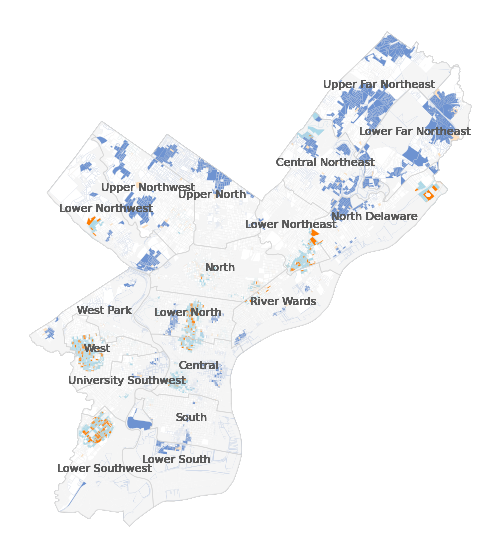

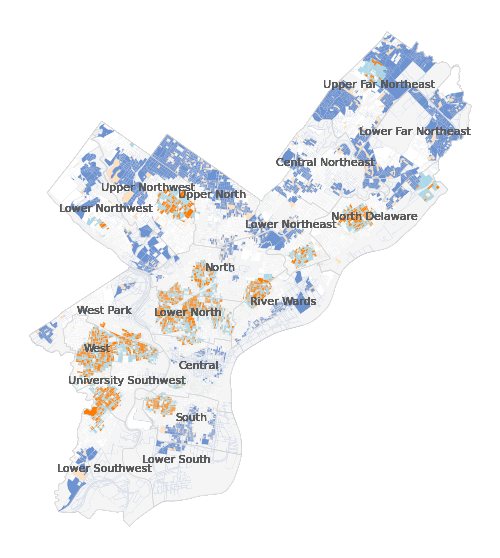

In [114]:
#Institutional Investor Rentals
moran_list = [moran2000_loc_inst_inv_rent,moran2001_loc_inst_inv_rent,moran2002_loc_inst_inv_rent,
             moran2003_loc_inst_inv_rent,moran2004_loc_inst_inv_rent,moran2005_loc_inst_inv_rent,
             moran2006_loc_inst_inv_rent,moran2007_loc_inst_inv_rent,moran2008_loc_inst_inv_rent, moran2009_loc_inst_inv_rent]
files_list = ['inst_inv_rent2000.png','inst_inv_rent2001.png','inst_inv_rent2002.png','inst_inv_rent2003.png',
             'inst_inv_rent2004.png','inst_inv_rent2005.png','inst_inv_rent2006.png','inst_inv_rent2007.png',
             'inst_inv_rent2008.png','inst_inv_rent2009.png']
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']

fig, ax = plt.subplots(figsize=(10,10))
for i, val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds00_10_i, p=0.05, ax=ax, legend=False)
    non_res.plot(ax=ax, edgecolor='none', color='#f5f5f5')
    planning_districts.plot(ax=ax, facecolor='none', edgecolor='#D2D2D2', linewidth=0.5)
    districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], ha='center', 
                                      fontname='Akkurat Pro', fontsize = 11, color = '#5A5A5A'), axis=1);
    plt.savefig('images/Inst_Inv_Rent/'+files_list[i], dpi=300)
    
#Institutional Investor Rentals 2010-2018
moran_list = [moran2010_loc_inst_inv_rent,moran2011_loc_inst_inv_rent,moran2012_loc_inst_inv_rent,
             moran2013_loc_inst_inv_rent,moran2014_loc_inst_inv_rent,moran2015_loc_inst_inv_rent,
             moran2016_loc_inst_inv_rent,moran2017_loc_inst_inv_rent,moran2018_loc_inst_inv_rent]
files_list = ['inst_inv_rent2010.png','inst_inv_rent2011.png','inst_inv_rent2012.png','inst_inv_rent2013.png',
             'inst_inv_rent2014.png','inst_inv_rent2015.png','inst_inv_rent2016.png','inst_inv_rent2017.png',
             'inst_inv_rent2018.png']
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

fig, ax = plt.subplots(figsize=(10,10))
for i, val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds10_18_i, p=0.05, ax=ax, legend=False)
    non_res.plot(ax=ax, edgecolor='none', color='#f5f5f5')
    planning_districts.plot(ax=ax, facecolor='none', edgecolor='#D2D2D2', linewidth=0.5)
    districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], ha='center', 
                                      fontname='Akkurat Pro', fontsize = 11, color = '#5A5A5A'), axis=1);
    plt.savefig('images/Inst_Inv_Rent/'+files_list[i], dpi=300)
    

In [ ]:
#Non-Institutional Investor Rentals
moran_list = [moran2000_loc_non_inst_inv_rent,moran2001_loc_non_inst_inv_rent,moran2002_loc_non_inst_inv_rent,
             moran2003_loc_non_inst_inv_rent,moran2004_loc_non_inst_inv_rent,moran2005_loc_non_inst_inv_rent,
             moran2006_loc_non_inst_inv_rent,moran2007_loc_non_inst_inv_rent,moran2008_loc_non_inst_inv_rent, moran2009_loc_non_inst_inv_rent]
files_list = ['non_inst_inv_rent2000.png','non_inst_inv_rent2001.png','non_inst_inv_rent2002.png','non_inst_inv_rent2003.png',
             'non_inst_inv_rent2004.png','non_inst_inv_rent2005.png','non_inst_inv_rent2006.png','non_inst_inv_rent2007.png',
             'non_inst_inv_rent2008.png','non_inst_inv_rent2009.png']
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']

fig, ax = plt.subplots(figsize=(10,10))
for i, val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds00_10_i, p=0.05, ax=ax, legend=False)
    non_res.plot(ax=ax, edgecolor='none', color='#f5f5f5')
    planning_districts.plot(ax=ax, facecolor='none', edgecolor='#D2D2D2', linewidth=0.5)
    districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], ha='center', 
                                      fontname='Akkurat Pro', fontsize = 11, color = '#5A5A5A'), axis=1);
    plt.savefig('images/Non_Inst_Inv_Rent/'+files_list[i], dpi=300)
    
#Institutional Investor Rentals 2010-2018
moran_list = [moran2010_loc_non_inst_inv_rent,moran2011_loc_non_inst_inv_rent,moran2012_loc_non_inst_inv_rent,
             moran2013_loc_non_inst_inv_rent,moran2014_loc_non_inst_inv_rent,moran2015_loc_non_inst_inv_rent,
             moran2016_loc_non_inst_inv_rent,moran2017_loc_non_inst_inv_rent,moran2018_loc_non_inst_inv_rent]
files_list = ['non_inst_inv_rent2010.png','non_inst_inv_rent2011.png','non_inst_inv_rent2012.png','non_inst_inv_rent2013.png',
             'non_inst_inv_rent2014.png','non_inst_inv_rent2015.png','non_inst_inv_rent2016.png','non_inst_inv_rent2017.png',
             'non_inst_inv_rent2018.png']
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

fig, ax = plt.subplots(figsize=(10,10))
for i, val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds10_18_i, p=0.05, ax=ax, legend=False)
    non_res.plot(ax=ax, edgecolor='none', color='#f5f5f5')
    planning_districts.plot(ax=ax, facecolor='none', edgecolor='#D2D2D2', linewidth=0.5)
    districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], ha='center', 
                                      fontname='Akkurat Pro', fontsize = 11, color = '#5A5A5A'), axis=1);
    plt.savefig('images/Non_Inst_Inv_Rent/'+files_list[i], dpi=300)
    

C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The 's' parameter of annotate

In [ ]:
#Institutional Investor Flips
moran_list = [moran2000_loc_inst_inv_flip,moran2001_loc_inst_inv_flip,moran2002_loc_inst_inv_flip,
             moran2003_loc_inst_inv_flip,moran2004_loc_inst_inv_flip,moran2005_loc_inst_inv_flip,
             moran2006_loc_inst_inv_flip,moran2007_loc_inst_inv_flip,moran2008_loc_inst_inv_flip, moran2009_loc_inst_inv_flip]
files_list = ['inst_inv_flip2000.png','inst_inv_flip2001.png','inst_inv_flip2002.png','inst_inv_flip2003.png',
             'inst_inv_flip2004.png','inst_inv_flip2005.png','inst_inv_flip2006.png','inst_inv_flip2007.png',
             'inst_inv_flip2008.png','inst_inv_flip2009.png']
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']

fig, ax = plt.subplots(figsize=(10,10))
for i, val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds00_10_i, p=0.05, ax=ax, legend=False)
    non_res.plot(ax=ax, edgecolor='none', color='#f5f5f5')
    planning_districts.plot(ax=ax, facecolor='none', edgecolor='#D2D2D2', linewidth=0.5)
    districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], ha='center', 
                                      fontname='Akkurat Pro', fontsize = 11, color = '#5A5A5A'), axis=1);
    plt.savefig('images/Inst_Inv_Flip/'+files_list[i], dpi=300)
    
#Institutional Investor Rentals 2010-2018
moran_list = [moran2010_loc_inst_inv_flip,moran2011_loc_inst_inv_flip,moran2012_loc_inst_inv_flip,
             moran2013_loc_inst_inv_flip,moran2014_loc_inst_inv_flip,moran2015_loc_inst_inv_flip,
             moran2016_loc_inst_inv_flip,moran2017_loc_inst_inv_flip,moran2018_loc_inst_inv_flip]
files_list = ['inst_inv_flip2010.png','inst_inv_flip2011.png','inst_inv_flip2012.png','inst_inv_flip2013.png',
             'inst_inv_flip2014.png','inst_inv_flip2015.png','inst_inv_flip2016.png','inst_inv_flip2017.png',
             'inst_inv_flip2018.png']
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

fig, ax = plt.subplots(figsize=(10,10))
for i, val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds10_18_i, p=0.05, ax=ax, legend=False)
    non_res.plot(ax=ax, edgecolor='none', color='#f5f5f5')
    planning_districts.plot(ax=ax, facecolor='none', edgecolor='#D2D2D2', linewidth=0.5)
    districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], ha='center', 
                                      fontname='Akkurat Pro', fontsize = 11, color = '#5A5A5A'), axis=1);
    plt.savefig('images/Inst_Inv_Flip/'+files_list[i], dpi=300)
    

In [ ]:
#Non-Institutional Investor Flips
moran_list = [moran2000_loc_non_inst_inv_flip,moran2001_loc_non_inst_inv_flip,moran2002_loc_non_inst_inv_flip,
             moran2003_loc_non_inst_inv_flip,moran2004_loc_non_inst_inv_flip,moran2005_loc_non_inst_inv_flip,
             moran2006_loc_non_inst_inv_flip,moran2007_loc_non_inst_inv_flip,moran2008_loc_non_inst_inv_flip, moran2009_loc_non_inst_inv_flip]
files_list = ['non_inst_inv_flip2000.png','non_inst_inv_flip2001.png','non_inst_inv_flip2002.png','non_inst_inv_flip2003.png',
             'non_inst_inv_flip2004.png','non_inst_inv_flip2005.png','non_inst_inv_flip2006.png','non_inst_inv_flip2007.png',
             'non_inst_inv_flip2008.png','non_inst_inv_flip2009.png']
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']

fig, ax = plt.subplots(figsize=(10,10))
for i, val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds00_10_i, p=0.05, ax=ax, legend=False)
    non_res.plot(ax=ax, edgecolor='none', color='#f5f5f5')
    planning_districts.plot(ax=ax, facecolor='none', edgecolor='#D2D2D2', linewidth=0.5)
    districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], ha='center', 
                                      fontname='Akkurat Pro', fontsize = 11, color = '#5A5A5A'), axis=1);
    plt.savefig('images/Non_Inst_Inv_Flip/'+files_list[i], dpi=300)
    
#Institutional Investor Rentals 2010-2018
moran_list = [moran2010_loc_non_inst_inv_flip,moran2011_loc_non_inst_inv_flip,moran2012_loc_non_inst_inv_flip,
             moran2013_loc_non_inst_inv_flip,moran2014_loc_non_inst_inv_flip,moran2015_loc_non_inst_inv_flip,
             moran2016_loc_non_inst_inv_flip,moran2017_loc_non_inst_inv_flip,moran2018_loc_non_inst_inv_flip]
files_list = ['non_inst_inv_flip2010.png','non_inst_inv_flip2011.png','non_inst_inv_flip2012.png','non_inst_inv_flip2013.png',
             'non_inst_inv_flip2014.png','non_inst_inv_flip2015.png','non_inst_inv_flip2016.png','non_inst_inv_flip2017.png',
             'non_inst_inv_flip2018.png']
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

fig, ax = plt.subplots(figsize=(10,10))
for i, val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds10_18_i, p=0.05, ax=ax, legend=False)
    non_res.plot(ax=ax, edgecolor='none', color='#f5f5f5')
    planning_districts.plot(ax=ax, facecolor='none', edgecolor='#D2D2D2', linewidth=0.5)
    districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], ha='center', 
                                      fontname='Akkurat Pro', fontsize = 11, color = '#5A5A5A'), axis=1);
    plt.savefig('images/Non_Inst_Inv_Flip/'+files_list[i], dpi=300)
    

In [ ]:
#Non Investor / Owner-Occ
moran_list = [moran2000_loc_non_inv,moran2001_loc_non_inv,moran2002_loc_non_inv,
             moran2003_loc_non_inv,moran2004_loc_non_inv,moran2005_loc_non_inv,
             moran2006_loc_non_inv,moran2007_loc_non_inv,moran2008_loc_non_inv, moran2009_loc_non_inv]
files_list = ['non_inv2000.png','non_inv2001.png','non_inv2002.png','non_inv2003.png',
             'non_inv2004.png','non_inv2005.png','non_inv2006.png','non_inv2007.png',
             'non_inv2008.png','non_inv2009.png']
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']

fig, ax = plt.subplots(figsize=(10,10))
for i, val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds00_10_i, p=0.05, ax=ax, legend=False)
    non_res.plot(ax=ax, edgecolor='none', color='#f5f5f5')
    planning_districts.plot(ax=ax, facecolor='none', edgecolor='#D2D2D2', linewidth=0.5)
    districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], ha='center', 
                                      fontname='Akkurat Pro', fontsize = 11, color = '#5A5A5A'), axis=1);
    plt.savefig('images/Non_Inv/'+files_list[i], dpi=300)
    
#Institutional Investor Rentals 2010-2018
moran_list = [moran2010_loc_non_inv,moran2011_loc_non_inv,moran2012_loc_non_inv,
             moran2013_loc_non_inv,moran2014_loc_non_inv,moran2015_loc_non_inv,
             moran2016_loc_non_inv,moran2017_loc_non_inv,moran2018_loc_non_inv]
files_list = ['non_inv2010.png','non_inv2011.png','non_inv2012.png','non_inv2013.png',
             'non_inv2014.png','non_inv2015.png','non_inv2016.png','non_inv2017.png',
             'non_inv2018.png']
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

fig, ax = plt.subplots(figsize=(10,10))
for i, val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds10_18_i, p=0.05, ax=ax, legend=False)
    non_res.plot(ax=ax, edgecolor='none', color='#f5f5f5')
    planning_districts.plot(ax=ax, facecolor='none', edgecolor='#D2D2D2', linewidth=0.5)
    districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], ha='center', 
                                      fontname='Akkurat Pro', fontsize = 11, color = '#5A5A5A'), axis=1);
    plt.savefig('images/Non_Inv/'+files_list[i], dpi=300)
    

In [ ]:
#Foreclosures
moran_list = [moran2000_loc_foreclosures,moran2001_loc_foreclosures,moran2002_loc_foreclosures,
             moran2003_loc_foreclosures,moran2004_loc_foreclosures,moran2005_loc_foreclosures,
             moran2006_loc_foreclosures,moran2007_loc_foreclosures,moran2008_loc_foreclosures, moran2009_loc_foreclosures]
files_list = ['foreclosures2000.png','foreclosures2001.png','foreclosures2002.png','foreclosures2003.png',
             'foreclosures2004.png','foreclosures2005.png','foreclosures2006.png','foreclosures2007.png',
             'foreclosures2008.png','foreclosures2009.png']
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']

fig, ax = plt.subplots(figsize=(10,10))
for i, val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds00_10_i, p=0.05, ax=ax, legend=False)
    non_res.plot(ax=ax, edgecolor='none', color='#f5f5f5')
    planning_districts.plot(ax=ax, facecolor='none', edgecolor='#D2D2D2', linewidth=0.5)
    districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], ha='center', 
                                      fontname='Akkurat Pro', fontsize = 11, color = '#5A5A5A'), axis=1);
    plt.savefig('images/Foreclosures/'+files_list[i], dpi=300)
    
#Institutional Investor Rentals 2010-2018
moran_list = [moran2010_loc_foreclosures,moran2011_loc_foreclosures,moran2012_loc_foreclosures,
             moran2013_loc_foreclosures,moran2014_loc_foreclosures,moran2015_loc_foreclosures,
             moran2016_loc_foreclosures,moran2017_loc_foreclosures,moran2018_loc_foreclosures]
files_list = ['foreclosures2010.png','foreclosures2011.png','foreclosures2012.png','foreclosures2013.png',
             'foreclosures2014.png','foreclosures2015.png','foreclosures2016.png','foreclosures2017.png',
             'foreclosures2018.png']
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

fig, ax = plt.subplots(figsize=(10,10))
for i, val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds10_18_i, p=0.05, ax=ax, legend=False)
    non_res.plot(ax=ax, edgecolor='none', color='#f5f5f5')
    planning_districts.plot(ax=ax, facecolor='none', edgecolor='#D2D2D2', linewidth=0.5)
    districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], ha='center', 
                                      fontname='Akkurat Pro', fontsize = 11, color = '#5A5A5A'), axis=1);
    plt.savefig('images/Foreclosures/'+files_list[i], dpi=300)
    

In [ ]:
## method to batch export individual plots Inst_Inv_Rental from 2010-2018

#moran_list = [moran2010_loc, moran2011_loc, moran2012_loc,moran2013_loc, moran2014_loc,moran2015_loc, moran2016_loc,moran2017_loc, moran2018_loc]
#files_list = ['inv2010.png','inv2011.png','inv2012.png','inv2013.png','inv2014.png','inv2015.png','inv2016.png','inv2017.png','inv2018.png']
#years = ['2010','2011','2012','2013','2014','2015','2016','2017','2018']
# moran_list = [ moran2018_loc]
# files_list = ['inv2018.png']
# years = ['2018']

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor,val, grouped_deeds10_18_i, p=0.05,ax=ax,legend=False)
    non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')

#     water.plot(ax=ax, color="#B4B4B4", edgecolor='none', );
#     roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
    #roads_formap.plot(ax=ax, color="#F0F0F0",);
    planning_districts.plot(ax=ax,facecolor='none',edgecolor='#D2D2D2',linewidth=0.5)
    districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0],
                                          ha='center',fontname="Akkurat Pro", fontsize=11,color='#5A5A5A'),axis=1);
#     ax.set_title(years[i])
    #plt.savefig('../05_drawings/02_outputs/complete_drafts/philly_morans/'+files_list[i],dpi=300)

    
moran_list = [moran2000_loc, moran2001_loc, moran2002_loc,moran2003_loc, moran2004_loc,moran2005_loc, moran2006_loc,moran2007_loc, moran2008_loc,moran2009_loc]
files_list = ['inv2000.png','inv2001.png','inv2002.png','inv2003.png','inv2004.png','inv2005.png','inv2006.png','inv2007.png','inv2008.png','inv2009.png']
years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor,val, grouped_deeds00_10_i, p=0.05,ax=ax,legend=False)
    non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')

#     water.plot(ax=ax, color="#B4B4B4", edgecolor='none', );
#     roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
    planning_districts.plot(ax=ax,facecolor='none',edgecolor='#D2D2D2',linewidth=0.5)
    districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0],
                                          ha='center',fontname="Akkurat Pro", fontsize=11,color='#5A5A5A'),axis=1);
#     ax.set_title(years[i])
    plt.savefig('../05_drawings/02_outputs/complete_drafts/philly_morans/'+files_list[i],dpi=300)



In [ ]:
#institutional investor rental histogram
rtt_rentals = rtt_classified.loc[(rtt_classified['classification'] == 'institutional investor rental') & 
                                        (rtt_classified['sort_year_x']<=2018) &
                                        (rtt_classified['sort_year_x']>2000)]
plt.title(label="institutional investor rentals")
plt.hist(rtt_rentals['sort_year_x'], bins = 18)
#plt.savefig("institutional_investor_rentals.png")

In [ ]:
#institutional investor rental histogram
rtt_non_inv_rentals = rtt_classified.loc[(rtt_classified['classification'] == 'non institutional investor rental') & 
                                        (rtt_classified['sort_year_x']<=2018) &
                                        (rtt_classified['sort_year_x']>2000)]
plt.title(label="non institutional investor rentals")
plt.hist(rtt_non_inv_rentals['sort_year_x'], bins = 18)
#plt.savefig("institutional_investor_rentals.png")

In [ ]:
#institutional investor flip histogram
rtt_inv_flips = rtt_classified.loc[(rtt_classified['classification'] == 'institutional investor flip') & 
                                        (rtt_classified['sort_year_x']<=2018) &
                                        (rtt_classified['sort_year_x']>2000)]
plt.title(label="institutional investor flip")
plt.hist(rtt_inv_flips['sort_year_x'], bins = 18)
#plt.savefig("institutional_investor_rentals.png")

In [ ]:
#non institutional investor rental histogram
rtt_non_inv_flips = rtt_classified.loc[(rtt_classified['classification'] == 'non institutional investor flip') & 
                                        (rtt_classified['sort_year_x']<=2018) &
                                        (rtt_classified['sort_year_x']>2000)]
plt.title(label="non institutional investor flip")
plt.hist(rtt_non_inv_flips['sort_year_x'], bins = 18)
#plt.savefig("institutional_investor_rentals.png")

In [ ]:
#non investor  histogram
rtt_non_inv = rtt_classified.loc[(rtt_classified['classification'] == 'non investor') & 
                                        (rtt_classified['sort_year_x']<=2018) &
                                        (rtt_classified['sort_year_x']>2000)]
plt.title(label="non investor/owner occ")
plt.hist(rtt_non_inv['sort_year_x'], bins = 18)
#plt.savefig("institutional_investor_rentals.png")

In [ ]:
#tax based foreclosures histogram
rtt_foreclosures = rtt_foreclosures.loc[(rtt_foreclosures['sort_year']<=2018) &
                                        (rtt_foreclosures['sort_year']>2000)]
plt.title(label="tax foreclosures")
plt.hist(rtt_foreclosures['sort_year'], bins = 18)
#plt.savefig("institutional_investor_rentals.png")

## Exploratory Analysis
- Use this repository which contains deeds from residential properties classified as investor or owner occupant to conduct analysis
- Who are they? 
- EDA on Philadelphia investors
    - How many LLCs are repeat purchasers?
    - How many LLCs with different names share the same address?
- Biggest purchasers
    - What are the geographies of purchases made by the buyers with the most purchases between 2000-2020?
- Research into specific large investors, what are they doing with the properties? (look at lexisnexis through CU libraries for newspaper coverage archives)


In [ ]:
rtt_classified.head()


In [ ]:
rtt_classified.shape[0]

In [34]:
mult_deeds = rtt_classified[rtt_classified['multi_invest'] == 1]

In [35]:
mult_deeds.shape[0]

96216

In [37]:
mult_deeds = gpd.GeoDataFrame(mult_deeds, geometry=gpd.points_from_xy(mult_deeds.lat, mult_deeds.lng))

In [48]:
mult_grantees_count = mult_deeds.groupby('grantees_x_x')['id'].count().sort_values(ascending = False)
mult_grantees_count.crs = 'epsg:4326'
mult_grantors_count = mult_deeds.groupby('grantors_x')['id'].count().sort_values(ascending = False)
mult_grantors_count.crs = 'epsg:4326'

In [46]:
mult_grantees_count.to_csv('mult_grantees_count.csv')

In [ ]:
mult_grantees_count.shape[0]

In [47]:
mult_grantees_count.head(25)

grantees_x_x
DEMARCO DREW                        1027
LUBLIN WILLIAM H; WALSH JAMES        220
FOTIADIS NIKOLAOS; OSEROFF AARON     217
GULLE JEAN PAUL                      203
DEMARCO BLAIR                        174
WALSH JAMES                          161
MAHALLATI JOSEPH                     125
CHANG JOHN                           114
GUZMAN WILLIAM                       110
MERCURY GROUP                        104
CIPRIANO NICK; MCLEAN MICHAEL        100
WALSH CHARLES                        100
ROWELL WILLIAM A                      97
COLQUITT WYATT                        96
LUBLIN WILLIAM; WALSH JAMES           87
COLQUITT CHRISTOPHER J                81
BANK OF AMERICA NA                    79
UMANSKY GARY                          76
SPECTOR MARK                          75
MUSTAFA SALAH                         75
ALLEGHENY WEST FOUNDATION             71
WELLS FARGO BANK NA                   70
COPPOLA JOHN                          67
WILLIAMS JOSEPH                       66
BRE

In [108]:
city_boundaries = gpd.read_file("data/City_Limits.geojson")
city_boundaries.crs = 'epsg:4326'

### Identifying Rentals

In [208]:
#ranking to find most recent deed change (labeled as 1)
rtt_classified['receipt_date'] = pd.to_datetime(rtt_classified['receipt_date'])
rtt_classified['Rank'] = rtt_classified.groupby('street_address_x')['receipt_date'].rank(ascending=False)

In [209]:
#labeling single family rentals based on it being an investor purchase and the most recent
#transaction on the property
rtt_classified['sfr'] = np.where((rtt_classified.inv == 1) & (rtt_classified.Rank == 1.0), 1, 0)

In [215]:
rentals = rtt_classified[rtt_classified['sfr']==1]

In [216]:
rentals.shape[0]

37973

In [218]:
len(pd.unique(rtt_classified['street_address_x']))

283008

In [219]:
rentals_count = rentals.groupby('grantees_x_x')['id'].count().sort_values(ascending = False)

In [221]:
rentals_count.head(25)

grantees_x_x
NEIGHBORHOOD RESTORATIONS LIMITED PARTNE             152
GILLER REALTY LLC                                    141
ZENITH REAL ESTATE INC                               110
WORKFORCE HOMES 3 LP                                 103
AML INVESTMENTS LLC                                   74
CHOICE RENTALS LLC                                    72
DO 2 WIN RE GROUP LLC                                 70
KELLEY INVESTMENT GROUP LP                            67
FUTURE IS NOW LLC                                     67
STEAMBOAT SCM FUND B LLC                              66
PHILADELPHIA LOTUS 01A LLC                            62
BH HOMES LLC                                          60
PHILADELPHIA LOTUS 08 LLC                             60
HDS LLC                                               58
KMC HOLDINGS LLC                                      58
GINARK INVESTMENT AND MANAGEMENT LP                   58
PHILADELPHIA LOTUS 03A LLC                            58
GNR MERAV 2A LLC  

<AxesSubplot:title={'center':'investor_rentals'}>

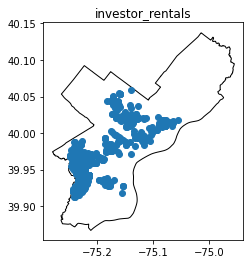

In [225]:
fig, ax = plt.subplots()
ax.set_title('investor_rentals')
city_boundaries.plot(ax = ax, color = "white", edgecolor = "black")
rtt_classified[rtt_classified['grantees_x_x'].str.contains('NEIGHBORHOOD RESTORATIONS LIMITED PARTNE|GILLER REALTY LLC|ZENITH REAL ESTATE INC|WORKFORCE HOMES 3 LP', regex = True) ].plot(ax = ax)

### Exploration of Drew Demarco
- coldwell banker
- has some negative reviews as a landlord https://www.yelp.com/biz/drew-demarco-philadelphia

<AxesSubplot:title={'center':'Drew Demarco'}>

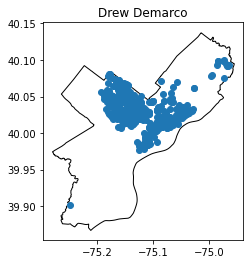

In [134]:
fig, ax = plt.subplots()
ax.set_title('Drew Demarco')
city_boundaries.plot(ax = ax, color = "white", edgecolor = "black")
rtt_classified[rtt_classified['grantees_x_x'] == 'DEMARCO DREW'].plot(ax = ax)

In [136]:
rtt_classified[rtt_classified['grantees_x_x'].str.contains('DEMARCO DREW|DREW DEMARCO', regex = True)].sort_values(by=['document_date'], ascending = False).head(10)

,id,C_DIG1,C_DIG1DESC,C_DIG2,C_DIG2DESC,C_DIG3,C_DIG3DESC,OBJECTID,Shape__Are,Shape__Len,VACBLDG,YEAR,address_high,address_low,address_low_frac,address_low_suffix,adjusted_assessed_value,adjusted_cash_consideration,adjusted_fair_market_value,adjusted_local_tax_amount,adjusted_other_consideration,adjusted_state_tax_amount,adjusted_total_consideration,assessed_value,cash_consideration,common_level_ratio,condo_name,discrepancy,display_date_x,display_date_y,document_date,document_id,document_type,elapsed,elapsed_days,fair_market_value,grantees_x_x,grantees_x_y,grantees_y,grantors_x,grantors_y,index_right,inv,investor_all,lat,legal_remarks,lng,local_tax_amount,local_tax_percent,matched_regmap,multi_invest,objectid,occ,opa_account_num,other_consideration,owner_occup,property_count,receipt_date,receipt_num,recording_date,reg_map_id,sort_year_x,sort_year_y,state_tax_amount,state_tax_percent,street_address_x,street_address_y,street_name,street_postdir,street_predir,street_suffix,total_consideration,unit_num,ward,zip_code,geometry
254815,254815,1,Residential,12,Residential Medium,121,Residential Rowhouse,457656,2696.655029,263.400709,Fully Vacant,2013,NaN,3029.0,None,None,167900.0,78500.0,167900.00,2355.0,NaN,785.0,78500.0,167900.0,78500.0,NaN,None,no,2014-07-09T00:00:00,2014-07-09,2014-07-09T00:00:00,52808960,DEED,50,50.0,167900.00,DEMARCO DREW,DEMARCO DREW,False,MACMILLAN CALVIN ESTATE OF; MULHOLLAND DIANE,MACMILLAN CALVIN ESTATE OF; MULHOLLAND DIANE,458655,0,1.0,-75.053302,None,40.037706,2355.0,100.0,079N060417,1.0,10004593,1,551339200.0,0.0,0,1.0,2014-07-24T00:00:00,None,2014-07-24T00:00:00,079N060417,2014,2014.0,785.0,100.0,3029 TYSON AVE,3029 TYSON AVE,TYSON,None,None,AVE,78500.0,None,55.0,19149.0,POINT (-75.05330 40.03771)
250193,250193,1,Residential,12,Residential Medium,121,Residential Rowhouse,555325,1671.455505,224.082463,None,2016,NaN,12630.0,None,None,162600.0,125000.0,162600.00,3750.0,NaN,1250.0,125000.0,162600.0,125000.0,NaN,None,no,2014-05-20T00:00:00,2014-05-20,2014-05-20T00:00:00,52788837,DEED,1289,1289.0,162600.00,DEMARCO DREW,DEMARCO DREW,False,LEITER DOROTHY ESTATE OF; LEITER WILLIAM,LEITER DOROTHY ESTATE OF; LEITER WILLIAM,555324,0,1.0,-74.966027,None,40.093363,3750.0,100.0,157N230093,1.0,9980346,1,663415800.0,NaN,0,1.0,2014-06-04T00:00:00,None,2014-06-04T00:00:00,157N230093,2014,2014.0,1250.0,100.0,12630 BISCAYNE DR,12630 BISCAYNE DR,BISCAYNE,None,None,DR,125000.0,None,66.0,19154.0,POINT (-74.96603 40.09336)
187240,187240,1,Residential,12,Residential Medium,121,Residential Rowhouse,383958,1712.022583,259.873448,None,2015,NaN,5219.0,None,None,10848.0,23500.0,33954.24,705.0,NaN,235.0,23500.0,10848.0,23500.0,NaN,None,no,2010-11-08T00:00:00,2010-11-08,2010-11-08T00:00:00,52293578,DEED,111,111.0,33954.24,DEMARCO DREW,DEMARCO DREW,False,BAC GP LLC; INTEGRATED ASSET SERVICES LLC; U S...,BAC GP LLC; INTEGRATED ASSET SERVICES LLC; U S...,382957,0,1.0,-75.133401,None,40.031006,705.0,100.0,123N160078,1.0,9374315,1,492106300.0,NaN,0,1.0,2010-12-15T00:00:00,None,2010-12-15T00:00:00,123N160078,2010,2010.0,235.0,100.0,5219 N 6TH ST,5219 N 6TH ST,6TH,None,N,ST,23500.0,None,49.0,19120.0,POINT (-75.13340 40.03101)
186352,186352,1,Residential,12,Residential Medium,121,Residential Rowhouse,398397,1632.529663,243.943736,None,2016,NaN,5744.0,None,None,NaN,20000.0,43469.44,600.0,NaN,200.0,20000.0,NaN,20000.0,NaN,None,no,2010-07-20T00:00:00,2010-07-20,2010-07-20T00:00:00,52291875,DEED,0,0.0,43469.44,DEMARCO DREW,DEMARCO DREW,False,JAMES BLANCHE; JAMES SONJA RENEE,JAMES BLANCHE; JAMES SONJA RENEE,397396,0,1.0,-75.147548,None,40.041474,600.0,100.0,135N030192,1.0,9372125,1,172142100.0,0.0,0,1.0,2010-12-10T00:00:00,None,2010-12-10T00:00:00,135N030192,2010,2010.0,200.0,100.0,5744 N 16TH ST,5744 N 16TH ST,16TH,None,N,ST,20000.0,None,17.0,19141.0,POINT (-75.14755 40.04147)
186329,186329,1,Residential,12,Residential Medium,121,Residential Rowhouse,362372,1147.215698,190.106764,None,2016,NaN,6323.0,None,None,NaN,16500.0,25741.12,495.0,NaN,165.0,1

In [138]:
drew_demarco = rtt_classified[rtt_classified['street_address_x'] == '3029 TYSON AVE'].sort_values(by=['document_date'], ascending = False)
drew_demarco[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'document_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,document_date
289090,177500.0,WANG FU LONG; WANG JIA CI,DEMARCO DREW,3029 TYSON AVE,2016-01-15T00:00:00
254815,78500.0,DEMARCO DREW,MACMILLAN CALVIN ESTATE OF; MULHOLLAND DIANE,3029 TYSON AVE,2014-07-09T00:00:00


In [139]:
drew_demarco = rtt_classified[rtt_classified['street_address_x'] == '12630 BISCAYNE DR'].sort_values(by=['document_date'], ascending = False)
drew_demarco[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'document_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,document_date
294396,193000.0,LYDON NICOLE; RITZHEIMER DANIEL P,DEMARCO DREW,12630 BISCAYNE DR,2016-03-24T00:00:00
250193,125000.0,DEMARCO DREW,LEITER DOROTHY ESTATE OF; LEITER WILLIAM,12630 BISCAYNE DR,2014-05-20T00:00:00


In [140]:
drew_demarco = rtt_classified[rtt_classified['street_address_x'] == '5219 N 6TH ST'].sort_values(by=['document_date'], ascending = False)
drew_demarco[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'document_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,document_date
187240,23500.0,DEMARCO DREW,BAC GP LLC; INTEGRATED ASSET SERVICES LLC; U S...,5219 N 6TH ST,2010-11-08T00:00:00
106211,95000.0,FOXWORTH VINCENT,CHAMBERS LINDA,5219 N 6TH ST,2007-04-11T00:00:00


In [141]:
drew_demarco = rtt_classified[rtt_classified['street_address_x'] == '5744 N 16TH ST'].sort_values(by=['document_date'], ascending = False)
drew_demarco[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'document_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,document_date
186352,20000.0,DEMARCO DREW,JAMES BLANCHE; JAMES SONJA RENEE,5744 N 16TH ST,2010-07-20T00:00:00


In [142]:
drew_demarco = rtt_classified[rtt_classified['street_address_x'] == '6323 N NORWOOD ST'].sort_values(by=['document_date'], ascending = False)
drew_demarco[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'document_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,document_date
186329,16500.0,DEMARCO DREW,CLEMENS SAFIYAH,6323 N NORWOOD ST,2010-07-20T00:00:00


**Exploration of William Lubin / James Walsh**
- century 21
- has a rental company - https://www.lublinpropertymanagement.com/availability
- found through ppp loan application

<AxesSubplot:title={'center':'William Lublin | James Walsh'}>

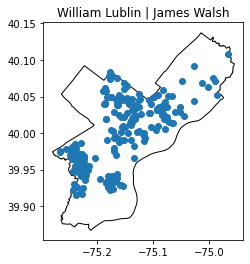

In [143]:
fig, ax = plt.subplots()
ax.set_title('William Lublin | James Walsh')
city_boundaries.plot(ax = ax, color = "white", edgecolor = "black")
rtt_classified[rtt_classified['grantees_x_x'] == 'LUBLIN WILLIAM H; WALSH JAMES'].plot(ax = ax)

In [149]:
rtt_classified[rtt_classified['grantees_x_x'].str.contains('WILLIAM LUBLIN|LUBLIN WILLIAM', regex = True)].sort_values(by=['document_date'], ascending = False)

,id,C_DIG1,C_DIG1DESC,C_DIG2,C_DIG2DESC,C_DIG3,C_DIG3DESC,OBJECTID,Shape__Are,Shape__Len,VACBLDG,YEAR,address_high,address_low,address_low_frac,address_low_suffix,adjusted_assessed_value,adjusted_cash_consideration,adjusted_fair_market_value,adjusted_local_tax_amount,adjusted_other_consideration,adjusted_state_tax_amount,adjusted_total_consideration,assessed_value,cash_consideration,common_level_ratio,condo_name,discrepancy,display_date_x,display_date_y,document_date,document_id,document_type,elapsed,elapsed_days,fair_market_value,grantees_x_x,grantees_x_y,grantees_y,grantors_x,grantors_y,index_right,inv,investor_all,lat,legal_remarks,lng,local_tax_amount,local_tax_percent,matched_regmap,multi_invest,objectid,occ,opa_account_num,other_consideration,owner_occup,property_count,receipt_date,receipt_num,recording_date,reg_map_id,sort_year_x,sort_year_y,state_tax_amount,state_tax_percent,street_address_x,street_address_y,street_name,street_postdir,street_predir,street_suffix,total_consideration,unit_num,ward,zip_code,geometry
492603,492603,1,Residential,11,Residential Low,112,Residential SemiDetached,108660,1699.344971,218.363629,None,2017,NaN,5222.0,None,None,153100.0,1.0,162286.00,2659.87,NaN,811.43,1.0,153100.0,1.0,1.06,None,no,2021-02-19T00:00:00,2021-02-19,2021-02-19T00:00:00,53799674,DEED,2,2.0,162286.00,LUBLIN WILLIAM H; WALSH JAMES,LUBLIN WILLIAM H; WALSH JAMES,False,WALSH JAMES,WALSH JAMES,107659,0,1.0,-75.228468,None,39.948224,2659.87,50.0,022S240094,1.0,12029888,1,462118500.0,0.0,0,1.0,2021-03-05T00:00:00,21-22087,2021-03-05T00:00:00,None,2021,2021.0,811.43,50.0,5222 WEBSTER ST,5222 WEBSTER ST,WEBSTER,None,None,ST,1.0,None,46.0,19143.0,POINT (-75.22847 39.94822)
492604,492604,1,Residential,12,Residential Medium,121,Residential Rowhouse,16096,1149.715149,173.863153,None,2015,NaN,2540.0,None,None,71000.0,1.0,75260.00,1233.51,NaN,376.30,1.0,71000.0,1.0,1.06,None,no,2021-02-17T00:00:00,2021-02-17,2021-02-17T00:00:00,53799681,DEED,0,0.0,75260.00,LUBLIN WILLIAM H; WALSH JAMES,LUBLIN WILLIAM H; WALSH JAMES,False,WALSH JAMES,WALSH JAMES,17095,0,1.0,-75.224147,None,39.925183,1233.51,50.0,038S230161,1.0,12029894,1,402065200.0,0.0,0,1.0,2021-03-05T00:00:00,21-22094,2021-03-05T00:00:00,None,2021,2021.0,376.30,50.0,2540 S 61ST ST,2540 S 61ST ST,61ST,None,S,ST,1.0,None,40.0,19142.0,POINT (-75.22415 39.92518)
492301,492301,1,Residential,12,Residential Medium,121,Residential Rowhouse,80669,1146.752930,183.309905,None,2014,NaN,627.0,None,None,267400.0,1.0,283444.00,4645.65,NaN,1417.22,1.0,267400.0,1.0,1.06,None,no,2021-02-17T00:00:00,2021-02-17,2021-02-17T00:00:00,53799858,DEED,553,553.0,283444.00,LUBLIN WILLIAM H; WALSH JAMES,LUBLIN WILLIAM H; WALSH JAMES,False,WALSH JAMES,WALSH JAMES,80668,0,1.0,-75.156329,None,39.929080,4645.65,50.0,011S110296,1.0,12030070,1,12054400.0,0.0,0,1.0,2021-03-05T00:00:00,21-22245,2021-03-05T00:00:00,None,2021,2021.0,1417.22,50.0,627 TASKER ST,627 TASKER ST,TASKER,None,None,ST,1.0,None,1.0,19148.0,POINT (-75.15633 39.92908)
492496,492496,1,Residential,12,Residential Medium,121,Residential Rowhouse,380074,1452.941040,215.848480,None,2016,NaN,5705.0,None,None,99400.0,1.0,105364.00,1726.92,NaN,526.82,1.0,99400.0,1.0,1.06,None,no,2021-02-17T00:00:00,2021-02-17,2021-02-17T00:00:00,53799898,DEED,0,0.0,105364.00,LUBLIN WILLIAM H; WALSH JAMES,LUBLIN WILLIAM H; WALSH JAMES,False,WALSH JAMES,WALSH JAMES,380073,0,1.0,-75.132687,None,40.038531,1726.92,50.0,135N080203,1.0,12030110,1,612262300.0,0.0,0,1.0,2021-03-05T00:00:00,21-22284,2021-03-05T00:00:00,None,2021,2021.0,526.82,50.0,5705 N MARSHALL ST,5705 N MARSHALL ST,MARSHALL,None,N,ST,1.0,None,61.0,19120.0,POINT (-75.13269 40.03853)
459370,459370,1,Residential,12,Residential Medium,121,Residential Rowhouse,414557,1520.910583,231.322193,None,2016,NaN,6905.0,None,None,115000.0,1.0,116150.00,1903.70,NaN,580.75,1.0,115000.0,1.0,1.01,None,no,2019-08-14T00:00:00,2019-08-14,2019-08-14T00:00:00,53553270,DEED,223,223.0,116150.00,LUBLIN WILLIAM H; WALSH JAMES,LUBLIN WILLIAM H; W

In [150]:
william_lublin = rtt_classified[rtt_classified['street_address_x'] == '5222 WEBSTER ST'].sort_values(by=['document_date'], ascending = False)
william_lublin[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'document_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,document_date
492603,1.0,LUBLIN WILLIAM H; WALSH JAMES,WALSH JAMES,5222 WEBSTER ST,2021-02-19T00:00:00
413237,1.0,HOMECOMINGS FINANCIAL NETWORK INC,FAIRBANKS CAPITAL CORP,5222 WEBSTER ST,2003-08-21T00:00:00
413238,24000.0,WALSH JAMES,HOMECOMINGS FINANCIAL NETWORK INC,5222 WEBSTER ST,2003-08-21T00:00:00


In [151]:
william_lublin = rtt_classified[rtt_classified['street_address_x'] == '2540 S 61ST ST'].sort_values(by=['document_date'], ascending = False)
william_lublin[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'document_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,document_date
492604,1.0,LUBLIN WILLIAM H; WALSH JAMES,WALSH JAMES,2540 S 61ST ST,2021-02-17T00:00:00
437948,24000.0,WALSH JAMES,CHASE MANHATTAN BANK TR; IMC HOME EQUITY LOAN ...,2540 S 61ST ST,2004-03-01T00:00:00


In [152]:
william_lublin = rtt_classified[rtt_classified['street_address_x'] == '968 E WOODLAWN ST'].sort_values(by=['document_date'], ascending = False)
william_lublin[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'document_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,document_date
30144,27500.0,LUBLIN WILLIAM H; WALSH JAMES,JP MORGAN CHASE BANK TR,968 E WOODLAWN ST,None


In [156]:
william_lublin = rtt_classified[rtt_classified['street_address_x'] == '2139 S 15TH ST'].sort_values(by=['document_date'], ascending = False)
william_lublin[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
381582,18350.0,LUBLIN WILLIAM H; WALSH JAMES,TIGER RELOCATION COMPANY,2139 S 15TH ST,2002-09-19T00:00:00


In [157]:
william_lublin = rtt_classified[rtt_classified['street_address_x'] == '5717 N PARK AVE'].sort_values(by=['document_date'], ascending = False)
william_lublin[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
406498,34964.0,LUBLIN WILLIAM H; WALSH JAMES,TIGER RELOCATION COMPANY,5717 N PARK AVE,2003-07-03T00:00:00


In [158]:
william_lublin = rtt_classified[rtt_classified['street_address_x'] == '46 W ROCKLAND ST'].sort_values(by=['document_date'], ascending = False)
william_lublin[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
409558,40000.0,LUBLIN WILLIAM; WALSH JAMES,CITIBANK N A,46 W ROCKLAND ST,2003-06-26T00:00:00


In [176]:
william_lublin = rtt_classified[rtt_classified['street_address_x'] == '1220 W SERGEANT ST'].sort_values(by=['document_date'], ascending = False)
william_lublin[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
381955,7756.0,LUBLIN WILLIAM H; WALSH JAMES,TIGER RELOCATION COMPANY,1220 W SERGEANT ST,2002-09-19T00:00:00


**Exploration of FOTIADIS NIKOLAOS; OSEROFF AARON**
- Philly 1st Real Estate
- appears to be more of a house flipper 

<AxesSubplot:title={'center':'Nikolaos Fotiadis | Aaron Oseroff'}>

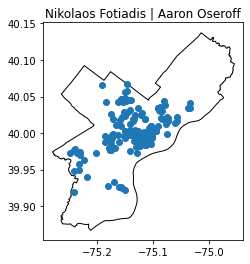

In [159]:
fig, ax = plt.subplots()
ax.set_title('Nikolaos Fotiadis | Aaron Oseroff')
city_boundaries.plot(ax = ax, color = "white", edgecolor = "black")
rtt_classified[rtt_classified['grantees_x_x'] == 'FOTIADIS NIKOLAOS; OSEROFF AARON'].plot(ax = ax)

In [160]:
rtt_classified[rtt_classified['grantees_x_x'].str.contains('NIKOLAOS FOTIADIS|FOTIADIS NIKOLAOS', regex = True)].sort_values(by=['document_date'], ascending = False)

,id,C_DIG1,C_DIG1DESC,C_DIG2,C_DIG2DESC,C_DIG3,C_DIG3DESC,OBJECTID,Shape__Are,Shape__Len,VACBLDG,YEAR,address_high,address_low,address_low_frac,address_low_suffix,adjusted_assessed_value,adjusted_cash_consideration,adjusted_fair_market_value,adjusted_local_tax_amount,adjusted_other_consideration,adjusted_state_tax_amount,adjusted_total_consideration,assessed_value,cash_consideration,common_level_ratio,condo_name,discrepancy,display_date_x,display_date_y,document_date,document_id,document_type,elapsed,elapsed_days,fair_market_value,grantees_x_x,grantees_x_y,grantees_y,grantors_x,grantors_y,index_right,inv,investor_all,lat,legal_remarks,lng,local_tax_amount,local_tax_percent,matched_regmap,multi_invest,objectid,occ,opa_account_num,other_consideration,owner_occup,property_count,receipt_date,receipt_num,recording_date,reg_map_id,sort_year_x,sort_year_y,state_tax_amount,state_tax_percent,street_address_x,street_address_y,street_name,street_postdir,street_predir,street_suffix,total_consideration,unit_num,ward,zip_code,geometry
499915,499915,1,Residential,12,Residential Medium,121,Residential Rowhouse,451210,1081.605103,171.894343,None,2012,NaN,1729.0,None,None,72800.0,55000.0,77168.00,1802.9,NaN,550.0,55000.0,72800.0,55000.0,1.06,None,no,2020-10-30T00:00:00,2020-10-30,2020-10-30T00:00:00,53747173,DEED,0,0.0,77168.00,FOTIADIS NIKOLAOS; IKHIZGILOV TIMUR,FOTIADIS NIKOLAOS; IKHIZGILOV TIMUR,False,THOMPSON ELIZABETH M; THOMPSON SEAN F,THOMPSON ELIZABETH M; THOMPSON SEAN F,451209,0,1.0,-75.074176,None,40.020886,1802.9,100.0,113N020016,1.0,11933357,1,622112800.0,0.0,0,1.0,2020-11-10T00:00:00,20-108287,2020-11-10T00:00:00,None,2020,2020.0,550.0,100.0,1729 BRIDGE ST,1729 BRIDGE ST,BRIDGE,None,None,ST,55000.0,None,62.0,19124.0,POINT (-75.07418 40.02089)
494793,494793,1,Residential,12,Residential Medium,121,Residential Rowhouse,451210,1081.605103,171.894343,None,2012,NaN,1729.0,None,None,72800.0,55000.0,77168.00,1802.9,NaN,550.0,55000.0,72800.0,55000.0,1.06,None,no,2020-10-30T00:00:00,2020-10-30,2020-10-30T00:00:00,53747173,DEED,365,365.0,77168.00,FOTIADIS NIKOLAOS; IKHIZGILOV TIMUR,FOTIADIS NIKOLAOS; IKHIZGILOV TIMUR,False,THOMPSON ELIZABETH M; THOMPSON SEAN F,THOMPSON ELIZABETH M; THOMPSON SEAN F,451209,0,1.0,-75.074176,None,40.020886,1802.9,100.0,113N020016,1.0,11973214,1,622112800.0,0.0,0,1.0,2020-11-10T00:00:00,20-108287,2020-11-10T00:00:00,None,2020,2020.0,550.0,100.0,1729 BRIDGE ST,1729 BRIDGE ST,BRIDGE,None,None,ST,55000.0,None,62.0,19124.0,POINT (-75.07418 40.02089)
494014,494014,1,Residential,12,Residential Medium,124,Residential Rowhouse Converted to Apts LT 3st ...,455539,1367.489990,212.452661,None,2013,NaN,6352.0,None,None,107100.0,105000.0,113526.00,3441.9,NaN,1050.0,105000.0,107100.0,105000.0,1.06,None,no,2020-10-08T00:00:00,2020-10-08,2020-10-08T00:00:00,53744034,DEED,0,0.0,113526.00,FOTIADIS NIKOLAOS,FOTIADIS NIKOLAOS,False,MCCOMB CAROL M; MCCOMB MATTHEW J,MCCOMB CAROL M; MCCOMB MATTHEW J,454538,0,1.0,-75.051147,None,40.019883,3441.9,100.0,111N150449,1.0,11969766,1,411395600.0,0.0,0,1.0,2020-11-04T00:00:00,20-105878,2020-11-04T00:00:00,None,2020,2020.0,1050.0,100.0,6352 EDMUND ST,6352 EDMUND ST,EDMUND,None,None,ST,105000.0,None,41.0,19135.0,POINT (-75.05115 40.01988)
488111,488111,1,Residential,12,Residential Medium,124,Residential Rowhouse Converted to Apts LT 3st ...,455539,1367.489990,212.452661,None,2013,NaN,6352.0,None,None,107100.0,105000.0,113526.00,3441.9,NaN,1050.0,105000.0,107100.0,105000.0,1.06,None,no,2020-10-08T00:00:00,2020-10-08,2020-10-08T00:00:00,53744034,DEED,0,0.0,113526.00,FOTIADIS NIKOLAOS,FOTIADIS NIKOLAOS,False,MCCOMB CAROL M; MCCOMB MATTHEW J,MCCOMB CAROL M; MCCOMB MATTHEW J,454538,0,1.0,-75.051147,None,40.019883,3441.9,100.0,111N150449,1.0,11965449,1,411395600.0,0.0,0,1.0,2020-11-04T00:00:00,20-105878,2020-11-04T00:00:00,None,2020,2020.0,1050.0,100.0,6352 EDMUND ST,6352 EDMUND ST,EDMUND,None,None,ST,105000.0,None,41.0,19135.0,POINT (-75.05115 40.01988)
484437,484437,1,Residential,12,Residential Medium

In [161]:
nikolaos_fotiadis = rtt_classified[rtt_classified['street_address_x'] == '1729 BRIDGE ST'].sort_values(by=['document_date'], ascending = False)
nikolaos_fotiadis[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
494793,55000.0,FOTIADIS NIKOLAOS; IKHIZGILOV TIMUR,THOMPSON ELIZABETH M; THOMPSON SEAN F,1729 BRIDGE ST,2020-11-10T00:00:00
499915,55000.0,FOTIADIS NIKOLAOS; IKHIZGILOV TIMUR,THOMPSON ELIZABETH M; THOMPSON SEAN F,1729 BRIDGE ST,2020-11-10T00:00:00
395240,1.0,THOMPSON ELIZABETH M; THOMPSON SEAN F,HOMESOURCE RECOVERY SYSTEMS INC,1729 BRIDGE ST,2003-01-10T00:00:00
365475,17500.0,HOMESOURCE RECOVERY SYSTEMS INC,SEARNOCK LORETTA J,1729 BRIDGE ST,2001-12-07T00:00:00


In [162]:
nikolaos_fotiadis = rtt_classified[rtt_classified['street_address_x'] == '6352 EDMUND ST'].sort_values(by=['document_date'], ascending = False)
nikolaos_fotiadis[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
497027,165000.0,BOOTH STEPHANIE,FOTIADIS NIKOLAOS,6352 EDMUND ST,2021-01-11T00:00:00
484437,105000.0,FOTIADIS NIKOLAOS,MCCOMB CAROL M; MCCOMB MATTHEW J,6352 EDMUND ST,2020-11-04T00:00:00
488111,105000.0,FOTIADIS NIKOLAOS,MCCOMB CAROL M; MCCOMB MATTHEW J,6352 EDMUND ST,2020-11-04T00:00:00
494014,105000.0,FOTIADIS NIKOLAOS,MCCOMB CAROL M; MCCOMB MATTHEW J,6352 EDMUND ST,2020-11-04T00:00:00


In [163]:
nikolaos_fotiadis = rtt_classified[rtt_classified['street_address_x'] == '732 E WILLARD ST'].sort_values(by=['document_date'], ascending = False)
nikolaos_fotiadis[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
201217,20500.0,CAO YIQING,HIADEB MANAGEMENT LLC,732 E WILLARD ST,2011-11-03T00:00:00
184233,17500.0,HIADEB MANAGEMENT LLC,DEUTSCHE BANK NATIONAL TRUST COMPANY TR,732 E WILLARD ST,2010-09-09T00:00:00
34506,54000.0,IOURTCHEVSKI SERGUEI,ANTONYUK MICHAEL; STANKEVICIENE RENATA,732 E WILLARD ST,2005-06-01T00:00:00
27990,20000.0,STANKEVICIENE RENATA,EQUITY ONE INCORPORATED,732 E WILLARD ST,2005-03-30T00:00:00
427438,9500.0,MALOZOVSKY ANATOLE,FOTIADIS NIKOLAOS; OSEROFF AARON,732 E WILLARD ST,2000-05-12T00:00:00
403431,5000.0,FOTIADIS NIKOLAOS; OSEROFF AARON,FEDERAL HOME LOAN MORTGAGE CORPORATIKO; FIRST ...,732 E WILLARD ST,2000-04-12T00:00:00


In [164]:
nikolaos_fotiadis = rtt_classified[rtt_classified['street_address_x'] == '3437 A ST'].sort_values(by=['document_date'], ascending = False)
nikolaos_fotiadis[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
413939,13000.0,SERRANO MARTA,FOTIADIS NIKOLAOS; OSEROFF AARON,3437 A ST,2000-05-05T00:00:00
398962,8000.0,FOTIADIS NIKOLAOS; OSEROFF AARON,BATZIG EDWARD R; BATZIG JANET,3437 A ST,2000-04-05T00:00:00


In [165]:
nikolaos_fotiadis = rtt_classified[rtt_classified['street_address_x'] == '2655 TULIP ST'].sort_values(by=['document_date'], ascending = False)
nikolaos_fotiadis[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
490425,264959.0,NACCI BRIAN; NACCI SHIRLEY,BELL JUSTIN A; OCHAL STEPHANIE,2655 TULIP ST,2020-12-03T00:00:00
498608,264959.0,NACCI BRIAN; NACCI SHIRLEY,BELL JUSTIN A; OCHAL STEPHANIE,2655 TULIP ST,2020-12-03T00:00:00
239217,154000.0,OCHAL STEPHANIE,CASSIDY MANUS; NETTERVILLE BRIAN,2655 TULIP ST,2013-09-18T00:00:00
87774,94340.0,CASSIDY MANUS; NETTERVILLE BRIAN,VELEZ ISABEL,2655 TULIP ST,2006-10-16T00:00:00
12291,29900.0,VELEZ ISABEL,FOTIADIS NIKOLAOS,2655 TULIP ST,2000-06-23T00:00:00
371075,9000.0,FOTIADIS NIKOLAOS,FIRST UNION NATIONAL BANK,2655 TULIP ST,2000-03-03T00:00:00


**Exploration of GULLE JEAN PAUL**
- seems to have a connection to homes 4 all, which is connected to 
- appears to be an institutional renter
- shares building with RE/MAX

In [166]:
rtt_classified[rtt_classified['grantees_x_x'].str.contains('GULLE JEAN PAUL|JEAN PAUL GULLE', regex = True)].sort_values(by=['document_date'], ascending = False)

,id,C_DIG1,C_DIG1DESC,C_DIG2,C_DIG2DESC,C_DIG3,C_DIG3DESC,OBJECTID,Shape__Are,Shape__Len,VACBLDG,YEAR,address_high,address_low,address_low_frac,address_low_suffix,adjusted_assessed_value,adjusted_cash_consideration,adjusted_fair_market_value,adjusted_local_tax_amount,adjusted_other_consideration,adjusted_state_tax_amount,adjusted_total_consideration,assessed_value,cash_consideration,common_level_ratio,condo_name,discrepancy,display_date_x,display_date_y,document_date,document_id,document_type,elapsed,elapsed_days,fair_market_value,grantees_x_x,grantees_x_y,grantees_y,grantors_x,grantors_y,index_right,inv,investor_all,lat,legal_remarks,lng,local_tax_amount,local_tax_percent,matched_regmap,multi_invest,objectid,occ,opa_account_num,other_consideration,owner_occup,property_count,receipt_date,receipt_num,recording_date,reg_map_id,sort_year_x,sort_year_y,state_tax_amount,state_tax_percent,street_address_x,street_address_y,street_name,street_postdir,street_predir,street_suffix,total_consideration,unit_num,ward,zip_code,geometry
487557,487557,1,Residential,12,Residential Medium,121,Residential Rowhouse,317743,695.698303,128.300515,None,2014,NaN,3520.0,None,None,NaN,40000.0,NaN,1311.20,NaN,400.0,40000.0,0.0,40000.0,1.06,None,no,2020-08-27T00:00:00,2020-08-27,2020-08-27T00:00:00,53715078,DEED,101,101.0,0.00,GULLE JEAN PAUL,GULLE JEAN PAUL,False,DIAZ LOUIS F,DIAZ LOUIS F,316742,0,1.0,-75.103276,None,39.997640,1311.20,100.0,026N200143,1.0,11899314,1,452300800.0,0.0,0,1.0,2020-09-10T00:00:00,20-83226,2020-09-10T00:00:00,None,2020,2020.0,400.0,100.0,3520 JOYCE ST,3520 JOYCE ST,JOYCE,None,None,ST,40000.0,None,45.0,19134.0,POINT (-75.10328 39.99764)
482321,482321,1,Residential,12,Residential Medium,121,Residential Rowhouse,446866,737.276611,139.188944,None,2012,NaN,5348.0,None,None,NaN,57500.0,NaN,1884.85,NaN,575.0,57500.0,0.0,57500.0,1.01,None,no,2020-05-18T00:00:00,2020-05-18,2020-05-18T00:00:00,53673802,DEED,7,7.0,0.00,GULLE JEAN PAUL,GULLE JEAN PAUL,False,KNAPPE STILLA,KNAPPE STILLA,446865,0,1.0,-75.075066,None,40.023220,1884.85,100.0,113N040080,1.0,11853561,1,622224700.0,0.0,0,1.0,2020-06-03T00:00:00,20-51375,2020-06-03T00:00:00,None,2020,2020.0,575.0,100.0,5348 DARRAH ST,5348 DARRAH ST,DARRAH,None,None,ST,57500.0,None,62.0,NaN,POINT (-75.07507 40.02322)
482320,482320,1,Residential,12,Residential Medium,121,Residential Rowhouse,427444,801.537903,142.663177,None,2012,NaN,1924.0,None,None,NaN,38000.0,NaN,1245.64,NaN,380.0,38000.0,0.0,38000.0,1.01,None,no,2020-05-11T00:00:00,2020-05-11,2020-05-11T00:00:00,53673796,DEED,628,628.0,0.00,GULLE JEAN PAUL,GULLE JEAN PAUL,False,ATADGY DAVID,ATADGY DAVID,427443,0,1.0,-75.086160,None,40.007877,1245.64,100.0,083N070233,1.0,11853554,1,232019200.0,0.0,0,1.0,2020-06-03T00:00:00,20-51372,2020-06-03T00:00:00,None,2020,2020.0,380.0,100.0,1924 BRIGGS ST,1924 BRIGGS ST,BRIGGS,None,None,ST,38000.0,None,23.0,NaN,POINT (-75.08616 40.00788)
361060,361060,1,Residential,12,Residential Medium,121,Residential Rowhouse,385069,1468.745789,214.366632,None,2015,NaN,5620.0,None,None,89800.0,75000.0,90698.00,2458.50,NaN,750.0,75000.0,89800.0,75000.0,1.01,None,no,2018-08-22T00:00:00,2018-08-22,2018-08-22T00:00:00,53412118,DEED,281,281.0,90698.00,GULLE JEAN PAUL,GULLE JEAN PAUL,False,NELSON WILLIE,NELSON WILLIE,383068,0,1.0,-75.139615,None,40.038532,2458.50,100.0,141N060182,1.0,10744751,1,493073600.0,0.0,0,1.0,2018-09-04T00:00:00,18-87552,2018-09-04T00:00:00,141N060182,2018,2018.0,750.0,100.0,5620 N 11TH ST,5620 N 11TH ST,11TH,None,N,ST,75000.0,None,49.0,19141.0,POINT (-75.13962 40.03853)
339240,339240,1,Residential,12,Residential Medium,121,Residential Rowhouse,204809,883.563904,156.057537,None,2013,NaN,1839.0,None,None,21700.0,20000.0,21917.00,620.00,NaN,200.0,20000.0,21700.0,20000.0,1.01,None,no,2017-11-14T00:00:00,2017-11-14,2017-11-14T00:00:00,53293035,DEED,12,12.0,21917.00,GULLE JEAN PAUL,GULLE JEAN PAUL,False,MCDUFFY HERBERT SR,MCDUFFY HERBERT SR,204808,0,1.0,-75.174950,None,39.983368,620.00,100.0,015N110220,1.0,1059

<AxesSubplot:title={'center':'Jean Paul Gulle'}>

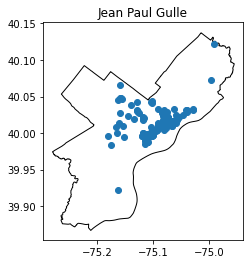

In [167]:
fig, ax = plt.subplots()
ax.set_title('Jean Paul Gulle')
city_boundaries.plot(ax = ax, color = "white", edgecolor = "black")
rtt_classified[rtt_classified['grantees_x_x'] == 'GULLE JEAN PAUL'].plot(ax = ax)

In [168]:
jean_paul_gulle = rtt_classified[rtt_classified['street_address_x'] == '3520 JOYCE ST'].sort_values(by=['document_date'], ascending = False)
jean_paul_gulle[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
487557,40000.0,GULLE JEAN PAUL,DIAZ LOUIS F,3520 JOYCE ST,2020-09-10T00:00:00
15587,60000.0,DIAZ LOUIS F,SPEISER JOHN,3520 JOYCE ST,2004-11-01T00:00:00
393582,49000.0,SPEISER JOHN,LAWNDALE EQUITIES INC,3520 JOYCE ST,2002-11-01T00:00:00
383002,24000.0,LAWNDALE EQUITIES INC,GRIFFITHS ARTHUR L,3520 JOYCE ST,2002-08-07T00:00:00
383001,10.0,GRIFFITHS ARTHUR L,DEUTSCHE BANK NATIONAL TRUST COMPANY TR,3520 JOYCE ST,2002-08-07T00:00:00


In [169]:
jean_paul_gulle = rtt_classified[rtt_classified['street_address_x'] == '5348 DARRAH ST'].sort_values(by=['document_date'], ascending = False)
jean_paul_gulle[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
482321,57500.0,GULLE JEAN PAUL,KNAPPE STILLA,5348 DARRAH ST,2020-06-03T00:00:00


In [170]:
jean_paul_gulle = rtt_classified[rtt_classified['street_address_x'] == '1924 BRIGGS ST'].sort_values(by=['document_date'], ascending = False)
jean_paul_gulle[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
482320,38000.0,GULLE JEAN PAUL,ATADGY DAVID,1924 BRIGGS ST,2020-06-03T00:00:00
456666,25000.0,ATADGY DAVID,DAVIS LEROY G; JONES MSIBA ESTATE OF,1924 BRIGGS ST,2019-07-05T00:00:00


In [171]:
jean_paul_gulle = rtt_classified[rtt_classified['street_address_x'] == '5281 BURTON ST'].sort_values(by=['document_date'], ascending = False)
jean_paul_gulle[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
369244,32500.0,GULLE JEAN PAUL,AU BERNARD C; AU LEE J,5281 BURTON ST,2002-02-21T00:00:00


In [172]:
jean_paul_gulle = rtt_classified[rtt_classified['street_address_x'] == '2136 KENNEDY ST'].sort_values(by=['document_date'], ascending = False)
jean_paul_gulle[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
375660,33000.0,GULLE JEAN PAUL,TARZAISKI RICHARD; TARZAISKI WILLIAM T,2136 KENNEDY ST,2002-05-23T00:00:00


**Exploration of Mercury Group**

<AxesSubplot:title={'center':'Mercury Group'}>

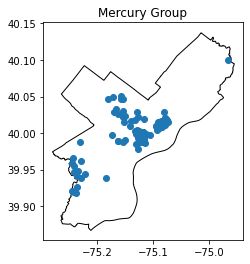

In [109]:
fig, ax = plt.subplots()
ax.set_title('Mercury Group')
city_boundaries.plot(ax = ax, color = "white", edgecolor = "black")
rtt_classified[rtt_classified['grantees_x_x'] == 'MERCURY GROUP'].plot(ax = ax)

In [110]:
rtt_classified[rtt_classified['grantees_x_x'] == 'MERCURY GROUP'].sort_values(by=['document_date'], ascending = False).head(10)

,id,C_DIG1,C_DIG1DESC,C_DIG2,C_DIG2DESC,C_DIG3,C_DIG3DESC,OBJECTID,Shape__Are,Shape__Len,VACBLDG,YEAR,address_high,address_low,address_low_frac,address_low_suffix,adjusted_assessed_value,adjusted_cash_consideration,adjusted_fair_market_value,adjusted_local_tax_amount,adjusted_other_consideration,adjusted_state_tax_amount,adjusted_total_consideration,assessed_value,cash_consideration,common_level_ratio,condo_name,discrepancy,display_date_x,display_date_y,document_date,document_id,document_type,elapsed,elapsed_days,fair_market_value,grantees_x_x,grantees_x_y,grantees_y,grantors_x,grantors_y,index_right,inv,investor_all,lat,legal_remarks,lng,local_tax_amount,local_tax_percent,matched_regmap,multi_invest,objectid,occ,opa_account_num,other_consideration,owner_occup,property_count,receipt_date,receipt_num,recording_date,reg_map_id,sort_year_x,sort_year_y,state_tax_amount,state_tax_percent,street_address_x,street_address_y,street_name,street_postdir,street_predir,street_suffix,total_consideration,unit_num,ward,zip_code,geometry
66997,66997,1,Residential,12,Residential Medium,121,Residential Rowhouse,6796,1293.206726,191.937658,None,2015,NaN,2103.0,None,None,NaN,26500.0,12509.44,795.0,NaN,265.0,26500.0,NaN,26500.0,NaN,None,no,2006-02-17T00:00:00,2006-02-17,2006-02-17T00:00:00,51398374,DEED,98,98.0,12509.44,MERCURY GROUP,MERCURY GROUP,False,PEURIFOY TED,PEURIFOY TED,7795,0,1.0,-75.243912,None,39.920549,795.0,100.0,030S080125,1.0,8287736,1,403214500.0,NaN,0,1.0,2006-03-14T00:00:00,None,2006-03-14T00:00:00,030S080125,2006,2006.0,265.0,100.0,2103 S 71ST ST,2103 S 71ST ST,71ST,None,S,ST,26500.0,None,40.0,19142.0,POINT (-75.24391 39.92055)
58390,58390,1,Residential,12,Residential Medium,121,Residential Rowhouse,425202,1409.006226,223.749099,None,2012,NaN,1922.0,None,None,NaN,32000.0,13372.16,960.0,NaN,320.0,32000.0,NaN,32000.0,NaN,None,no,2005-11-11T00:00:00,2005-11-11,2005-11-11T00:00:00,51337285,DEED,0,0.0,13372.16,MERCURY GROUP,MERCURY GROUP,False,BUGG AND ASSOCIATES,BUGG AND ASSOCIATES,426201,0,1.0,-75.084584,None,40.008951,960.0,100.0,083N090135,1.0,8213341,1,232043800.0,NaN,0,1.0,2005-12-14T00:00:00,None,2005-12-14T00:00:00,083N090135,2005,2005.0,320.0,100.0,1922 CHURCH ST,1922 CHURCH ST,CHURCH,None,None,ST,32000.0,None,23.0,19124.0,POINT (-75.08458 40.00895)
56994,56994,1,Residential,12,Residential Medium,121,Residential Rowhouse,356555,895.638916,148.030317,None,2015,NaN,4550.0,None,None,NaN,35000.0,22430.72,1050.0,NaN,350.0,35000.0,NaN,35000.0,NaN,None,no,2005-11-11T00:00:00,2005-11-11,2005-11-11T00:00:00,51319238,DEED,0,0.0,22430.72,MERCURY GROUP,MERCURY GROUP,False,BUGG AND ASSOCIATES,BUGG AND ASSOCIATES,355554,0,1.0,-75.150171,None,40.022876,1050.0,100.0,124N230198,1.0,8191539,1,132061200.0,NaN,0,1.0,2005-11-22T00:00:00,None,2005-11-22T00:00:00,124N230198,2005,2005.0,350.0,100.0,4550 N 15TH ST,4550 N 15TH ST,15TH,None,N,ST,35000.0,None,13.0,19140.0,POINT (-75.15017 40.02288)
56993,56993,1,Residential,12,Residential Medium,121,Residential Rowhouse,264834,644.465881,126.922197,Fully Vacant,2016,NaN,308.0,None,None,NaN,25000.0,8195.84,750.0,NaN,250.0,25000.0,NaN,25000.0,NaN,None,no,2005-11-11T00:00:00,2005-11-11,2005-11-11T00:00:00,51319237,DEED,0,0.0,8195.84,MERCURY GROUP,MERCURY GROUP,False,BUGG AND ASSOCIATES,BUGG AND ASSOCIATES,264833,0,1.0,-75.125826,None,39.991710,750.0,100.0,034N030033,1.0,8191537,1,71199200.0,NaN,0,1.0,2005-11-22T00:00:00,None,2005-11-22T00:00:00,034N030033,2005,2005.0,250.0,100.0,308 E SOMERSET ST,308 E SOMERSET ST,SOMERSET,None,E,ST,25000.0,None,7.0,19134.0,POINT (-75.12583 39.99171)
56992,56992,1,Residential,12,Residential Medium,121,Residential Rowhouse,278741,575.740662,114.025202,None,2016,NaN,613.0,None,None,NaN,24500.0,15528.96,735.0,NaN,245.0,24500.0,NaN,24500.0,NaN,None,no,2005-11-11T00:00:00,2005-11-11,2005-11-11T00:00:00,51319236,DEED,0,0.0,15528.96,MERCURY GROUP,MERCURY GROUP,False,BUGG AND ASSOCIATES,BUGG AND ASSOCIATES,279740,0,1.0,-75.118308,None,39.999993,735.0,100.0,041N050257,1.0,8191536,

In [227]:
mercury_group = rtt_classified[rtt_classified['street_address_x'] == '1922 CHURCH ST'].sort_values(by=['document_date'], ascending = False)
mercury_group[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
466029,510753.87,STEAMBOAT SCM FUND B LLC,MCCANN PHILADELPHIA INVESTOR CORP,1922 CHURCH ST,2019-11-07
101018,35000.00,MCCANN PHILADELPHIA INVESTOR CORP,MERCURY GROUP INC,1922 CHURCH ST,2007-03-14
58390,32000.00,MERCURY GROUP,BUGG AND ASSOCIATES,1922 CHURCH ST,2005-12-14


In [125]:
mercury_group = rtt_classified[rtt_classified['street_address_x'] == '2103 S 71ST ST'].sort_values(by=['document_date'], ascending = False)
mercury_group[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x
159451,21800.0,FRAZIER KELLY,MERCURY GROUP,2103 S 71ST ST
66997,26500.0,MERCURY GROUP,PEURIFOY TED,2103 S 71ST ST


In [228]:
mercury_group = rtt_classified[rtt_classified['street_address_x'] == '4550 N 15TH ST'].sort_values(by=['document_date'], ascending = False)
mercury_group[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
466178,510753.87,STEAMBOAT SCM FUND B LLC,MCCANN PHILADELPHIA INVESTOR CORP,4550 N 15TH ST,2019-11-07
159538,16742.01,MCCANN PHILADELPHIA INVESTOR CORP,MERCURY GROUP,4550 N 15TH ST,2009-07-01
56994,35000.00,MERCURY GROUP,BUGG AND ASSOCIATES,4550 N 15TH ST,2005-11-22


In [127]:
mercury_group = rtt_classified[rtt_classified['street_address_x'] == '308 E SOMERSET ST'].sort_values(by=['document_date'], ascending = False)
mercury_group[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x
465544,273531.69,OZ FUND 1 LLC,MCCANN PHILADELPHIA INVESTOR CORP,308 E SOMERSET ST
159542,4774.78,MCCANN PHILADELPHIA INVESTOR CORP,MERCURY GROUP,308 E SOMERSET ST
56993,25000.00,MERCURY GROUP,BUGG AND ASSOCIATES,308 E SOMERSET ST


In [128]:
mercury_group = rtt_classified[rtt_classified['street_address_x'] == '613 E THAYER ST'].sort_values(by=['document_date'], ascending = False)
mercury_group[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x
466292,510753.87,STEAMBOAT SCM FUND B LLC,MCCANN PHILADELPHIA INVESTOR CORP,613 E THAYER ST
101021,29000.00,MCCANN PHILADELPHIA INVESTOR CORP,MERCURY GROUP INC,613 E THAYER ST
56992,24500.00,MERCURY GROUP,BUGG AND ASSOCIATES,613 E THAYER ST


In [129]:
mercury_group = rtt_classified[rtt_classified['street_address_x'] == '2423 JASPER ST'].sort_values(by=['document_date'], ascending = False)
mercury_group[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x
482941,1.0,JDJ FUND C LLC,JDJ FUND 2 LLC,2423 JASPER ST
494396,1.0,JDJ FUND C LLC,JDJ FUND 2 LLC,2423 JASPER ST
466453,1.0,JDJ FUND 2 LLC,MCCANN PHILADELPHIA INVESTOR CORP,2423 JASPER ST
125968,26400.0,MCCANN PHILADELPHIA INVESTOR CORP,MERCURY GROUP INC,2423 JASPER ST
56991,25000.0,MERCURY GROUP,BUGG AND ASSOCIATES,2423 JASPER ST


In [130]:
mercury_group = rtt_classified[rtt_classified['street_address_x'] == '2759 HELEN ST'].sort_values(by=['document_date'], ascending = False)
mercury_group[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x
466033,510753.87,STEAMBOAT SCM FUND B LLC,MCCANN PHILADELPHIA INVESTOR CORP,2759 HELEN ST
117553,23000.00,MCCANN PHILADELPHIA INVESTOR CORPORATION,MERCURY GROUP PENNSYLVANIA CORPORATION,2759 HELEN ST
56970,23000.00,MERCURY GROUP,BUGG AND ASSOCIATES,2759 HELEN ST


In [131]:
mercury_group = rtt_classified[rtt_classified['street_address_x'] == '2856 JASPER ST'].sort_values(by=['document_date'], ascending = False)
mercury_group[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x
466035,510753.87,STEAMBOAT SCM FUND B LLC,MCCANN PHILADELPHIA INVESTOR CORP,2856 JASPER ST
125947,29200.00,MCCANN PHILADELPHIA INVESTOR CORP,MERCURY GROUP,2856 JASPER ST
56969,26000.00,MERCURY GROUP,BUGG AND ASSOCIATES,2856 JASPER ST


In [132]:
mercury_group = rtt_classified[rtt_classified['street_address_x'] == '3439 KEIM ST'].sort_values(by=['document_date'], ascending = False)
mercury_group[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x
466170,510753.87,STEAMBOAT SCM FUND B LLC,MCCANN PHILADELPHIA INVESTOR CORP,3439 KEIM ST
101020,30000.00,MCCANN PHILADELPHIA INVESTOR CORP,MERCURY GROUP INC,3439 KEIM ST
54811,27000.00,MERCURY GROUP,BUGG AND ASSOCIATES,3439 KEIM ST


In [133]:
mercury_group = rtt_classified[rtt_classified['street_address_x'] == '824 E HILTON ST'].sort_values(by=['document_date'], ascending = False)
mercury_group[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x
465669,273531.69,OZ FUND 1 LLC,MCCANN PHILADELPHIA INVESTOR CORP,824 E HILTON ST
118939,25500.00,MCCANN PHILADELPHIA INVESTOR CORP,MERCURY GROUP INC,824 E HILTON ST
54807,24000.00,MERCURY GROUP,BUGG AND ASSOCIATES,824 E HILTON ST


**Exploration of Bank of America**
- there is a $1 transfer from sec of housing to bank of america (i'm sure this is not uncommon)
- lots of movement between different llc's

<AxesSubplot:title={'center':'Bank of America NA'}>

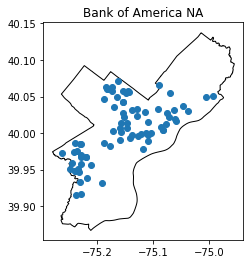

In [177]:
fig, ax = plt.subplots()
ax.set_title('Bank of America NA')
city_boundaries.plot(ax = ax, color = "white", edgecolor = "black")
rtt_classified[rtt_classified['grantees_x_x'] == 'BANK OF AMERICA NA'].plot(ax = ax)

In [178]:
rtt_classified[rtt_classified['grantees_x_x'].str.contains('BANK OF AMERICA NA', regex = True)].sort_values(by=['document_date'], ascending = False)

,id,C_DIG1,C_DIG1DESC,C_DIG2,C_DIG2DESC,C_DIG3,C_DIG3DESC,OBJECTID,Shape__Are,Shape__Len,VACBLDG,YEAR,address_high,address_low,address_low_frac,address_low_suffix,adjusted_assessed_value,adjusted_cash_consideration,adjusted_fair_market_value,adjusted_local_tax_amount,adjusted_other_consideration,adjusted_state_tax_amount,adjusted_total_consideration,assessed_value,cash_consideration,common_level_ratio,condo_name,discrepancy,display_date_x,display_date_y,document_date,document_id,document_type,elapsed,elapsed_days,fair_market_value,grantees_x_x,grantees_x_y,grantees_y,grantors_x,grantors_y,index_right,inv,investor_all,lat,legal_remarks,lng,local_tax_amount,local_tax_percent,matched_regmap,multi_invest,objectid,occ,opa_account_num,other_consideration,owner_occup,property_count,receipt_date,receipt_num,recording_date,reg_map_id,sort_year_x,sort_year_y,state_tax_amount,state_tax_percent,street_address_x,street_address_y,street_name,street_postdir,street_predir,street_suffix,total_consideration,unit_num,ward,zip_code,geometry
451172,451172,1,Residential,12,Residential Medium,121,Residential Rowhouse,125876,967.163818,162.915359,None,2017,NaN,633.0,None,None,26900.0,1.00,27169.00,890.60,NaN,271.69,1.00,26900.0,1.00,1.01,None,no,2019-04-17T00:00:00,2019-04-17,2019-04-17T00:00:00,53503265,DEED,700,700.0,27169.00,BANK OF AMERICA NA,BANK OF AMERICA NA,False,BANK OF AMERICA NA; TIAA FSA,BANK OF AMERICA NA; TIAA FSA,126875,0,1.0,-75.228309,None,39.970051,890.60,100.0,073N130147,1.0,11653509,1,442353500.0,0.0,0,1.0,2019-04-22T00:00:00,"19-38440,19-38440-C1",2019-04-22T00:00:00,073N130147,2019,2019.0,271.69,100.0,633 N 54TH ST,633 N 54TH ST,54TH,None,N,ST,1.00,None,44.0,19131.0,POINT (-75.22831 39.97005)
332696,332696,1,Residential,12,Residential Medium,121,Residential Rowhouse,397712,1613.596924,213.561129,None,2016,NaN,7911.0,None,None,134300.0,10.00,135643.00,4204.93,NaN,1356.43,10.00,134300.0,10.00,1.01,None,no,2017-08-15T00:00:00,2017-08-15,2017-08-15T00:00:00,53258746,DEED,144,144.0,135643.00,BANK OF AMERICA NATIONAL ASSOCIATION,BANK OF AMERICA NATIONAL ASSOCIATION,False,CHAMPION MORTGAGE COMPANY; NATIONSTAR MORTGAGE...,CHAMPION MORTGAGE COMPANY; NATIONSTAR MORTGAGE...,396711,0,1.0,-75.160773,None,40.072161,4204.93,100.0,109N230134,1.0,10556391,1,501293900.0,0.0,0,1.0,2017-08-29T00:00:00,17-89514,2017-08-29T00:00:00,109N230134,2017,2017.0,1356.43,100.0,7911 LIMEKILN PIKE,7911 LIMEKILN PIKE,LIMEKILN,None,None,PIKE,10.00,None,50.0,19150.0,POINT (-75.16077 40.07216)
326994,326994,1,Residential,11,Residential Low,111,Residential Detached,3858,3802.911682,350.057425,Fully Vacant,2015,NaN,7039.0,None,None,82500.0,1.00,84150.00,2608.65,NaN,841.50,1.00,82500.0,1.00,1.02,None,no,2017-05-17T00:00:00,2017-05-17,2017-05-17T00:00:00,53230156,DEED,27,27.0,84150.00,BANK OF AMERICA NA,BANK OF AMERICA NA,False,SECRETARY OF HOUSING AND URBAN DEVELOPMENT,SECRETARY OF HOUSING AND URBAN DEVELOPMENT,2857,0,1.0,-75.237152,None,39.915669,2608.65,100.0,039S010011,1.0,10521158,1,406254000.0,0.0,0,1.0,2017-06-26T00:00:00,17-64948,2017-06-26T00:00:00,039S010011,2017,2017.0,841.50,100.0,7039 BUIST AVE,7039 BUIST AVE,BUIST,None,None,AVE,1.00,None,40.0,19142.0,POINT (-75.23715 39.91567)
322514,322514,1,Residential,12,Residential Medium,121,Residential Rowhouse,91806,1179.555298,158.759738,None,2017,NaN,815.0,None,None,62900.0,1.00,64158.00,1988.90,NaN,641.58,1.00,62900.0,1.00,1.02,None,no,2017-04-20T00:00:00,2017-04-20,2017-04-20T00:00:00,53206961,DEED,9,9.0,64158.00,BANK OF AMERICA NA,BANK OF AMERICA NA,False,SECRETARY OF HOUSING AND URBAN DEVELOPMENT,SECRETARY OF HOUSING AND URBAN DEVELOPMENT,91805,0,1.0,-75.238699,None,39.948335,1988.90,100.0,025S020141,1.0,10494135,1,463269700.0,0.0,0,1.0,2017-05-03T00:00:00,17-45128,2017-05-03T00:00:00,025S020141,2017,2017.0,641.58,100.0,815 S CECIL ST,815 S CECIL ST,CECIL,None,S,ST,1.00,None,46.0,19143.0,POINT (-75.23870 39.94833)
322419,322419,1,Residential,12,Residential Medium,121,Residential Rowhouse,399793,1169.228333,19

In [179]:
bank_of_america = rtt_classified[rtt_classified['street_address_x'] == '633 N 54TH ST'].sort_values(by=['document_date'], ascending = False)
bank_of_america[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
467373,40000.0,633 N 54TH STREET LLC,NGZ PROPERTIES LLC,633 N 54TH ST,2019-12-19T00:00:00
454751,29778.1,NGZ PROPERTIES LLC,BANK OF AMERICA NA,633 N 54TH ST,2019-05-09T00:00:00
451172,1.0,BANK OF AMERICA NA,BANK OF AMERICA NA; TIAA FSA,633 N 54TH ST,2019-04-22T00:00:00
90975,35000.0,WILLIAMS KEVIN,MORRIS JERRY,633 N 54TH ST,2000-10-19T00:00:00
414430,15000.0,MORRIS JERRY,PISGAH INVESTMENT CORPORATION,633 N 54TH ST,2000-05-01T00:00:00


In [180]:
bank_of_america = rtt_classified[rtt_classified['street_address_x'] == '815 S CECIL ST'].sort_values(by=['document_date'], ascending = False)
bank_of_america[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
344770,33000.0,GREEN DOT PROPERTIES LLC,BANK OF AMERICA NA,815 S CECIL ST,2018-02-12T00:00:00
322514,1.0,BANK OF AMERICA NA,SECRETARY OF HOUSING AND URBAN DEVELOPMENT,815 S CECIL ST,2017-05-03T00:00:00
215531,6000.0,BLUE ROCK SERVICES,OFFICE OF THE DISTRICT ATTORNEY,815 S CECIL ST,2012-06-27T00:00:00
92316,59000.0,CLARK AMEENAH,KING BLANCHE D; KING OLIVER L,815 S CECIL ST,2006-11-30T00:00:00


In [182]:
bank_of_america = rtt_classified[rtt_classified['street_address_x'] == '4428 SANSOM ST'].sort_values(by=['document_date'], ascending = False)
bank_of_america[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
210775,185000.0,JIANG XIAOSHAN,BANK OF AMERICA NA,4428 SANSOM ST,2012-05-16T00:00:00
208280,10.0,BANK OF AMERICA NA,FANNIE MAE,4428 SANSOM ST,2012-03-06T00:00:00
107153,410000.0,KHAN SHARAFAT,RABBANI GHULAM U,4428 SANSOM ST,2007-05-17T00:00:00
62056,192500.0,RABBANI GHULAM U,BANGLADESH SOCIETY OF PHILADELPHIA,4428 SANSOM ST,2006-01-23T00:00:00
423608,1.0,BANGLADESH SOCIETY OF PHILADELPHIA PA NON PROF...,KHAN MOHAMMAD MAHSIN; PATWARY MOHAMMED A; SIDD...,4428 SANSOM ST,2003-12-26T00:00:00
4128,41000.0,KHAN MOHAMMED MAHSIN; PATWARY MOHAMMED A; SIDD...,KRAFT ROBERT A,4428 SANSOM ST,2000-06-13T00:00:00


In [183]:
bank_of_america = rtt_classified[rtt_classified['street_address_x'] == '5800 KEMBLE AVE'].sort_values(by=['document_date'], ascending = False)
bank_of_america[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
344483,58200.0,PROFKA ARBEN,BANK OF AMERICA N A,5800 KEMBLE AVE,2018-01-31T00:00:00
322419,1.0,BANK OF AMERICA NA,SECRETARY OF HOUSING AND URBAN DEVELOPMENT,5800 KEMBLE AVE,2017-05-12T00:00:00
275753,1.0,BANK OF AMERICA NA,SECRETARY OF HOUSING AND URBAN DEVELOPMENT,5800 KEMBLE AVE,2015-07-08T00:00:00
136786,55000.0,ELDEMIRE AYIESHA N,SECRETARY OF HOUSING AND URBAN DEVELOPMENT,5800 KEMBLE AVE,2008-06-16T00:00:00
64024,61000.0,CONIX KURTIS T SR; THOMAS NASHEEKA E,GREEN AMOS JR,5800 KEMBLE AVE,2000-09-08T00:00:00


**Exploration of Allegany West**

<AxesSubplot:title={'center':'Allegheny West'}>

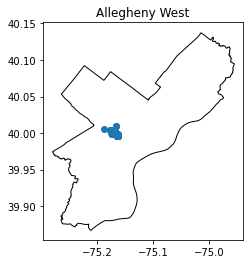

In [184]:
fig, ax = plt.subplots()
ax.set_title('Allegheny West')
city_boundaries.plot(ax = ax, color = "white", edgecolor = "black")
rtt_classified[rtt_classified['grantees_x_x'] == 'ALLEGHENY WEST FOUNDATION'].plot(ax = ax)

In [185]:
rtt_classified[rtt_classified['grantees_x_x'].str.contains('ALLEGHENY WEST FOUNDATION', regex = True)].sort_values(by=['document_date'], ascending = False)

,id,C_DIG1,C_DIG1DESC,C_DIG2,C_DIG2DESC,C_DIG3,C_DIG3DESC,OBJECTID,Shape__Are,Shape__Len,VACBLDG,YEAR,address_high,address_low,address_low_frac,address_low_suffix,adjusted_assessed_value,adjusted_cash_consideration,adjusted_fair_market_value,adjusted_local_tax_amount,adjusted_other_consideration,adjusted_state_tax_amount,adjusted_total_consideration,assessed_value,cash_consideration,common_level_ratio,condo_name,discrepancy,display_date_x,display_date_y,document_date,document_id,document_type,elapsed,elapsed_days,fair_market_value,grantees_x_x,grantees_x_y,grantees_y,grantors_x,grantors_y,index_right,inv,investor_all,lat,legal_remarks,lng,local_tax_amount,local_tax_percent,matched_regmap,multi_invest,objectid,occ,opa_account_num,other_consideration,owner_occup,property_count,receipt_date,receipt_num,recording_date,reg_map_id,sort_year_x,sort_year_y,state_tax_amount,state_tax_percent,street_address_x,street_address_y,street_name,street_postdir,street_predir,street_suffix,total_consideration,unit_num,ward,zip_code,geometry
275576,275576,1,Residential,11,Residential Low,111,Residential Detached,344918,5590.221436,501.035466,None,2016,NaN,2223.0,None,None,65100.0,32500.000000,65100.000000,975.0,NaN,325.000000,32500.000000,130200.0,65000.0,NaN,None,no,2015-06-22T00:00:00,2015-06-22,2015-06-22T00:00:00,52933106,DEED,0,0.0,130200.00,ALLEGHENY WEST FOUNDATION,ALLEGHENY WEST FOUNDATION,False,TRAWICK JUANITA,TRAWICK JUANITA,343917,0,1.0,-75.165617,PREMISES 'B',40.009856,1950.0,100.0,046N050029,1.0,10158144,1,131016200.0,NaN,0,2.0,2015-06-26T00:00:00,None,2015-06-26T00:00:00,046N050029,2015,2015.0,650.0,100.0,2223 W VENANGO ST,2223 W VENANGO ST,VENANGO,None,W,ST,65000.0,None,13.0,19140.0,POINT (-75.16562 40.00986)
275575,275575,1,Residential,11,Residential Low,111,Residential Detached,345968,5805.939331,503.031918,None,2016,NaN,2221.0,None,None,65100.0,32500.000000,65100.000000,975.0,NaN,325.000000,32500.000000,130200.0,65000.0,NaN,None,no,2015-06-22T00:00:00,2015-06-22,2015-06-22T00:00:00,52933106,DEED,1433,1433.0,130200.00,ALLEGHENY WEST FOUNDATION,ALLEGHENY WEST FOUNDATION,False,TRAWICK JUANITA,TRAWICK JUANITA,345967,0,1.0,-75.165529,PREMISES 'A',40.009845,1950.0,100.0,046N050028,1.0,10158143,1,131016100.0,NaN,0,2.0,2015-06-26T00:00:00,None,2015-06-26T00:00:00,046N050028,2015,2015.0,650.0,100.0,2221 W VENANGO ST,2221 W VENANGO ST,VENANGO,None,W,ST,65000.0,None,13.0,19140.0,POINT (-75.16553 40.00985)
197646,197646,1,Residential,12,Residential Medium,121,Residential Rowhouse,225061,690.024048,121.258653,None,2016,65.0,2863.0,None,None,1964.8,2.200000,6149.824000,NaN,NaN,61.500000,2.200000,9824.0,11.0,NaN,None,no,2011-07-20T00:00:00,2011-07-20,2011-07-20T00:00:00,52370802,DEED,0,0.0,30749.12,ALLEGHENY WEST FOUNDATION,ALLEGHENY WEST FOUNDATION,False,REDEVELOPMENT AUTHORITY OF THE CITY OF PHILADE...,REDEVELOPMENT AUTHORITY OF THE CITY OF PHILADE...,226060,0,1.0,-75.162763,None,39.998042,0.0,100.0,035N190232,1.0,9469420,1,111245210.0,NaN,0,5.0,2011-07-21T00:00:00,None,2011-07-21T00:00:00,035N190232,2011,2011.0,307.5,100.0,2865 N OPAL ST,2865 N OPAL ST,OPAL,None,N,ST,11.0,None,11.0,19132.0,POINT (-75.16276 39.99804)
197645,197645,1,Residential,12,Residential Medium,121,Residential Rowhouse,226322,679.100037,118.220366,None,2016,42.0,2838.0,None,None,1964.8,2.200000,6149.824000,NaN,NaN,61.500000,2.200000,9824.0,11.0,NaN,None,no,2011-07-20T00:00:00,2011-07-20,2011-07-20T00:00:00,52370802,DEED,0,0.0,30749.12,ALLEGHENY WEST FOUNDATION,ALLEGHENY WEST FOUNDATION,False,REDEVELOPMENT AUTHORITY OF THE CITY OF PHILADE...,REDEVELOPMENT AUTHORITY OF THE CITY OF PHILADE...,225321,0,1.0,-75.163126,None,39.997607,0.0,100.0,035N190231,1.0,9469419,1,111249935.0,NaN,0,5.0,2011-07-21T00:00:00,None,2011-07-21T00:00:00,035N190231,2011,2011.0,307.5,100.0,2840 N OPAL ST,2840 N OPAL ST,OPAL,None,N,ST,11.0,None,11.0,19132.0,POINT (-75.16313 39.99761)
197644,197644,1,Residential,12,Residential Medium,121,Residential Rowhouse,225066,712.748291,126.146377,None,2016,56.

In [ ]:
allegheny_west = rtt_classified[rtt_classified['street_address_x'] == '5281 BURTON ST'].sort_values(by=['document_date'], ascending = False)
allegheny_west[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

**Exploration of Wells Fargo**

<AxesSubplot:title={'center':'Wells Fargo'}>

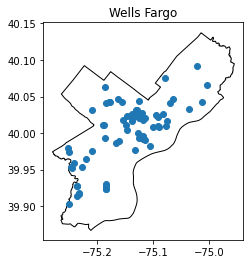

In [186]:
fig, ax = plt.subplots()
ax.set_title('Wells Fargo')
city_boundaries.plot(ax = ax, color = "white", edgecolor = "black")
rtt_classified[rtt_classified['grantees_x_x'] == 'WELLS FARGO BANK NA'].plot(ax = ax)

In [187]:
rtt_classified[rtt_classified['grantees_x_x'].str.contains('WELLS FARGO BANK NA', regex = True)].sort_values(by=['document_date'], ascending = False)

,id,C_DIG1,C_DIG1DESC,C_DIG2,C_DIG2DESC,C_DIG3,C_DIG3DESC,OBJECTID,Shape__Are,Shape__Len,VACBLDG,YEAR,address_high,address_low,address_low_frac,address_low_suffix,adjusted_assessed_value,adjusted_cash_consideration,adjusted_fair_market_value,adjusted_local_tax_amount,adjusted_other_consideration,adjusted_state_tax_amount,adjusted_total_consideration,assessed_value,cash_consideration,common_level_ratio,condo_name,discrepancy,display_date_x,display_date_y,document_date,document_id,document_type,elapsed,elapsed_days,fair_market_value,grantees_x_x,grantees_x_y,grantees_y,grantors_x,grantors_y,index_right,inv,investor_all,lat,legal_remarks,lng,local_tax_amount,local_tax_percent,matched_regmap,multi_invest,objectid,occ,opa_account_num,other_consideration,owner_occup,property_count,receipt_date,receipt_num,recording_date,reg_map_id,sort_year_x,sort_year_y,state_tax_amount,state_tax_percent,street_address_x,street_address_y,street_name,street_postdir,street_predir,street_suffix,total_consideration,unit_num,ward,zip_code,geometry
465698,465698,1,Residential,12,Residential Medium,121,Residential Rowhouse,452832,1283.272278,186.611784,None,2012,NaN,1882.0,None,None,72900.0,20600.0,73629.00,675.27,NaN,206.00,20600.0,72900.0,20600.0,1.01,None,no,2019-09-19T00:00:00,2019-09-19,2019-09-19T00:00:00,53592335,DEED,581,581.0,73629.00,WELLS FARGO BANK NA,WELLS FARGO BANK NA,False,SEUTSCHE BANK NATIONAL TRUST COMPANY,SEUTSCHE BANK NATIONAL TRUST COMPANY,453831,0,1.0,-75.074484,None,40.017041,675.27,100.0,089N180248,1.0,11763360,1,622018500.0,0.0,0,1.0,2019-11-14T00:00:00,19-115823,2019-11-14T00:00:00,089N180248,2019,2019.0,206.00,100.0,1882 HAWORTH ST,1882 HAWORTH ST,HAWORTH,None,None,ST,20600.0,None,62.0,19124.0,POINT (-75.07448 40.01704)
347216,347216,1,Residential,12,Residential Medium,121,Residential Rowhouse,12150,1197.770874,176.040008,None,2015,NaN,2635.0,None,None,63900.0,40500.0,64539.00,1255.50,NaN,405.00,40500.0,63900.0,40500.0,1.01,None,no,2018-02-15T00:00:00,2018-02-15,2018-02-15T00:00:00,53340099,DEED,311,311.0,64539.00,WELLS FARGO BANK NA,WELLS FARGO BANK NA,False,DEUTSCHE BANK NATIONAL TRUST COMPANY TR; GSAMP...,DEUTSCHE BANK NATIONAL TRUST COMPANY TR; GSAMP...,12149,0,1.0,-75.232027,None,39.917625,1255.50,100.0,042S110012,1.0,10655426,1,406093300.0,0.0,0,1.0,2018-03-19T00:00:00,18-25867,2018-03-19T00:00:00,042S110012,2018,2018.0,405.00,100.0,2635 S 68TH ST,2635 S 68TH ST,68TH,None,S,ST,40500.0,None,40.0,19142.0,POINT (-75.23203 39.91762)
323678,323678,1,Residential,11,Residential Low,112,Residential SemiDetached,347928,1828.917297,244.734330,None,2013,NaN,3432.0,None,None,214600.0,10.0,218892.00,6785.65,NaN,2188.92,10.0,214600.0,10.0,1.02,None,no,2017-04-10T00:00:00,2017-04-10,2017-04-10T00:00:00,53207239,DEED,207,207.0,218892.00,WELLS FARGO BANK NA,WELLS FARGO BANK NA,False,SECRETARY OF HOUSING AND URBAN DEVELOPMENT,SECRETARY OF HOUSING AND URBAN DEVELOPMENT,346927,0,1.0,-75.187004,1 DIMENSION IS INCORRECT IN DESCRIPTION,40.010979,6785.65,100.0,103N240016,1.0,10494493,1,382071900.0,0.0,0,1.0,2017-05-03T00:00:00,17-45331,2017-05-03T00:00:00,103N240016,2017,2017.0,2188.92,100.0,3432 INDIAN QUEEN LN,3432 INDIAN QUEEN LN,INDIAN QUEEN,None,None,LN,10.0,None,38.0,19129.0,POINT (-75.18700 40.01098)
311997,311997,1,Residential,12,Residential Medium,121,Residential Rowhouse,537448,1459.994812,219.086562,None,2015,NaN,8520.0,None,None,115500.0,1.0,117810.00,3534.30,NaN,1178.10,1.0,115500.0,1.0,1.02,None,no,2016-09-15T00:00:00,2016-09-15,2016-09-15T00:00:00,53148361,DEED,44,44.0,117810.00,WELLS FARGO BANK NA,WELLS FARGO BANK NA,False,FEDERAL NATIONAL MORTGAGE ASSOCIATION,FEDERAL NATIONAL MORTGAGE ASSOCIATION,537447,0,1.0,-75.012876,None,40.042066,3534.30,100.0,124N020079,1.0,10421938,1,652320700.0,0.0,0,1.0,2016-12-15T00:00:00,16-123703,2016-12-15T00:00:00,124N020079,2016,2016.0,1178.10,100.0,8520 TORRESDALE AVE,8520 TORRESDALE AVE,TORRESDALE,None,None,AVE,1.0,None,65.0,19136.0,POINT (-75.01288 40.04207)
313399,313399,1,Residential,12,Resid

In [188]:
wells_fargo = rtt_classified[rtt_classified['street_address_x'] == '1882 HAWORTH ST'].sort_values(by=['document_date'], ascending = False)
wells_fargo[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
465699,60000.0,LU JIAN CONG,BARON LISA; BARON VICTOR MARK,1882 HAWORTH ST,2019-11-14T00:00:00
465698,20600.0,WELLS FARGO BANK NA,SEUTSCHE BANK NATIONAL TRUST COMPANY,1882 HAWORTH ST,2019-11-14T00:00:00


In [ ]:
wells_fargo = rtt_classified[rtt_classified['street_address_x'] == '1882 HAWORTH ST'].sort_values(by=['document_date'], ascending = False)
wells_fargo[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

In [190]:
wells_fargo = rtt_classified[rtt_classified['street_address_x'] == '2635 S 68TH ST'].sort_values(by=['document_date'], ascending = False)
wells_fargo[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
347216,40500.0,WELLS FARGO BANK NA,DEUTSCHE BANK NATIONAL TRUST COMPANY TR; GSAMP...,2635 S 68TH ST,2018-03-19T00:00:00
384751,59900.0,WILLIAMS ANTHONY R,BRADY JAMES A; BRADY ROSEMARY B,2635 S 68TH ST,2002-08-16T00:00:00


In [192]:
wells_fargo = rtt_classified[rtt_classified['street_address_x'] == '3432 INDIAN QUEEN LN'].sort_values(by=['document_date'], ascending = False)
wells_fargo[['cash_consideration','grantees_x_x', 'grantors_x', 'street_address_x', 'receipt_date']].head(10)

,cash_consideration,grantees_x_x,grantors_x,street_address_x,receipt_date
323679,130000.0,PRICE TIFFANY B; SHAYNE HILLARY B,WELLS FARGO BANK N A,3432 INDIAN QUEEN LN,2017-05-03T00:00:00
323678,10.0,WELLS FARGO BANK NA,SECRETARY OF HOUSING AND URBAN DEVELOPMENT,3432 INDIAN QUEEN LN,2017-05-03T00:00:00
95117,200000.0,MACDONALD KEVIN; VLASTARIDIS REBECCA,MACERA JOHN L JR,3432 INDIAN QUEEN LN,2006-12-29T00:00:00
366290,85700.0,MACERA JOHN L JR,WHITLOCK ROBERT V,3432 INDIAN QUEEN LN,2002-06-07T00:00:00


In [194]:
rtt_classified['receipt_date'] = pd.to_datetime(rtt_classified['receipt_date'])
rtt_classified['Rank'] = rtt_classified.groupby('street_address_x')['receipt_date'].rank(ascending=False)

In [195]:
rtt_classified.head()

,id,C_DIG1,C_DIG1DESC,C_DIG2,C_DIG2DESC,C_DIG3,C_DIG3DESC,OBJECTID,Shape__Are,Shape__Len,VACBLDG,YEAR,address_high,address_low,address_low_frac,address_low_suffix,adjusted_assessed_value,adjusted_cash_consideration,adjusted_fair_market_value,adjusted_local_tax_amount,adjusted_other_consideration,adjusted_state_tax_amount,adjusted_total_consideration,assessed_value,cash_consideration,common_level_ratio,condo_name,discrepancy,display_date_x,display_date_y,document_date,document_id,document_type,elapsed,elapsed_days,fair_market_value,grantees_x_x,grantees_x_y,grantees_y,grantors_x,grantors_y,index_right,inv,investor_all,lat,legal_remarks,lng,local_tax_amount,local_tax_percent,matched_regmap,multi_invest,objectid,occ,opa_account_num,other_consideration,owner_occup,property_count,receipt_date,receipt_num,recording_date,reg_map_id,sort_year_x,sort_year_y,state_tax_amount,state_tax_percent,street_address_x,street_address_y,street_name,street_postdir,street_predir,street_suffix,total_consideration,unit_num,ward,zip_code,geometry,Rank
0,0,1,Residential,12,Residential Medium,121,Residential Rowhouse,280539,952.673950,165.045972,Fully Vacant,2014,NaN,3083.0,None,None,NaN,58900.0,30699.84,1767.0,NaN,589.0,58900.0,NaN,58900.0,NaN,None,no,2004-04-02T00:00:00,NaT,2004-04-02T00:00:00,50942296,DEED,999,NaN,30699.84,IRWIN LEIGHANNE,None,False,MCCAFFERTY MARIE E; TUCKER MARGARET T,None,285538,0,0.0,-75.109769,None,39.987205,1767.0,100.0,022N240033,NaN,7744699,1,251496000.0,NaN,1,1.0,2004-06-07,None,2004-06-07T00:00:00,022N240033,2004,NaN,589.0,100.0,3083 MEMPHIS ST,None,MEMPHIS,None,None,ST,58900.0,None,25.0,19134.0,POINT (-75.10977 39.98721),6.0
1,1,1,Residential,11,Residential Low,112,Residential SemiDetached,530366,3395.618225,298.879760,None,2016,NaN,3631.0,None,None,NaN,92000.0,63936.00,2760.0,NaN,920.0,92000.0,NaN,92000.0,NaN,None,no,2000-05-25T00:00:00,NaT,2000-05-25T00:00:00,50092387,DEED,999,NaN,63936.00,FALLEN PAUL J III,None,False,TAYLOR COLERIDGE; TAYLOR ROBERT TR; TAYLOR RON...,None,531365,0,0.0,-74.997365,None,40.074151,2760.0,100.0,084N180294,NaN,7744935,1,661087900.0,0.0,1,1.0,2000-06-07,None,2000-06-07T00:00:00,084N180294,2000,NaN,920.0,100.0,3631 AVALON ST,None,AVALON,None,None,ST,92000.0,None,66.0,19114.0,POINT (-74.99737 40.07415),1.0
2,2,1,Residential,12,Residential Medium,121,Residential Rowhouse,474918,1717.321350,237.627137,None,2015,NaN,3430.0,None,None,NaN,123000.0,43066.56,3690.0,NaN,1230.0,123000.0,NaN,123000.0,NaN,None,no,2004-05-28T00:00:00,NaT,2004-05-28T00:00:00,50942514,DEED,999,NaN,43066.56,RUTA JOSEPH M,None,False,ROWLAND JAMES; ROWLAND JOAN,None,474917,0,0.0,-75.041471,None,40.038977,3690.0,100.0,137N180119,NaN,7744943,1,642110500.0,NaN,1,1.0,2004-06-08,None,2004-06-08T00:00:00,137N180119,2004,NaN,1230.0,100.0,3430 ALDINE ST,None,ALDINE,None,None,ST,123000.0,None,64.0,19136.0,POINT (-75.04147 40.03898),4.0
3,3,1,Residential,12,Residential Medium,121,Residential Rowhouse,472582,1555.363403,195.088770,None,2012,NaN,5809.0,None,None,NaN,93000.0,45344.64,2790.0,NaN,930.0,93000.0,NaN,93000.0,NaN,None,no,2004-05-28T00:00:00,NaT,2004-05-28T00:00:00,50942516,DEED,999,NaN,45344.64,DUFFIE JAMIE,None,False,LAVIN BETH,None,472581,0,0.0,-75.078006,None,40.028446,2790.0,100.0,139N020114,NaN,7744945,1,621440200.0,NaN,1,1.0,2004-06-08,None,2004-06-08T00:00:00,139N020114,2004,NaN,930.0,100.0,5809 AKRON ST,None,AKRON,None,None,ST,93000.0,None,62.0,19149.0,POINT (-75.07801 40.02845),2.0
4,4,1,Residential,11,Residential Low,111,Residential Detached,475314,6734.606567,352.840272,None,2013,NaN,1403.0,None,None,NaN,68500.0,305913.60,2055.0,NaN,685.0,68500.0,NaN,68500.0,NaN,None,no,2004-05-12T00:00:00,NaT,2004-05-12T00:00:00,50941882,DEED,999,NaN,305913.60,NVR INC,None,True,CHAMPION DEVELOPMENT CORPORATION,None,476313,1,1.0,-75.063039,SUB OF 33,40.070579,2055.0,100.0,154N130125,NaN,7744231,0,562065112.0,NaN,0,1.0,2004-06-07,None,2004-06-07T00:00:00,154N130125,2004,NaN,685.0,100.0,1403 ROSE PETAL WAY,None,ROSE PETAL,None,None,WAY,6850

In [200]:
rtt_classified['sfr'] = np.where((rtt_classified.inv == 1) & (rtt_classified.Rank == 1.0), 1, 0)

In [205]:
rtt_classified['flip'] = np.where((rtt_classified.inv == 1) & (rtt_classified.Rank != 1.0), 1, 0)

In [207]:
rtt_classified[rtt_classified['flip']==0].shape[0]

451134

In [40]:
mult_grantors_count.head(25)

grantors_x
SECRETARY OF HOUSING AND URBAN DEVELOPMENT                             1621
SECRETARY OF HOUSING AND URBAN DEVELOPME                                896
OFFICE OF THE DISTRICT ATTORNEY                                         417
FEDERAL NATIONAL MORTGAGE ASSOCIATION                                   357
DEMARCO DREW                                                            357
FANNIE MAE; FEDERAL NATIONAL MORTGAGE ASSOCIATION                       329
REDEVELOPMENT AUTHORITY OF THE CITY OF PHILADELPHIA                     246
PHILADELPHIA HOUSING AUTHORITY                                          226
DEUTSCHE BANK NATIONAL TRUST COMPANY TR                                 226
FEDERAL HOME LOAN MORTGAGE CORPORATION                                  198
SECRETARY OF HOUSING AND URBAN DEVELOP                                  187
REDEVELOPMENT AUTHORITY OF THE CITY OF P                                187
SECRETARY OF VETERANS AFFAIRS                                           180
U

In [62]:
mult_grantors_grantees_count = mult_deeds.groupby(['grantors_x','grantees_x_x'])['id'].count().sort_values(ascending = False).reset_index()
mult_grantors_grantees_count.crs = 'epsg:4326'

In [63]:
mult_grantors_grantees_count.head()

,grantors_x,grantees_x_x,id
0,SECRETARY OF HOUSING AND URBAN DEVELOPME,MAHALLATI JOSEPH,60
1,BUGG AND ASSOCIATES,MERCURY GROUP,53
2,TIGER RELOCATION COMPANY,LUBLIN WILLIAM H; WALSH JAMES,50
3,CECIL B MOORE AVENUE LOCAL DEVELOPMENT C,CECIL B MOORE HOMEOWNERSHIP DEVELOPMENT,48
4,REDEVELOPMENT AUTHORITY OF THE CITY OF PHILADE...,ALLEGHENY WEST FOUNDATION,46


In [77]:
mult_grantors_grantees_count.loc[mult_grantors_grantees_count['grantors_x']== 'DREW DEMARCO'].head(15)

,grantors_x,grantees_x_x,id
37947,DREW DEMARCO,PORTER DENISECIA,1


In [76]:
mult_grantors_grantees_count.loc[mult_grantors_grantees_count['grantees_x_x']== 'FOTIADIS NIKOLAOS; OSEROFF AARON'].head(15)

,grantors_x,grantees_x_x,id
377,DENVIR HARRY,FOTIADIS NIKOLAOS; OSEROFF AARON,5
531,STINSON JACQUELINE,FOTIADIS NIKOLAOS; OSEROFF AARON,4
589,WACHOVIA BANK NATIONAL ASSOCIATION,FOTIADIS NIKOLAOS; OSEROFF AARON,4
730,FIRST UNION NATIONAL BANK TR,FOTIADIS NIKOLAOS; OSEROFF AARON,4
1673,WACHOVIA BANK NATIONAL ASSOCIATION TR,FOTIADIS NIKOLAOS; OSEROFF AARON,3
1900,NEKTALOV ABREKH; NEKTALOV DENNIS,FOTIADIS NIKOLAOS; OSEROFF AARON,3
7527,HAPPE LIMITED PARTNERSHIP,FOTIADIS NIKOLAOS; OSEROFF AARON,2
10309,FIRST UNION NATIONAL BANK,FOTIADIS NIKOLAOS; OSEROFF AARON,2
14346,FERRER JOHNNY,FOTIADIS NIKOLAOS; OSEROFF AARON,1
14457,ARIAS BIENVIENIDA; RIVERA BIENVENIDA,FOTIADIS NIKOLAOS; OSEROFF AARON,1


In [76]:
city_boundaries = gpd.read_file("data/City_Limits.geojson")

In [115]:
city_boundaries.crs = 'epsg:4326'

<AxesSubplot:title={'center':'Drew Demarco'}>

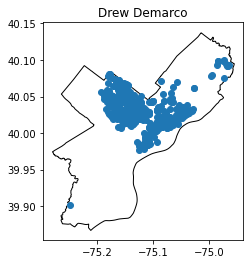

In [120]:
fig, ax = plt.subplots()
ax.set_title('Drew Demarco')
city_boundaries.plot(ax = ax, color = "white", edgecolor = "black")
rtt_classified[rtt_classified['grantees_x_x'] == 'DEMARCO DREW'].plot(ax = ax)


<AxesSubplot:title={'center':'William Lublin | James Walsh'}>

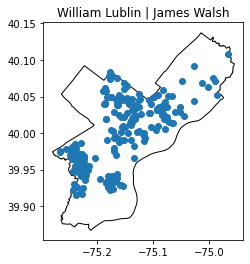

In [128]:
fig, ax = plt.subplots()
ax.set_title('William Lublin | James Walsh')
city_boundaries.plot(ax = ax, color = "white", edgecolor = "black")
rtt_classified[rtt_classified['grantees_x_x'] == 'LUBLIN WILLIAM H; WALSH JAMES'].plot(ax = ax)

<AxesSubplot:title={'center':'Nikolaos Fotiadis | Aaron Oseroff'}>

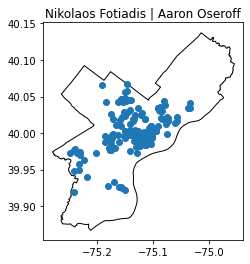

In [130]:
fig, ax = plt.subplots()
ax.set_title('Nikolaos Fotiadis | Aaron Oseroff')
city_boundaries.plot(ax = ax, color = "white", edgecolor = "black")
rtt_classified[rtt_classified['grantees_x_x'] == 'FOTIADIS NIKOLAOS; OSEROFF AARON'].plot(ax = ax)

<AxesSubplot:title={'center':'Jean Paul Gulle'}>

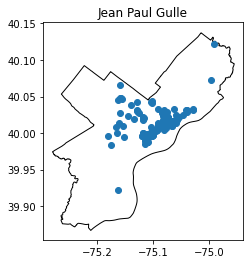

In [131]:
fig, ax = plt.subplots()
ax.set_title('Jean Paul Gulle')
city_boundaries.plot(ax = ax, color = "white", edgecolor = "black")
rtt_classified[rtt_classified['grantees_x_x'] == 'GULLE JEAN PAUL'].plot(ax = ax)

<AxesSubplot:title={'center':'Bank of America NA'}>

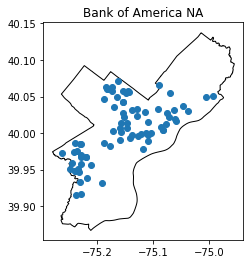

In [132]:
fig, ax = plt.subplots()
ax.set_title('Bank of America NA')
city_boundaries.plot(ax = ax, color = "white", edgecolor = "black")
rtt_classified[rtt_classified['grantees_x_x'] == 'BANK OF AMERICA NA'].plot(ax = ax)

<AxesSubplot:title={'center':'Wells Fargo Bank NA'}>

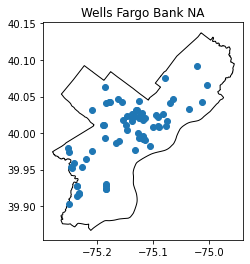

In [133]:
fig, ax = plt.subplots()
ax.set_title('Wells Fargo Bank NA')
city_boundaries.plot(ax = ax, color = "white", edgecolor = "black")
rtt_classified[rtt_classified['grantees_x_x'] == 'WELLS FARGO BANK NA'].plot(ax = ax)

<AxesSubplot:title={'center':'DMS Properties'}>

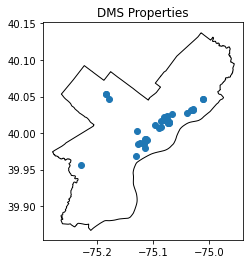

In [134]:
fig, ax = plt.subplots()
ax.set_title('DMS Properties')
city_boundaries.plot(ax = ax, color = "white", edgecolor = "black")
rtt_classified[rtt_classified['grantees_x_x'] == 'DMS PROPERTIES'].plot(ax = ax)

AttributeError: 'numpy.ndarray' object has no attribute 'set_aspect'

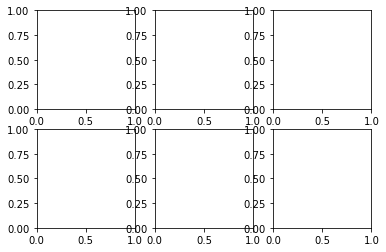

In [146]:
fig, axes = plt.subplots(nrows = 2, ncols = 3)
city_boundaries.plot(ax = axes[0], color = "white", edgecolor = "black")
rtt_classified[rtt_classified['grantees_x_x'] == 'DEMARCO DREW'].plot(ax = axes[0])

city_boundaries.plot(ax = axes[1], color = "white", edgecolor = "black")
rtt_classified[rtt_classified['grantees_x_x'] == 'LUBLIN WILLIAM H; WALSH JAMES'].plot(ax = axes[1])

city_boundaries.plot(ax = axes[2], color = "white", edgecolor = "black")
rtt_classified[rtt_classified['grantees_x_x'] == 'FOTIADIS NIKOLAOS; OSEROFF AARON'].plot(ax = axes[2])

city_boundaries.plot(ax = axes[3], color = "white", edgecolor = "black")
rtt_classified[rtt_classified['grantees_x_x'] == 'GULLE JEAN PAUL'].plot(ax = axes[3])

city_boundaries.plot(ax = axes[4], color = "white", edgecolor = "black")
rtt_classified[rtt_classified['grantees_x_x'] == 'BANK OF AMERICA NA'].plot(ax = axes[4])

city_boundaries.plot(ax = axes[5], color = "white", edgecolor = "black")
rtt_classified[rtt_classified['grantees_x_x'] == 'WELLS FARGO BANK NA'].plot(ax = axes[5])

 ## Questions
 - how to determine where the main/office address is for each investor?
 - Having some issues around projecting Philly, I tried projecting both the city boundaries and deeds datasets to 'epsg:2272' but it looks above like it's unprojected 
 - Is there any guess on what it means when a realtor is the grantee? Taking the top example, it seems extremely suspicious that Drew Demarco has over 1000 deeds under his name... Either he and many others like him are prolific house flippers or realtors are used as the middle man for large scale real estate investment? am I potrentially missing something here? 
 
 
 ## Notes
 Reology seems to be a big financer of single family rentals and operates through subsidiaries like Century 21 and Coldwell Banker which are high up on the list above. https://www.bloomberg.com/news/articles/2014-08-11/realogy-forms-division-to-manage-single-family-rentals
 
 
 ## Thoughts
 tracking some of the biggest investors through 3D visualizations like this https://www.nytimes.com/interactive/2018/04/17/us/san-francisco-earthquake-seismic-gamble.html could be interesting (doing it for multiple of the investors), with popups of the street view pulled from street view API like Dare did in the report